# Introduction

This notebook implements Differential Evolution with Novel Parameter Control (DE-NPC) proposed by Meng et al. (2020) [1]. 

Using DE-NPC and MNIST [2], an adversarial image is generated. The prediction of an RBF Network on the adversarial image and original image is displayed.

[1] Meng, Z., Chen, Y., & Li, X. (2020). Enhancing differential evolution with novel parametercontrol. IEEE Access,8, 51145–51167. \\
[2] LeCun, Y., Cortes, C., & Burges, C.  (2010). MNIST handwritten digit database.



# Libraries

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time
import operator
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from keras.models import load_model
from skimage.measure import compare_ssim as ssim
import pickle

#Set seeds
random.seed(1)
np.random.seed(1)

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# DE_NPC Class

In [0]:
#https://www.geeksforgeeks.org/python-peak-signal-to-noise-ratio-psnr/
from math import log10, sqrt 
import cv2 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [0]:
class DE_NPC:
  def __init__(self,param_dict):
    ###Load Params##
    self.img = param_dict["input"]
    self.imsize = param_dict["input_size"]
    self.imclass = param_dict["imclass"]
    self.mean = param_dict["mean"]
    self.std = param_dict["std"]
    self.R_min = param_dict["R_min"]
    self.R_max = param_dict["R_max"]
    self.nfe_max = param_dict["nfe_max"]
    self.PS_ini = param_dict["PS_ini"]
    self.PS_min = param_dict["PS_min"]
    self.K = param_dict["K"]
    self.rarc = param_dict["rarc"]
    self.p = param_dict["p"]
    self.model = param_dict["model"]

    ####Initialize Params####
    self.set_params()

  #Fitness function
  def fitness_func(self,individual):
    individual = individual.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
    pred = self.model.predict(individual  / 255.0)
    pred = pred[0]
    po = pred[self.imclass]
    pred[self.imclass] = 0
    pd = np.max(pred)
    diff = pd-po
    return (0.5)*diff + (0.5)*ssim(individual.reshape(32,32),self.img.reshape(32,32))

  #Given the population and img(whihc is necessary to calculate the fitness function)
  #choose one individual whose fitness value is in top p percent.
  def get_top_p(self,PS,p):
    num_best = int(PS*p)
    fitness =  [(individual,self.fitness_func(individual)) for individual in self.population[0:PS]]
    fitness.sort(key=lambda x: x[1])
    fitness = fitness[-num_best:]
    return random.choice(fitness)[0]

  def execute(self, model):
    not_improving = 0
    nfe = 0
    PS = self.PS_ini
    A_ind = 0
    G = 1
    start = time.time()
    while nfe < self.nfe_max:
      #############################INITIALIZATION###################################
      #Sets of successfull f and cr values
      #with the corresponding weights
      s_f = [[] for i in range(self.K)]
      s_f_weights = [[] for i in range(self.K)]
      s_cr = [[] for i in range(self.K)]
      s_cr_weights = [[] for i in range(self.K)]
      #the selected k values for this iteration
      k_selections = np.zeros((self.K,PS))
      #how many times the specific k value was a success/failure
      k_success = np.zeros((self.K,1))
      k_failure = np.zeros((self.K,1))

      ####################ADJUST POPULATION AND A###################################
      #Adjustment done due to keep the individuals' values in range.
      #and to reduce the array sizes. However, even if the population size gets 
      #smaller than PS, since the loops are in range(PS), the individuals stored in 
      #the population vector in indices > PS will not be reached. 
      #Instead of picking discarded individuals randomly, we shuffle the population
      #and archive array. It should amount to picking random.
      if G > 2:
        #Adjust the individuals of the population; 
        for i in range(PS):
          self.population[i] = np.clip(self.population[i], self.R_min, self.R_max).reshape(self.imsize)
        #Adjust storage A; 
        for i in range(self.A_size):
          self.A[i] = np.clip(self.A[i], self.R_min, self.R_max).reshape(self.imsize)
        np.random.shuffle(self.A)
        np.random.shuffle(self.population)

      #############################SELECT K,F,CR'S##################################  
      #We select a k value for each individual in the population
      #with respect to the selection probabilities (p_k) of each k.
      custm = stats.rv_discrete(name='custm', values=(np.arange(self.K).reshape(self.K,1), self.p_k))
      k_selections = custm.rvs(size=PS)
      #Get f and cr values for each individual
      for i in range(PS):
        self.cr[i]  = np.random.normal(self.mu_cr[k_selections[i]], 0.1, 1)
        if self.cr[i] < 0:
          self.cr[i] = 0
        self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        while self.f[i] <= 0:
          self.f[i] = cauchy.rvs(self.mu_f[k_selections[i]],0.1,1)
        if self.f[i] > 1:
          self.f[i] = 1
      
      ####################GENERATE U,V AND CALCULATE FITNESS########################
      #Generate donor and trial (U and V) vectors
      #Calculate the fitness values
      for i in range(PS):
        X_p_best =  self.get_top_p(PS,self.p).reshape((self.imsize,1))
        #X_r_1 denotes a random vector selection from the current population
        X_r_1 = random.choice(self.population[:PS]).reshape((self.imsize,1))
        #X_hat_r_2 denotes a randomly selected solution from the union A and P
        X_hat_r_2 = random.choice(np.concatenate((self.population[:PS], self.A[:self.A_size]), axis=0)).reshape((self.imsize,1))
        #mutation, generate trial vector
        self.V[i] = (self.population[i].reshape((self.imsize,1)) + self.f[i]*(X_p_best - self.population[i].reshape((self.imsize,1)))
               + self.f[i]*(X_r_1 - X_hat_r_2)).reshape(self.imsize)
        #crossover, generate donor vector
        self.U[i] = self.population[i]
        for j in range(self.imsize):
          if random.uniform(0, 1) <= self.cr[i]:
            self.U[i][j] = self.V[i][j]
        self.fitness_ind[i] = self.fitness_func(self.population[i])
        self.fitness_U[i] = self.fitness_func(self.U[i])

      ################################INCREMENT nfe#################################
      #Increment nfe
      nfe += PS

      #####################DETERMINE UN/SUCCESSFULL#################################
      #Determine the successful and unsuccessful cr,f,k values.
      #Add unsuccessful individuals to the archive
      for i in range(PS):
        k = k_selections[i]
        if self.fitness_ind[i] <= self.fitness_U[i]:
          s_cr[k].append(self.cr[i])
          s_cr_weights[k].append(np.std(np.subtract(self.population[i],self.U[i])))
          s_f[k].append(self.f[i])
          s_f_weights[k].append(self.fitness_U[i]-self.fitness_ind[i])
          self.population[i] = self.U[i]
          k_success[k] += 1
        else:
          if A_ind >= self.A_size:
            A_ind = 0
          self.A[A_ind] = self.population[i]
          A_ind += 1
          k_failure[k] += 1

      ######################UPDATE MU_CR AND MU_F's#################################
      #update params (mixed with Jade-like update)
      for k in range(self.K):
        if len(s_cr[k]) != 0:
          s_cr_weights[k] = s_cr_weights[k]/np.sum(s_cr_weights[k])
          s_f_weights[k] = s_f_weights[k]/np.sum(s_f_weights[k])
          mean_cr = np.sum(np.multiply(np.square(s_cr[k]),s_cr_weights[k]))/np.sum(np.multiply(s_cr[k],s_cr_weights[k]))
          mean_f = np.sum(np.multiply(np.square(s_f[k]),s_f_weights[k]))/np.sum(np.multiply(s_f[k],s_f_weights[k]))  
          #update mu_cr
          if (np.max(s_cr[k]) > 0) and (self.mu_cr[k] != 0):
            self.mu_cr[k] = mean_cr
          #update mu_f
          self.mu_f[k] = mean_f

      ###########################UPDATE GROUP PROBS#################################
      #Update group probabilities
      for k in range(self.K):
        if k_success[k] != 0:
          k_success[k] = np.square(k_success[k])/(np.sum(k_success[k])*(k_success[k]+k_failure[k]))
        else:
          self.p_k[k] = 0.000000001
      self.p_k = self.p_k/np.sum(self.p_k)

      ###########################END ITERATION######################################
      #increment generation count
      G += 1
      #Get the best individual
      self.X_best = self.get_top_p(PS,1/PS)
      if G > 2: 
        dist = 1-ssim(self.X_best.reshape(32,32),self.img.reshape(32,32))
        individual = self.X_best.reshape(1,int(np.sqrt(self.imsize)),int(np.sqrt(self.imsize)),1)
        pred = self.model.predict(np.clip(individual, 0, 255)  / 255.0)
        pred = pred[0]
        pred = np.argmax(pred)
        if dist<0.001 and pred != self.imclass[0]:
          self.X_best_fitness = self.fitness_func(self.X_best)
          print("FOUND! " ,nfe, " : "  ,self.X_best_fitness,PS)
          break
        if np.abs(self.X_best_fitness-self.fitness_func(self.X_best)) < 0.01:
          not_improving += 1
          if not_improving > 30:
             self.X_best_fitness = self.fitness_func(self.X_best)
             print(nfe, " : "  ,self.X_best_fitness,PS)
             break
        else:
          not_improving = 0

      #Get the fitness of best individual
      self.X_best_fitness = self.fitness_func(self.X_best)
      #Give feedback
      print(nfe, " : "  ,self.X_best_fitness,PS)

      ######################ADJUST POPULATION SIZE##################################
      #adjust population size 
      #else part changed. there is something wrong with the formula on the paper.
      #since the ends of the two partial functions do not meet, when nfe > x the 
      #population increases. change is to fix this.
      if nfe <= self.x:
        PS = int(np.ceil((((self.y-self.PS_ini)/np.square(self.x-self.PS_ini))*np.square(nfe-self.PS_ini)) + self.PS_ini))
      else:
        initial_formula = int(np.floor((((self.y-self.PS_ini)/(self.x-self.PS_min))*(nfe-self.nfe_max)) + self.PS_min))
        if initial_formula < PS:
          PS = initial_formula
      #adjust archive size according to the new population
      self.A_size = int(self.rarc*PS)
      #Note: archive update moved within "Determine un/successful" as the computation
      #would be too redundant.  
    end = time.time()
    print("Time: ",end-start ," seconds")
    return end-start,nfe

  def change_input(self,img,imclass,imsize):
    self.img = img
    self.imsize = imsize
    self.imclass = imclass
    self.set_params()

  def set_params(self):
    #Calculate pivot for dynamic population change
    self.x = (1/3)*self.nfe_max
    self.y = (2/3)*self.PS_ini     
    #probability of belonging to a group
    self.p_k = np.ones((self.K,1))*(1/self.K)   
    #archive
    self.A_size = int(self.PS_ini*self.rarc)
    self.A = np.zeros((self.A_size,self.imsize))
    #scale factor
    self.f = np.ones((self.PS_ini,1)) 
    self.mu_f = np.ones((self.K,1)) *0.5
    #crossover probability
    self.cr = np.ones((self.PS_ini,1)) 
    self.mu_cr = np.ones((self.K,1)) *0.5
    #Initial population
    self.population = np.zeros((self.PS_ini,self.imsize))
    #Fitness functions
    self.fitness_ind = np.zeros((self.PS_ini,1))
    self.fitness_U = np.zeros((self.PS_ini,1))
    #donor and trial vectors
    self.V = np.zeros((self.PS_ini,self.imsize))
    self.U = np.zeros((self.PS_ini,self.imsize))
    for i in range(self.PS_ini):
      noisy_img = self.img + np.random.normal(self.mean, self.std, (self.imsize,1))
      self.population[i] = np.clip(noisy_img, 0, 255).reshape(self.imsize)
    self.X_best = None
    self.X_best_fitness = None

# Download Neural Network

In [0]:
model = load_model("CNN_CIFAR10_net3.h5")

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

# Prepare Data

In [0]:
import pickle
file_ = open('subset_cifar', 'rb')
dump = pickle.load(file_)
adversarial = pickle.load(file_)
dump = pickle.load(file_)
adversarial_y = pickle.load(file_)
file_.close()
del dump

# Evolve

In [0]:
param_dict = {
    "model" : model,
    #Image to be evolved
    "input" : adversarial[0].reshape((32*32,1)),
    "input_size" : 32*32,
    "imclass" : adversarial_y[0],
    #Mean and std for Gaussian noise
    #good results with 10-10
    "mean" : 0, #50(5)   #150 (1)
    "std" : 10, #50 (5) #200 (1) (it was 100)
    #Range
    "R_min" : 0.0,
    "R_max" : 255.0,
    #Maximum number of function evaluations
    "nfe_max" : 10000,#4000 #5000(6) #50000(3)  #10000 (2)
    #Initial and minimum population size
    "PS_ini" : 25, #100 #200(4)
    "PS_min" : 4,
    #Number of groups
    "K" : 7,
    #ratio of the external archive size to the whole population PS
    "rarc" : 1.6,
    #percentage p when we select an individual among top p fits
    "p" : 0.11
}

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


25  :  [0.8498645] 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:168: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


50  :  [0.8503251] 25
75  :  [0.85210097] 25
100  :  [0.86170274] 25
125  :  [0.86750734] 25
150  :  [0.8682924] 25
175  :  [0.8685577] 25
200  :  [0.8713382] 25
225  :  [0.8713382] 25
250  :  [0.8777737] 25
275  :  [0.8866203] 25
300  :  [0.8918222] 25
325  :  [0.891938] 25
350  :  [0.891938] 25
375  :  [0.8957969] 25
400  :  [0.9024334] 25
425  :  [0.9091344] 25
450  :  [0.9090544] 25
475  :  [0.9090544] 25
500  :  [0.9090544] 25
525  :  [0.9120917] 25
550  :  [0.91209066] 25
575  :  [0.91334784] 25
600  :  [0.9157697] 25
625  :  [0.91791916] 25
650  :  [0.9195907] 25
675  :  [0.9218279] 25
700  :  [0.9219012] 25
725  :  [0.9230441] 25
750  :  [0.9230441] 25
775  :  [0.9268367] 25
800  :  [0.9268367] 25
Time:  125.90742373466492  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


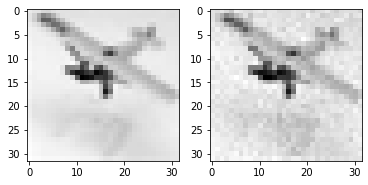

25  :  [0.9096249] 25
50  :  [0.9096249] 25
75  :  [0.9096249] 25
100  :  [0.9178982] 25
125  :  [0.9267827] 25
150  :  [0.93510425] 25
175  :  [0.9437691] 25
200  :  [0.9532448] 25
225  :  [0.95758295] 25
250  :  [0.95758295] 25
275  :  [0.95758295] 25
300  :  [0.9586123] 25
325  :  [0.9586123] 25
350  :  [0.95876586] 25
375  :  [0.95876586] 25
400  :  [0.95876586] 25
425  :  [0.961499] 25
450  :  [0.9630712] 25
475  :  [0.9630712] 25
500  :  [0.9697684] 25
525  :  [0.9697684] 25
550  :  [0.9714882] 25
575  :  [0.9714882] 25
600  :  [0.9722554] 25
625  :  [0.9737866] 25
650  :  [0.9737866] 25
675  :  [0.9737866] 25
700  :  [0.9755744] 25
725  :  [0.97748154] 25
750  :  [0.9777066] 25
775  :  [0.9777066] 25
800  :  [0.9801518] 25
Time:  126.63655042648315  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


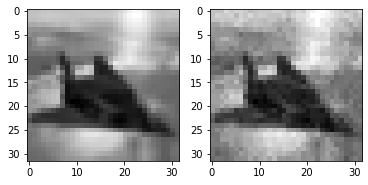

25  :  [0.897344] 25
50  :  [0.8991542] 25
75  :  [0.90758353] 25
100  :  [0.90758353] 25
125  :  [0.90758353] 25
150  :  [0.9078814] 25
175  :  [0.9237979] 25
200  :  [0.93559754] 25
225  :  [0.93559754] 25
250  :  [0.93559754] 25
275  :  [0.9386179] 25
300  :  [0.9386179] 25
325  :  [0.94245636] 25
350  :  [0.94844675] 25
375  :  [0.95089716] 25
400  :  [0.95224035] 25
425  :  [0.9544227] 25
450  :  [0.9544227] 25
475  :  [0.9544227] 25
500  :  [0.95483446] 25
525  :  [0.9575187] 25
550  :  [0.9575187] 25
575  :  [0.9575187] 25
600  :  [0.9575187] 25
625  :  [0.9575187] 25
650  :  [0.9584055] 25
675  :  [0.9584055] 25
700  :  [0.9584055] 25
725  :  [0.9586009] 25
750  :  [0.9589217] 25
775  :  [0.9590435] 25
800  :  [0.9599543] 25
825  :  [0.96032774] 25
850  :  [0.96032774] 25
875  :  [0.9603559] 25
900  :  [0.9607316] 25
925  :  [0.9608748] 25
950  :  [0.96100634] 25
975  :  [0.9610628] 25
Time:  154.51243829727173  seconds
Original class:  0
Prediction for normal image:  [0]
Predi

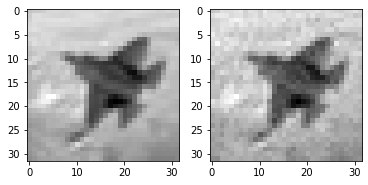

25  :  [0.9396472] 25
50  :  [0.9396472] 25
75  :  [0.9396472] 25
100  :  [0.9396472] 25
125  :  [0.94048357] 25
150  :  [0.9432784] 25
175  :  [0.9432784] 25
200  :  [0.9432784] 25
225  :  [0.9432784] 25
250  :  [0.9432784] 25
275  :  [0.9432784] 25
300  :  [0.9432784] 25
325  :  [0.9432784] 25
350  :  [0.94384676] 25
375  :  [0.953018] 25
400  :  [0.953018] 25
425  :  [0.953018] 25
450  :  [0.953018] 25
475  :  [0.9548072] 25
500  :  [0.9548072] 25
525  :  [0.9579047] 25
550  :  [0.9579047] 25
575  :  [0.96022654] 25
600  :  [0.96022654] 25
625  :  [0.96022654] 25
650  :  [0.96022654] 25
675  :  [0.9606229] 25
700  :  [0.9626504] 25
725  :  [0.9626827] 25
750  :  [0.9626827] 25
775  :  [0.9626827] 25
800  :  [0.9641824] 25
Time:  128.46878695487976  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


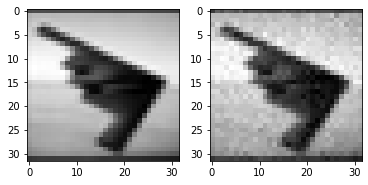

25  :  [0.85550714] 25
50  :  [0.85936546] 25
75  :  [0.8593683] 25
100  :  [0.86660206] 25
125  :  [0.86660206] 25
150  :  [0.86660206] 25
175  :  [0.8676795] 25
200  :  [0.87079644] 25
225  :  [0.87079644] 25
250  :  [0.87079644] 25
275  :  [0.87079644] 25
300  :  [0.87079644] 25
325  :  [0.87079644] 25
350  :  [0.8719996] 25
375  :  [0.87327164] 25
400  :  [0.87636065] 25
425  :  [0.87636065] 25
450  :  [0.87636065] 25
475  :  [0.8767117] 25
500  :  [0.8767117] 25
525  :  [0.87747633] 25
550  :  [0.87769544] 25
575  :  [0.8782301] 25
600  :  [0.8782635] 25
625  :  [0.87841] 25
650  :  [0.8793191] 25
675  :  [0.879483] 25
700  :  [0.87966514] 25
725  :  [0.87966514] 25
750  :  [0.8800212] 25
775  :  [0.88008654] 25
800  :  [0.8801752] 25
Time:  126.64767932891846  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:  [2]


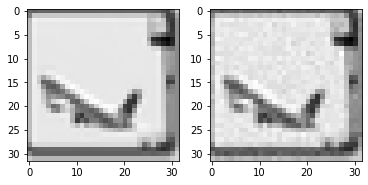

25  :  [0.73819196] 25
50  :  [0.73819196] 25
75  :  [0.73819196] 25
100  :  [0.7414674] 25
125  :  [0.7414674] 25
150  :  [0.7414674] 25
175  :  [0.7432345] 25
200  :  [0.7454082] 25
225  :  [0.7513365] 25
250  :  [0.7513365] 25
275  :  [0.7680688] 25
300  :  [0.7680688] 25
325  :  [0.7680688] 25
350  :  [0.7680688] 25
375  :  [0.7680688] 25
400  :  [0.7680688] 25
425  :  [0.7824774] 25
450  :  [0.7824774] 25
475  :  [0.78734297] 25
500  :  [0.78967583] 25
525  :  [0.78967583] 25
550  :  [0.7958697] 25
575  :  [0.7958697] 25
600  :  [0.79606706] 25
625  :  [0.79606706] 25
650  :  [0.7978581] 25
675  :  [0.8006162] 25
700  :  [0.80132765] 25
725  :  [0.80338025] 25
750  :  [0.8050598] 25
775  :  [0.80520546] 25
800  :  [0.8054794] 25
825  :  [0.80579096] 25
850  :  [0.80601215] 25
875  :  [0.8070477] 25
900  :  [0.8070477] 25
925  :  [0.8075481] 25
950  :  [0.8075481] 25
975  :  [0.80796707] 25
1000  :  [0.80796707] 25
1025  :  [0.8080842] 25
1050  :  [0.8080842] 25
1075  :  [0.8086827

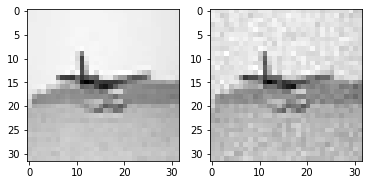

25  :  [0.76371694] 25
50  :  [0.7962505] 25
75  :  [0.7108817] 25
100  :  [0.8239152] 25
125  :  [0.8079057] 25
150  :  [0.8079057] 25
175  :  [0.8079057] 25
200  :  [0.8079057] 25
225  :  [0.8079057] 25
250  :  [0.8079057] 25
275  :  [0.81487584] 25
300  :  [0.81487584] 25
325  :  [0.81487584] 25
350  :  [0.81487584] 25
375  :  [0.81487584] 25
400  :  [0.81487584] 25
425  :  [0.81487584] 25
450  :  [0.81591976] 25
475  :  [0.817575] 25
500  :  [0.817575] 25
525  :  [0.817575] 25
550  :  [0.82241535] 25
575  :  [0.82241535] 25
600  :  [0.825331] 25
625  :  [0.82525355] 25
650  :  [0.82525355] 25
675  :  [0.82525355] 25
700  :  [0.82525355] 25
725  :  [0.82525355] 25
750  :  [0.8265022] 25
775  :  [0.84971285] 25
800  :  [0.8516562] 25
825  :  [0.8516562] 25
850  :  [0.8516562] 25
875  :  [0.8521302] 25
900  :  [0.85213774] 25
925  :  [0.85213774] 25
950  :  [0.85213774] 25
975  :  [0.85213774] 25
1000  :  [0.85213774] 25
1025  :  [0.85213774] 25
1050  :  [0.85213774] 25
1075  :  [0.85

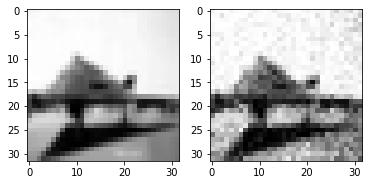

25  :  [0.88863623] 25
50  :  [0.91796994] 25
75  :  [0.91052854] 25
100  :  [0.91052854] 25
125  :  [0.9206676] 25
150  :  [0.92504007] 25
175  :  [0.92344147] 25
200  :  [0.930158] 25
225  :  [0.9279236] 25
250  :  [0.9279236] 25
275  :  [0.9305164] 25
300  :  [0.9504169] 25
325  :  [0.9504169] 25
350  :  [0.9504169] 25
375  :  [0.9504169] 25
400  :  [0.9504169] 25
425  :  [0.9504169] 25
450  :  [0.9504169] 25
475  :  [0.9504169] 25
500  :  [0.9504169] 25
525  :  [0.9504169] 25
550  :  [0.9504169] 25
575  :  [0.9504169] 25
600  :  [0.9504169] 25
625  :  [0.9520128] 25
650  :  [0.9520128] 25
675  :  [0.95446634] 25
700  :  [0.95446634] 25
725  :  [0.95446634] 25
750  :  [0.95446634] 25
775  :  [0.95518637] 25
800  :  [0.95744526] 25
825  :  [0.95804435] 25
850  :  [0.9583212] 25
875  :  [0.9583212] 25
900  :  [0.95844525] 25
925  :  [0.95943034] 25
950  :  [0.96017176] 25
975  :  [0.96017176] 25
1000  :  [0.9604689] 25
1025  :  [0.96085215] 25
1050  :  [0.9610226] 25
1075  :  [0.96121

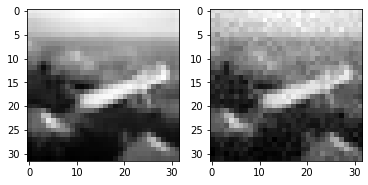

25  :  [0.7926518] 25
50  :  [0.83039176] 25
75  :  [0.8267691] 25
100  :  [0.86607754] 25
125  :  [0.8664615] 25
150  :  [0.8664615] 25
175  :  [0.8664615] 25
200  :  [0.8664615] 25
225  :  [0.8664615] 25
250  :  [0.8664615] 25
275  :  [0.8664615] 25
300  :  [0.8664615] 25
325  :  [0.8664615] 25
350  :  [0.8664615] 25
375  :  [0.8664615] 25
400  :  [0.8674518] 25
425  :  [0.8674518] 25
450  :  [0.8674518] 25
475  :  [0.8674518] 25
500  :  [0.8689876] 25
525  :  [0.8689876] 25
550  :  [0.869596] 25
575  :  [0.869596] 25
600  :  [0.869596] 25
625  :  [0.869596] 25
650  :  [0.869596] 25
675  :  [0.869596] 25
700  :  [0.8838968] 25
725  :  [0.8838881] 25
750  :  [0.88443065] 25
775  :  [0.8881589] 25
800  :  [0.8881589] 25
825  :  [0.88874495] 25
850  :  [0.8890606] 25
875  :  [0.8890606] 25
900  :  [0.8890606] 25
925  :  [0.8890606] 25
950  :  [0.8890606] 25
975  :  [0.8891105] 25
1000  :  [0.88993555] 25
1025  :  [0.89041424] 25
1050  :  [0.8908288] 25
1075  :  [0.8926895] 25
1100  :  [

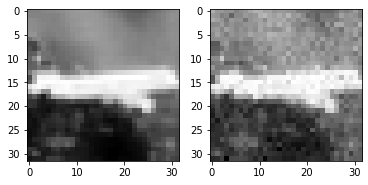

25  :  [0.834889] 25
50  :  [0.84735155] 25
75  :  [0.8564307] 25
100  :  [0.8727748] 25
125  :  [0.8727748] 25
150  :  [0.8773633] 25
175  :  [0.88399935] 25
200  :  [0.88399935] 25
225  :  [0.8972606] 25
250  :  [0.90390646] 25
275  :  [0.90390646] 25
300  :  [0.9040378] 25
325  :  [0.9150526] 25
350  :  [0.9150526] 25
375  :  [0.91683936] 25
400  :  [0.91683936] 25
425  :  [0.9174457] 25
450  :  [0.91966534] 25
475  :  [0.91966534] 25
500  :  [0.92403436] 25
525  :  [0.9265846] 25
550  :  [0.9265846] 25
575  :  [0.928283] 25
600  :  [0.93049675] 25
625  :  [0.9328071] 25
650  :  [0.9328071] 25
675  :  [0.93307364] 25
700  :  [0.93307364] 25
725  :  [0.9339553] 25
750  :  [0.9345203] 25
775  :  [0.9347024] 25
800  :  [0.935032] 25
825  :  [0.9352728] 25
850  :  [0.93634474] 25
875  :  [0.93634474] 25
900  :  [0.9366887] 25
925  :  [0.9366887] 25
950  :  [0.9369215] 25
975  :  [0.93780595] 25
1000  :  [0.9381453] 25
1025  :  [0.9385202] 25
1050  :  [0.9385983] 25
1075  :  [0.9385983] 

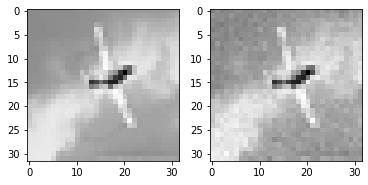

25  :  [0.8872411] 25
50  :  [0.8872411] 25
75  :  [0.8986399] 25
100  :  [0.89955926] 25
125  :  [0.89955926] 25
150  :  [0.91097736] 25
175  :  [0.91094697] 25
200  :  [0.91094697] 25
225  :  [0.91094697] 25
250  :  [0.91094697] 25
275  :  [0.91094697] 25
300  :  [0.91094697] 25
325  :  [0.91094697] 25
350  :  [0.91094697] 25
375  :  [0.91094697] 25
400  :  [0.91094697] 25
425  :  [0.91094697] 25
450  :  [0.91094697] 25
475  :  [0.91094697] 25
500  :  [0.91094697] 25
525  :  [0.91094697] 25
550  :  [0.91505075] 25
575  :  [0.91505075] 25
600  :  [0.91505075] 25
625  :  [0.91505075] 25
650  :  [0.92055833] 25
675  :  [0.92648524] 25
700  :  [0.92648524] 25
725  :  [0.92648524] 25
750  :  [0.92648524] 25
775  :  [0.92648524] 25
800  :  [0.92648524] 25
825  :  [0.9281961] 25
850  :  [0.9281961] 25
875  :  [0.9290662] 25
900  :  [0.92978173] 25
925  :  [0.92978173] 25
Time:  153.82164454460144  seconds
Original class:  0
Prediction for normal image:  [0]
Prediction for adversarial image:

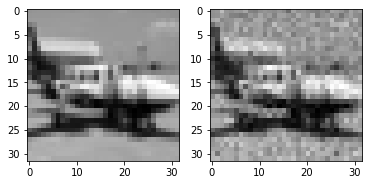

25  :  [0.90099454] 25
50  :  [0.90099454] 25
75  :  [0.90099454] 25
100  :  [0.9118074] 25
125  :  [0.9118074] 25
150  :  [0.9118074] 25
175  :  [0.9118074] 25
200  :  [0.9118074] 25
225  :  [0.9208329] 25
250  :  [0.9208329] 25
275  :  [0.9208329] 25
300  :  [0.92562246] 25
325  :  [0.9300975] 25
350  :  [0.9301517] 25
375  :  [0.94106215] 25
400  :  [0.9444659] 25
425  :  [0.9503027] 25
450  :  [0.9503027] 25
475  :  [0.95480615] 25
500  :  [0.95480615] 25
525  :  [0.95796514] 25
550  :  [0.9603881] 25
575  :  [0.9623121] 25
600  :  [0.9644233] 25
625  :  [0.96672046] 25
650  :  [0.96682847] 25
675  :  [0.9685085] 25
700  :  [0.9685085] 25
725  :  [0.96859336] 25
750  :  [0.96859336] 25
775  :  [0.96885335] 25
800  :  [0.96901095] 25
825  :  [0.9696208] 25
850  :  [0.9696208] 25
875  :  [0.970091] 25
900  :  [0.970091] 25
925  :  [0.9701676] 25
950  :  [0.9704976] 25
975  :  [0.9704976] 25
1000  :  [0.9704976] 25
1025  :  [0.9704976] 25
1050  :  [0.9706024] 25
1075  :  [0.9707032] 2

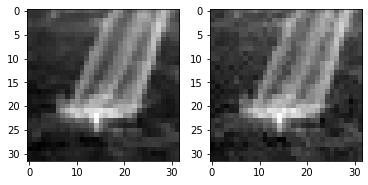

25  :  [0.9350046] 25
50  :  [0.9350046] 25
75  :  [0.9350046] 25
100  :  [0.9440688] 25
125  :  [0.9440688] 25
150  :  [0.9440688] 25
175  :  [0.9440688] 25
200  :  [0.94984084] 25
225  :  [0.94984084] 25
250  :  [0.94984084] 25
275  :  [0.94984084] 25
300  :  [0.94984084] 25
325  :  [0.94984084] 25
350  :  [0.96228635] 25
375  :  [0.96228635] 25
400  :  [0.96228635] 25
425  :  [0.96669996] 25
450  :  [0.96669996] 25
475  :  [0.96669996] 25
500  :  [0.9714546] 25
525  :  [0.9724884] 25
550  :  [0.9726757] 25
575  :  [0.9726757] 25
600  :  [0.9726757] 25
625  :  [0.9726757] 25
650  :  [0.9726757] 25
675  :  [0.9726757] 25
700  :  [0.9750966] 25
725  :  [0.9771247] 25
750  :  [0.9771247] 25
775  :  [0.9771247] 25
800  :  [0.9771247] 25
825  :  [0.9771247] 25
850  :  [0.9773458] 25
875  :  [0.9773458] 25
900  :  [0.9773458] 25
925  :  [0.97736925] 25
950  :  [0.9793594] 25
975  :  [0.9794657] 25
1000  :  [0.9794762] 25
1025  :  [0.9794762] 25
1050  :  [0.9800718] 25
1075  :  [0.9801341] 

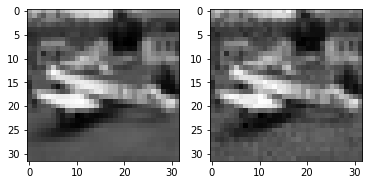

25  :  [0.9431106] 25
50  :  [0.9431106] 25
75  :  [0.94532824] 25
100  :  [0.94532824] 25
125  :  [0.94532824] 25
150  :  [0.94532824] 25
175  :  [0.94532824] 25
200  :  [0.94532824] 25
225  :  [0.94615185] 25
250  :  [0.94668347] 25
275  :  [0.94681007] 25
300  :  [0.9468098] 25
325  :  [0.9486444] 25
350  :  [0.9495002] 25
375  :  [0.9493993] 25
400  :  [0.9493993] 25
425  :  [0.9493993] 25
450  :  [0.9493993] 25
475  :  [0.95413876] 25
500  :  [0.95413876] 25
525  :  [0.95413876] 25
550  :  [0.95413876] 25
575  :  [0.95413876] 25
600  :  [0.95413876] 25
625  :  [0.9566576] 25
650  :  [0.9565233] 25
675  :  [0.9565233] 25
700  :  [0.9565233] 25
725  :  [0.9585793] 25
750  :  [0.95900226] 25
775  :  [0.9591992] 25
800  :  [0.9591992] 25
Time:  133.53169322013855  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


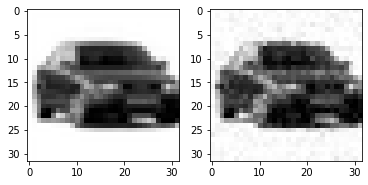

25  :  [0.96251905] 25
50  :  [0.96251905] 25
75  :  [0.96251905] 25
100  :  [0.96251905] 25
125  :  [0.96251905] 25
150  :  [0.96251905] 25
175  :  [0.96251905] 25
200  :  [0.96251905] 25
225  :  [0.96251905] 25
250  :  [0.9654821] 25
275  :  [0.9654821] 25
300  :  [0.9675448] 25
325  :  [0.96811736] 25
350  :  [0.96811736] 25
375  :  [0.97434175] 25
400  :  [0.97434175] 25
425  :  [0.97434175] 25
450  :  [0.97434175] 25
475  :  [0.97434175] 25
500  :  [0.97434175] 25
525  :  [0.97434175] 25
550  :  [0.97434175] 25
575  :  [0.974411] 25
600  :  [0.9750411] 25
625  :  [0.9750411] 25
650  :  [0.9759558] 25
675  :  [0.9760989] 25
700  :  [0.9764981] 25
725  :  [0.9764981] 25
750  :  [0.9764981] 25
775  :  [0.9766949] 25
800  :  [0.9769298] 25
Time:  131.19932961463928  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [2]


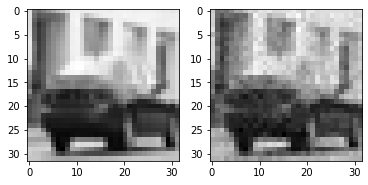

25  :  [0.8610879] 25
50  :  [0.8610879] 25
75  :  [0.8610879] 25
100  :  [0.8610879] 25
125  :  [0.86346203] 25
150  :  [0.86756516] 25
175  :  [0.86756516] 25
200  :  [0.86756516] 25
225  :  [0.86756516] 25
250  :  [0.86756516] 25
275  :  [0.86756516] 25
300  :  [0.86756516] 25
325  :  [0.86756516] 25
350  :  [0.86756516] 25
375  :  [0.86756516] 25
400  :  [0.86756516] 25
425  :  [0.86756516] 25
450  :  [0.86822283] 25
475  :  [0.87277824] 25
500  :  [0.8821162] 25
525  :  [0.8833922] 25
550  :  [0.8833922] 25
575  :  [0.8833922] 25
600  :  [0.8833922] 25
625  :  [0.8833922] 25
650  :  [0.8833922] 25
675  :  [0.8875648] 25
700  :  [0.8910533] 25
725  :  [0.8910533] 25
750  :  [0.8910533] 25
775  :  [0.8920686] 25
800  :  [0.89356196] 25
Time:  132.72304701805115  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


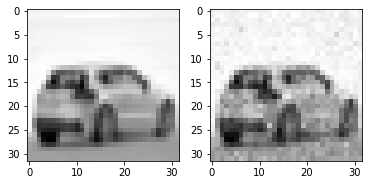

25  :  [0.93476105] 25
50  :  [0.93476105] 25
75  :  [0.93476105] 25
100  :  [0.93476105] 25
125  :  [0.93476105] 25
150  :  [0.94790983] 25
175  :  [0.9538268] 25
200  :  [0.9545501] 25
225  :  [0.95551693] 25
250  :  [0.9555553] 25
275  :  [0.9555553] 25
300  :  [0.9555553] 25
325  :  [0.95741796] 25
350  :  [0.95741796] 25
375  :  [0.95741796] 25
400  :  [0.9589459] 25
425  :  [0.9635428] 25
450  :  [0.9696785] 25
475  :  [0.9696785] 25
500  :  [0.9708264] 25
525  :  [0.9708264] 25
550  :  [0.97232264] 25
575  :  [0.9723947] 25
600  :  [0.9723947] 25
625  :  [0.9723947] 25
650  :  [0.978591] 25
675  :  [0.97862387] 25
700  :  [0.97862387] 25
725  :  [0.97862387] 25
750  :  [0.97862387] 25
775  :  [0.9805012] 25
800  :  [0.9805105] 25
825  :  [0.980617] 25
850  :  [0.9814696] 25
875  :  [0.9814696] 25
900  :  [0.9816855] 25
925  :  [0.9816855] 25
Time:  153.31820034980774  seconds
Original class:  1
Prediction for normal image:  [7]
Prediction for adversarial image:  [2]


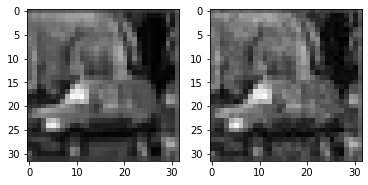

25  :  [0.9123136] 25
50  :  [0.9123136] 25
75  :  [0.9123136] 25
100  :  [0.9123136] 25
125  :  [0.9123136] 25
150  :  [0.92059326] 25
175  :  [0.9205929] 25
200  :  [0.9205929] 25
225  :  [0.9279208] 25
250  :  [0.9279208] 25
275  :  [0.9279208] 25
300  :  [0.9279208] 25
325  :  [0.9301834] 25
350  :  [0.9372697] 25
375  :  [0.9388745] 25
400  :  [0.9388745] 25
425  :  [0.9425992] 25
450  :  [0.9425992] 25
475  :  [0.9425992] 25
500  :  [0.9440398] 25
525  :  [0.9473329] 25
550  :  [0.9537916] 25
575  :  [0.95379615] 25
600  :  [0.95379615] 25
625  :  [0.954762] 25
650  :  [0.95558506] 25
675  :  [0.95558506] 25
700  :  [0.95558506] 25
725  :  [0.9568688] 25
750  :  [0.9568688] 25
775  :  [0.9568688] 25
800  :  [0.95775306] 25
Time:  132.28963112831116  seconds
Original class:  1
Prediction for normal image:  [6]
Prediction for adversarial image:  [6]


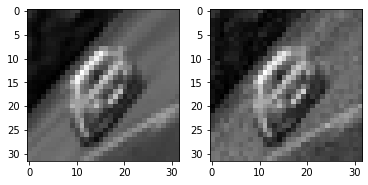

25  :  [0.8974258] 25
50  :  [0.8974258] 25
75  :  [0.89863026] 25
100  :  [0.90652037] 25
125  :  [0.9066854] 25
150  :  [0.9066854] 25
175  :  [0.9153438] 25
200  :  [0.9153438] 25
225  :  [0.9153438] 25
250  :  [0.9153438] 25
275  :  [0.9153438] 25
300  :  [0.9321032] 25
325  :  [0.9321032] 25
350  :  [0.9374497] 25
375  :  [0.9374497] 25
400  :  [0.9418568] 25
425  :  [0.9469193] 25
450  :  [0.9469211] 25
475  :  [0.9469211] 25
500  :  [0.9503931] 25
525  :  [0.9503931] 25
550  :  [0.95407295] 25
575  :  [0.95407295] 25
600  :  [0.9554115] 25
625  :  [0.9554115] 25
650  :  [0.9565983] 25
675  :  [0.9586557] 25
700  :  [0.9586557] 25
725  :  [0.9586557] 25
750  :  [0.9586557] 25
775  :  [0.9586557] 25
800  :  [0.9600921] 25
825  :  [0.9600921] 25
850  :  [0.96175075] 25
875  :  [0.96175075] 25
900  :  [0.9630529] 25
925  :  [0.9630529] 25
950  :  [0.9630529] 25
975  :  [0.96408665] 25
1000  :  [0.96408665] 25
1025  :  [0.96581125] 25
1050  :  [0.96581125] 25
1075  :  [0.96691227] 25

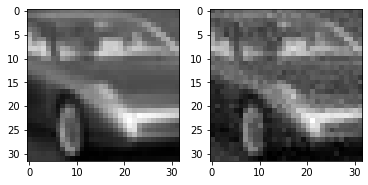

25  :  [0.7586101] 25
50  :  [0.77775395] 25
75  :  [0.8724402] 25
100  :  [0.8724402] 25
125  :  [0.87324214] 25
150  :  [0.8724625] 25
175  :  [0.87473756] 25
200  :  [0.87333345] 25
225  :  [0.87445486] 25
250  :  [0.87445486] 25
275  :  [0.87445486] 25
300  :  [0.9107753] 25
325  :  [0.9105986] 25
350  :  [0.9105986] 25
375  :  [0.9105986] 25
400  :  [0.9105986] 25
425  :  [0.9105986] 25
450  :  [0.9105986] 25
475  :  [0.9105986] 25
500  :  [0.9105986] 25
525  :  [0.9105986] 25
550  :  [0.9105986] 25
575  :  [0.9105986] 25
600  :  [0.915032] 25
625  :  [0.915032] 25
650  :  [0.915032] 25
675  :  [0.915032] 25
700  :  [0.916939] 25
725  :  [0.916939] 25
750  :  [0.916939] 25
775  :  [0.916939] 25
800  :  [0.92977196] 25
825  :  [0.92977196] 25
850  :  [0.92977196] 25
875  :  [0.92977196] 25
900  :  [0.92977196] 25
925  :  [0.92977196] 25
950  :  [0.93151283] 25
975  :  [0.93151283] 25
1000  :  [0.93151283] 25
1025  :  [0.93151283] 25
1050  :  [0.93712854] 25
1075  :  [0.9371507] 25


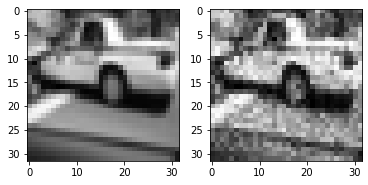

25  :  [0.92147815] 25
50  :  [0.9424467] 25
75  :  [0.942431] 25
100  :  [0.942431] 25
125  :  [0.942431] 25
150  :  [0.942431] 25
175  :  [0.942431] 25
200  :  [0.942431] 25
225  :  [0.942431] 25
250  :  [0.942431] 25
275  :  [0.942431] 25
300  :  [0.942431] 25
325  :  [0.942431] 25
350  :  [0.942431] 25
375  :  [0.942431] 25
400  :  [0.94304585] 25
425  :  [0.94304585] 25
450  :  [0.94304585] 25
475  :  [0.9439628] 25
500  :  [0.9439628] 25
525  :  [0.9439628] 25
550  :  [0.9452354] 25
575  :  [0.9452354] 25
600  :  [0.94721717] 25
625  :  [0.94721717] 25
650  :  [0.94721717] 25
675  :  [0.9482047] 25
700  :  [0.9482047] 25
725  :  [0.9482047] 25
750  :  [0.9512406] 25
775  :  [0.9512406] 25
800  :  [0.9538215] 25
825  :  [0.9538215] 25
Time:  138.59524154663086  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [2]


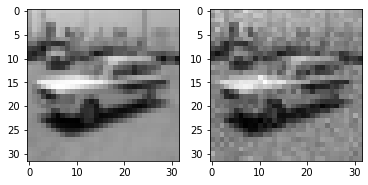

25  :  [0.9032687] 25
50  :  [0.9032687] 25
75  :  [0.9050596] 25
100  :  [0.9050596] 25
125  :  [0.91785645] 25
150  :  [0.9261059] 25
175  :  [0.9261059] 25
200  :  [0.93612456] 25
225  :  [0.9363813] 25
250  :  [0.9404174] 25
275  :  [0.9404174] 25
300  :  [0.9440063] 25
325  :  [0.9450789] 25
350  :  [0.94510317] 25
375  :  [0.94510317] 25
400  :  [0.94510317] 25
425  :  [0.94510317] 25
450  :  [0.94510317] 25
475  :  [0.946239] 25
500  :  [0.9512054] 25
525  :  [0.9513029] 25
550  :  [0.95141214] 25
575  :  [0.9515016] 25
600  :  [0.9524873] 25
625  :  [0.9560771] 25
650  :  [0.9560771] 25
675  :  [0.9560771] 25
700  :  [0.95728874] 25
725  :  [0.957565] 25
750  :  [0.9596714] 25
775  :  [0.96083724] 25
800  :  [0.96083724] 25
825  :  [0.96289146] 25
850  :  [0.9635488] 25
875  :  [0.9635488] 25
900  :  [0.9643465] 25
925  :  [0.964452] 25
950  :  [0.9645737] 25
975  :  [0.9645737] 25
Time:  161.1589229106903  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction

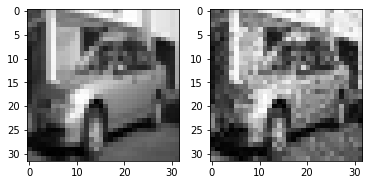

25  :  [0.9570174] 25
50  :  [0.9570174] 25
75  :  [0.9603599] 25
100  :  [0.96038544] 25
125  :  [0.9612372] 25
150  :  [0.96306413] 25
175  :  [0.96386397] 25
200  :  [0.96456945] 25
225  :  [0.9646243] 25
250  :  [0.9646243] 25
275  :  [0.9646243] 25
300  :  [0.9646243] 25
325  :  [0.9653594] 25
350  :  [0.9662383] 25
375  :  [0.96703184] 25
400  :  [0.96703184] 25
425  :  [0.96703184] 25
450  :  [0.96703184] 25
475  :  [0.96703184] 25
500  :  [0.96868384] 25
525  :  [0.96868414] 25
550  :  [0.96868414] 25
575  :  [0.97148407] 25
600  :  [0.97148407] 25
625  :  [0.97148407] 25
650  :  [0.97148407] 25
675  :  [0.9718243] 25
700  :  [0.9734981] 25
725  :  [0.9734981] 25
750  :  [0.9734981] 25
775  :  [0.9734981] 25
800  :  [0.9734981] 25
Time:  131.98378920555115  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


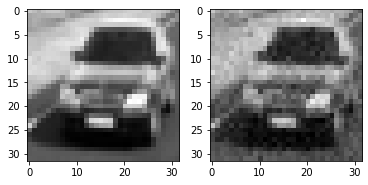

25  :  [0.9276332] 25
50  :  [0.9276332] 25
75  :  [0.92693704] 25
100  :  [0.92693704] 25
125  :  [0.93569183] 25
150  :  [0.93569183] 25
175  :  [0.94253725] 25
200  :  [0.94253725] 25
225  :  [0.94253725] 25
250  :  [0.9444177] 25
275  :  [0.94889086] 25
300  :  [0.954381] 25
325  :  [0.954381] 25
350  :  [0.954381] 25
375  :  [0.954381] 25
400  :  [0.954381] 25
425  :  [0.95741075] 25
450  :  [0.9603763] 25
475  :  [0.9603763] 25
500  :  [0.9625837] 25
525  :  [0.9625837] 25
550  :  [0.9625837] 25
575  :  [0.9625837] 25
600  :  [0.963583] 25
625  :  [0.96663964] 25
650  :  [0.96777916] 25
675  :  [0.96777916] 25
700  :  [0.96793264] 25
725  :  [0.9703928] 25
750  :  [0.9703928] 25
775  :  [0.9703928] 25
800  :  [0.97100115] 25
Time:  130.98477339744568  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


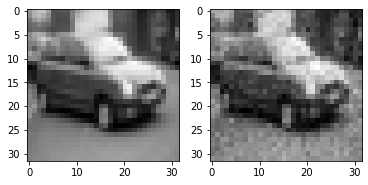

25  :  [0.8649882] 25
50  :  [0.8649882] 25
75  :  [0.9164101] 25
100  :  [0.92094696] 25
125  :  [0.92094696] 25
150  :  [0.9250605] 25
175  :  [0.9259529] 25
200  :  [0.9259529] 25
225  :  [0.9259529] 25
250  :  [0.9259529] 25
275  :  [0.9259529] 25
300  :  [0.9259529] 25
325  :  [0.9346945] 25
350  :  [0.9347462] 25
375  :  [0.93701255] 25
400  :  [0.93701255] 25
425  :  [0.93701255] 25
450  :  [0.9379767] 25
475  :  [0.9380168] 25
500  :  [0.94241965] 25
525  :  [0.94241965] 25
550  :  [0.94241965] 25
575  :  [0.94588923] 25
600  :  [0.9467052] 25
625  :  [0.9493018] 25
650  :  [0.9493018] 25
675  :  [0.9493018] 25
700  :  [0.95120096] 25
725  :  [0.95120096] 25
750  :  [0.95120096] 25
775  :  [0.9524224] 25
800  :  [0.95722574] 25
825  :  [0.95722574] 25
850  :  [0.95722574] 25
Time:  139.14808297157288  seconds
Original class:  1
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


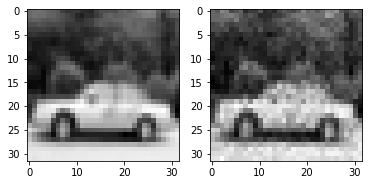

25  :  [0.74266374] 25
50  :  [0.7528658] 25
75  :  [0.7601304] 25
100  :  [0.7601304] 25
125  :  [0.7601304] 25
150  :  [0.8342135] 25
175  :  [0.8344526] 25
200  :  [0.8344526] 25
225  :  [0.8344526] 25
250  :  [0.8344526] 25
275  :  [0.8389891] 25
300  :  [0.83883464] 25
325  :  [0.83883464] 25
350  :  [0.83883464] 25
375  :  [0.83883464] 25
400  :  [0.83883464] 25
425  :  [0.83883464] 25
450  :  [0.83883464] 25
475  :  [0.83883464] 25
500  :  [0.84011984] 25
525  :  [0.84011984] 25
550  :  [0.84011984] 25
575  :  [0.84011984] 25
600  :  [0.84011984] 25
625  :  [0.84126955] 25
650  :  [0.84697706] 25
675  :  [0.84697706] 25
700  :  [0.8506058] 25
725  :  [0.8506058] 25
750  :  [0.8506058] 25
775  :  [0.8506058] 25
800  :  [0.8506058] 25
825  :  [0.8506058] 25
850  :  [0.85835844] 25
875  :  [0.85835844] 25
900  :  [0.85835844] 25
925  :  [0.8683958] 25
950  :  [0.87286973] 25
975  :  [0.87286973] 25
1000  :  [0.87286973] 25
1025  :  [0.87833923] 25
1050  :  [0.8784267] 25
1075  :  [

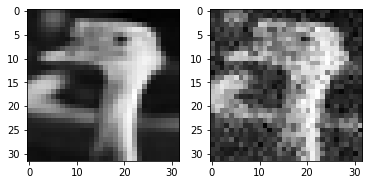

25  :  [0.93019724] 25
50  :  [0.93019724] 25
75  :  [0.9308226] 25
100  :  [0.9424795] 25
125  :  [0.958151] 25
150  :  [0.958151] 25
175  :  [0.958151] 25
200  :  [0.958151] 25
225  :  [0.958151] 25
250  :  [0.958151] 25
275  :  [0.95895594] 25
300  :  [0.95895594] 25
325  :  [0.95895594] 25
350  :  [0.9624537] 25
375  :  [0.96645653] 25
400  :  [0.96645653] 25
425  :  [0.96645653] 25
450  :  [0.9718293] 25
475  :  [0.973282] 25
500  :  [0.973282] 25
525  :  [0.973282] 25
550  :  [0.973282] 25
575  :  [0.97403276] 25
600  :  [0.974143] 25
625  :  [0.974568] 25
650  :  [0.97507024] 25
675  :  [0.97507024] 25
700  :  [0.9754075] 25
725  :  [0.9756779] 25
750  :  [0.9759379] 25
775  :  [0.976322] 25
800  :  [0.97640646] 25
825  :  [0.9765483] 25
850  :  [0.97705245] 25
875  :  [0.97705245] 25
900  :  [0.9771116] 25
Time:  154.33041715621948  seconds
Original class:  2
Prediction for normal image:  [6]
Prediction for adversarial image:  [6]


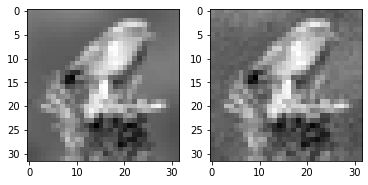

25  :  [0.916379] 25
50  :  [0.916379] 25
75  :  [0.9330496] 25
100  :  [0.9390459] 25
125  :  [0.9505917] 25
150  :  [0.9505917] 25
175  :  [0.9505917] 25
200  :  [0.9505917] 25
225  :  [0.9505917] 25
250  :  [0.95337284] 25
275  :  [0.95337284] 25
300  :  [0.95337284] 25
325  :  [0.95337284] 25
350  :  [0.95337284] 25
375  :  [0.95337284] 25
400  :  [0.95351756] 25
425  :  [0.95993876] 25
450  :  [0.9636905] 25
475  :  [0.9636905] 25
500  :  [0.9636905] 25
525  :  [0.96705943] 25
550  :  [0.96705943] 25
575  :  [0.9699787] 25
600  :  [0.9699787] 25
625  :  [0.9699787] 25
650  :  [0.97060657] 25
675  :  [0.9719274] 25
700  :  [0.97237766] 25
725  :  [0.9738047] 25
750  :  [0.9738047] 25
775  :  [0.97385263] 25
800  :  [0.97408265] 25
825  :  [0.97411966] 25
850  :  [0.9745356] 25
875  :  [0.9745356] 25
900  :  [0.9745356] 25
Time:  170.29625415802002  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [6]


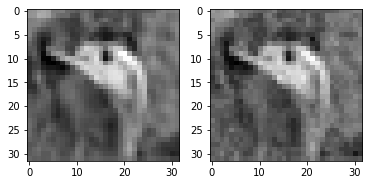

25  :  [0.7568236] 25
50  :  [0.82026154] 25
75  :  [0.8620844] 25
100  :  [0.8620844] 25
125  :  [0.8620844] 25
150  :  [0.8620844] 25
175  :  [0.8620844] 25
200  :  [0.8620844] 25
225  :  [0.8620844] 25
250  :  [0.8672551] 25
275  :  [0.8672551] 25
300  :  [0.8672551] 25
325  :  [0.8672551] 25
350  :  [0.8672551] 25
375  :  [0.8672551] 25
400  :  [0.8672551] 25


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in true_divide


425  :  [0.8672551] 25
450  :  [0.8672551] 25
475  :  [0.89493144] 25
500  :  [0.89493144] 25
525  :  [0.90696824] 25
550  :  [0.9122329] 25
575  :  [0.9122241] 25
600  :  [0.9122241] 25
625  :  [0.9122241] 25
650  :  [0.9122241] 25
675  :  [0.92047936] 25
700  :  [0.92222] 25
725  :  [0.92222] 25
750  :  [0.92253613] 25
775  :  [0.92328954] 25
800  :  [0.92408615] 25
825  :  [0.92636234] 25
850  :  [0.9273211] 25
875  :  [0.9273211] 25
900  :  [0.92843914] 25
925  :  [0.92843914] 25
950  :  [0.9287381] 25
975  :  [0.9301368] 25
1000  :  [0.93023443] 25
1025  :  [0.93023443] 25
1050  :  [0.930372] 25
1075  :  [0.93044806] 25
1100  :  [0.93075204] 25
1125  :  [0.9307664] 25
1150  :  [0.93094313] 25
1175  :  [0.9312276] 25
1199  :  [0.9312846] 24
1223  :  [0.9313266] 24
1247  :  [0.9315151] 24
1271  :  [0.93156564] 24
1295  :  [0.93156993] 24
Time:  227.64010524749756  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [6]


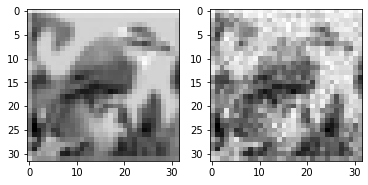

25  :  [0.7328718] 25
50  :  [0.7328718] 25
75  :  [0.6495439] 25
100  :  [0.70199704] 25
125  :  [0.7214888] 25
150  :  [0.73636025] 25
175  :  [0.73989725] 25
200  :  [0.75211453] 25
225  :  [0.75211453] 25
250  :  [0.75211453] 25
275  :  [0.75211453] 25
300  :  [0.7699564] 25
325  :  [0.7699564] 25
350  :  [0.7699564] 25
375  :  [0.7745632] 25
400  :  [0.7745632] 25
425  :  [0.78688955] 25
450  :  [0.7872839] 25
475  :  [0.80247474] 25
500  :  [0.8074495] 25
525  :  [0.80807906] 25
550  :  [0.8097064] 25
575  :  [0.81164503] 25
600  :  [0.8116473] 25
625  :  [0.81258523] 25
650  :  [0.8160084] 25
675  :  [0.81874293] 25
700  :  [0.8211987] 25
725  :  [0.825307] 25
750  :  [0.825307] 25
775  :  [0.825307] 25
800  :  [0.8261753] 25
825  :  [0.8269086] 25
850  :  [0.8287569] 25
875  :  [0.8305645] 25
900  :  [0.8322472] 25
925  :  [0.8323293] 25
950  :  [0.8323293] 25
975  :  [0.83236057] 25
1000  :  [0.83236057] 25
1025  :  [0.83276093] 25
1050  :  [0.8331726] 25
1075  :  [0.8336736] 

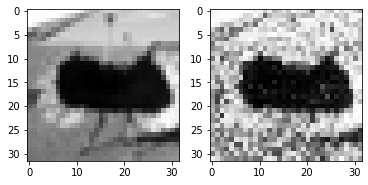

25  :  [0.49808475] 25
50  :  [0.6024141] 25
75  :  [0.6017996] 25
100  :  [0.6017996] 25
125  :  [0.6017996] 25
150  :  [0.6017996] 25
175  :  [0.6017996] 25
200  :  [0.6017996] 25
225  :  [0.6017996] 25
250  :  [0.6017996] 25
275  :  [0.62061375] 25
300  :  [0.62061375] 25
325  :  [0.62061375] 25
350  :  [0.62061375] 25
375  :  [0.6259011] 25
400  :  [0.6314085] 25
425  :  [0.6315004] 25
450  :  [0.6315004] 25
475  :  [0.6315004] 25
500  :  [0.6343441] 25
525  :  [0.6343441] 25
550  :  [0.6410738] 25
575  :  [0.64653766] 25
600  :  [0.65032846] 25
625  :  [0.65531397] 25
650  :  [0.65531397] 25
675  :  [0.6579635] 25
700  :  [0.6579635] 25
725  :  [0.6613097] 25
750  :  [0.66180253] 25
775  :  [0.6640622] 25
800  :  [0.6640622] 25
825  :  [0.6659138] 25
850  :  [0.6676246] 25
875  :  [0.6676458] 25
900  :  [0.6677927] 25
925  :  [0.66815823] 25
950  :  [0.66815823] 25
975  :  [0.6683048] 25
1000  :  [0.66857696] 25
1025  :  [0.66928756] 25
1050  :  [0.66928756] 25
Time:  182.83820128

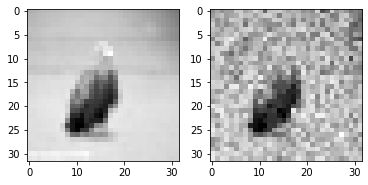

25  :  [0.7355957] 25
50  :  [0.7355957] 25
75  :  [0.7455543] 25
100  :  [0.7455543] 25
125  :  [0.7455543] 25
150  :  [0.7455543] 25
175  :  [0.7455543] 25
200  :  [0.7455543] 25
225  :  [0.7455543] 25
250  :  [0.7455543] 25
275  :  [0.7455543] 25
300  :  [0.7455543] 25
325  :  [0.7455543] 25
350  :  [0.7455543] 25
375  :  [0.7455543] 25
400  :  [0.7455543] 25
425  :  [0.7455543] 25
450  :  [0.7455543] 25
475  :  [0.7455543] 25
500  :  [0.7455543] 25
525  :  [0.7455543] 25
550  :  [0.7455543] 25
575  :  [0.7573351] 25
600  :  [0.75441146] 25
625  :  [0.75441146] 25
650  :  [0.75441146] 25
675  :  [0.75441146] 25
700  :  [0.75441146] 25
725  :  [0.75441146] 25
750  :  [0.75441146] 25
775  :  [0.75441146] 25
800  :  [0.75441146] 25
825  :  [0.75441146] 25
850  :  [0.75441146] 25
875  :  [0.75441146] 25
900  :  [0.75441146] 25
925  :  [0.75441146] 25
950  :  [0.75441146] 25
975  :  [0.75441146] 25
1000  :  [0.75441146] 25
1025  :  [0.75441146] 25
1050  :  [0.75441146] 25
1075  :  [0.754

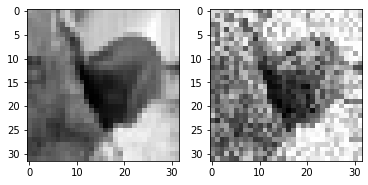

25  :  [0.69794446] 25
50  :  [0.69794446] 25
75  :  [0.7990068] 25
100  :  [0.7990068] 25
125  :  [0.7990068] 25
150  :  [0.7990068] 25
175  :  [0.7990068] 25
200  :  [0.7990068] 25
225  :  [0.8274189] 25
250  :  [0.8274189] 25
275  :  [0.8294357] 25
300  :  [0.8294151] 25
325  :  [0.8294151] 25
350  :  [0.8326452] 25
375  :  [0.8326272] 25
400  :  [0.8421831] 25
425  :  [0.8421831] 25
450  :  [0.8444305] 25
475  :  [0.8531772] 25
500  :  [0.8531772] 25
525  :  [0.8623818] 25
550  :  [0.8658016] 25
575  :  [0.8715446] 25
600  :  [0.8743125] 25
625  :  [0.8777629] 25
650  :  [0.8777629] 25
675  :  [0.8777629] 25
700  :  [0.8826461] 25
725  :  [0.8826461] 25
750  :  [0.8826461] 25
775  :  [0.8832234] 25
800  :  [0.88388515] 25
825  :  [0.8847878] 25
850  :  [0.8847878] 25
875  :  [0.8847878] 25
900  :  [0.8854449] 25
925  :  [0.885543] 25
950  :  [0.88569826] 25
975  :  [0.8865112] 25
1000  :  [0.8870082] 25
Time:  169.64976024627686  seconds
Original class:  2
Prediction for normal ima

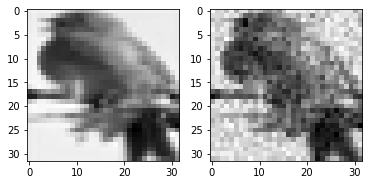

25  :  [0.6690342] 25
50  :  [0.6690342] 25
75  :  [0.63041586] 25
100  :  [0.67840356] 25
125  :  [0.7189863] 25
150  :  [0.73347056] 25
175  :  [0.73347056] 25
200  :  [0.73347056] 25
225  :  [0.73347056] 25
250  :  [0.73347056] 25
275  :  [0.73347056] 25
300  :  [0.73347056] 25
325  :  [0.73347056] 25
350  :  [0.73347056] 25
375  :  [0.7452528] 25
400  :  [0.754177] 25
425  :  [0.7551664] 25
450  :  [0.75506854] 25
475  :  [0.75506854] 25
500  :  [0.7616153] 25
525  :  [0.7826309] 25
550  :  [0.7826309] 25
575  :  [0.7826309] 25
600  :  [0.7826309] 25
625  :  [0.7870559] 25
650  :  [0.78703785] 25
675  :  [0.8056359] 25
700  :  [0.8056359] 25
725  :  [0.8056359] 25
750  :  [0.8056359] 25
775  :  [0.8056359] 25
800  :  [0.8146356] 25
825  :  [0.818708] 25
850  :  [0.8206457] 25
875  :  [0.8206457] 25
900  :  [0.8209197] 25
925  :  [0.8209197] 25
950  :  [0.82134795] 25
975  :  [0.82238] 25
1000  :  [0.82293224] 25
1025  :  [0.82397467] 25
1050  :  [0.8263563] 25
1075  :  [0.8263563] 

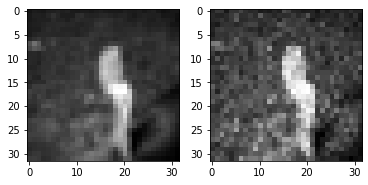

25  :  [0.89094615] 25
50  :  [0.9474019] 25
75  :  [0.94930017] 25
100  :  [0.94930017] 25
125  :  [0.94930017] 25
150  :  [0.9493158] 25
175  :  [0.94931537] 25
200  :  [0.94931537] 25
225  :  [0.9525031] 25
250  :  [0.9525556] 25
275  :  [0.95730054] 25
300  :  [0.95813626] 25
325  :  [0.95867294] 25
350  :  [0.9633988] 25
375  :  [0.9656407] 25
400  :  [0.9656407] 25
425  :  [0.9668598] 25
450  :  [0.9668598] 25
475  :  [0.9668598] 25
500  :  [0.96902776] 25
525  :  [0.9730363] 25
550  :  [0.9730363] 25
575  :  [0.9730363] 25
600  :  [0.9730363] 25
625  :  [0.97354656] 25
650  :  [0.97354656] 25
675  :  [0.97354656] 25
700  :  [0.97354656] 25
725  :  [0.97371596] 25
750  :  [0.975073] 25
775  :  [0.975073] 25
800  :  [0.97527796] 25
825  :  [0.97527796] 25
Time:  138.55955600738525  seconds
Original class:  2
Prediction for normal image:  [2]
Prediction for adversarial image:  [6]


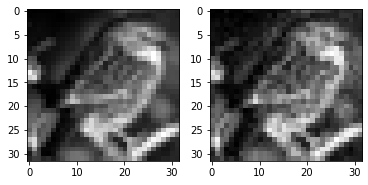

25  :  [0.79598415] 25
50  :  [0.79598415] 25
75  :  [0.79598415] 25
100  :  [0.79598415] 25
125  :  [0.79598415] 25
150  :  [0.8233143] 25
175  :  [0.8718038] 25
200  :  [0.89180785] 25
225  :  [0.89158964] 25
250  :  [0.89158964] 25
275  :  [0.89158964] 25
300  :  [0.89158964] 25
325  :  [0.89158964] 25
350  :  [0.89158964] 25
375  :  [0.89158964] 25
400  :  [0.91442513] 25
425  :  [0.91442513] 25
450  :  [0.91442513] 25
475  :  [0.91442513] 25
500  :  [0.91442513] 25
525  :  [0.91442513] 25
550  :  [0.92002755] 25
575  :  [0.92002755] 25
600  :  [0.92002755] 25
625  :  [0.92002755] 25
650  :  [0.92002755] 25
675  :  [0.92002755] 25
700  :  [0.92002755] 25
725  :  [0.92002755] 25
750  :  [0.95597786] 25
775  :  [0.95597786] 25
800  :  [0.95597786] 25
825  :  [0.95597786] 25
850  :  [0.95597786] 25
875  :  [0.9565518] 25
900  :  [0.9565518] 25
925  :  [0.9565518] 25
950  :  [0.9565518] 25
975  :  [0.95826507] 25
1000  :  [0.95826507] 25
1025  :  [0.95826507] 25
1050  :  [0.9635532] 25

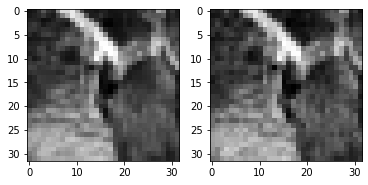

25  :  [0.6480084] 25
50  :  [0.6480084] 25
75  :  [0.49492675] 25
100  :  [0.62117773] 25
125  :  [0.63978237] 25
150  :  [0.658085] 25
175  :  [0.6699869] 25
200  :  [0.6699869] 25
225  :  [0.6699869] 25
250  :  [0.6699869] 25
275  :  [0.6751647] 25
300  :  [0.6751647] 25
325  :  [0.6762145] 25
350  :  [0.6751647] 25
375  :  [0.6840777] 25
400  :  [0.6840777] 25
425  :  [0.6840777] 25
450  :  [0.6840777] 25
475  :  [0.6840777] 25
500  :  [0.6840777] 25
525  :  [0.68817025] 25
550  :  [0.68817025] 25
575  :  [0.68817025] 25
600  :  [0.68817025] 25
625  :  [0.6910178] 25
650  :  [0.69648814] 25
675  :  [0.7087249] 25
700  :  [0.71034044] 25
725  :  [0.71357536] 25
750  :  [0.71347535] 25
775  :  [0.71347535] 25
800  :  [0.71347535] 25
825  :  [0.71347535] 25
850  :  [0.71347535] 25
875  :  [0.7156465] 25
900  :  [0.7156465] 25
925  :  [0.7156465] 25
950  :  [0.7232291] 25
975  :  [0.7232291] 25
1000  :  [0.7232291] 25
1025  :  [0.7232291] 25
1050  :  [0.7232291] 25
1075  :  [0.72498035

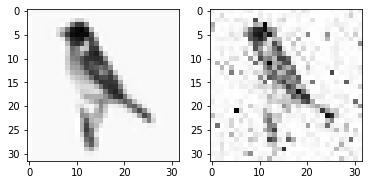

25  :  [0.69440496] 25
50  :  [0.69440496] 25
75  :  [0.6488646] 25
100  :  [0.6488646] 25
125  :  [0.6488646] 25
150  :  [0.6663072] 25
175  :  [0.664762] 25
200  :  [0.664762] 25
225  :  [0.664762] 25
250  :  [0.664762] 25
275  :  [0.664762] 25
300  :  [0.664762] 25
325  :  [0.664762] 25
350  :  [0.6663428] 25
375  :  [0.6649133] 25
400  :  [0.6649133] 25
425  :  [0.6649133] 25
450  :  [0.6765021] 25
475  :  [0.6765021] 25
500  :  [0.6765021] 25
525  :  [0.6765021] 25
550  :  [0.6765021] 25
575  :  [0.68618864] 25
600  :  [0.68995357] 25
625  :  [0.69361174] 25
650  :  [0.69361174] 25
675  :  [0.7014474] 25
700  :  [0.7146612] 25
725  :  [0.71463007] 25
750  :  [0.71463007] 25
775  :  [0.71463007] 25
800  :  [0.72175336] 25
825  :  [0.7318809] 25
850  :  [0.7329178] 25
875  :  [0.7329178] 25
900  :  [0.73938847] 25
925  :  [0.73938847] 25
950  :  [0.73938847] 25
975  :  [0.740208] 25
1000  :  [0.740208] 25
1025  :  [0.74042726] 25
1050  :  [0.74053186] 25
1075  :  [0.7405588] 25
1100

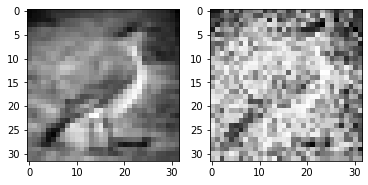

25  :  [0.34755707] 25
50  :  [0.54126686] 25
75  :  [0.55586004] 25
100  :  [0.47006968] 25
125  :  [0.49260223] 25
150  :  [0.5013693] 25
175  :  [0.5013693] 25
200  :  [0.50282574] 25
225  :  [0.51559913] 25
250  :  [0.5013693] 25
275  :  [0.5126425] 25
300  :  [0.5789465] 25
325  :  [0.5789465] 25
350  :  [0.5789465] 25
375  :  [0.5789465] 25
400  :  [0.5789465] 25
425  :  [0.5789465] 25
450  :  [0.5881318] 25
475  :  [0.5881318] 25
500  :  [0.5881318] 25
525  :  [0.5881318] 25
550  :  [0.5881318] 25
575  :  [0.5881318] 25
600  :  [0.5881318] 25
625  :  [0.5915065] 25
650  :  [0.5915065] 25
675  :  [0.5915065] 25
700  :  [0.5915065] 25
725  :  [0.6142053] 25
750  :  [0.61421263] 25
775  :  [0.61421263] 25
800  :  [0.61421263] 25
825  :  [0.61421263] 25
850  :  [0.61421263] 25
875  :  [0.61421263] 25
900  :  [0.6143161] 25
925  :  [0.6143464] 25
950  :  [0.6143464] 25
975  :  [0.6152502] 25
1000  :  [0.6152502] 25
1025  :  [0.6152502] 25
1050  :  [0.6152502] 25
1075  :  [0.6152502] 

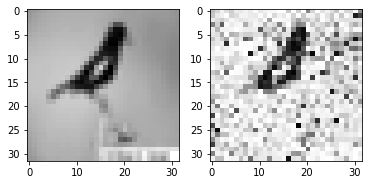

25  :  [0.9515935] 25
50  :  [0.9515935] 25
75  :  [0.9579573] 25
100  :  [0.96194845] 25
125  :  [0.96473163] 25
150  :  [0.96488464] 25
175  :  [0.9692534] 25
200  :  [0.9694811] 25
225  :  [0.97057784] 25
250  :  [0.97485423] 25
275  :  [0.9761815] 25
300  :  [0.9766936] 25
325  :  [0.97775066] 25
350  :  [0.97943556] 25
375  :  [0.97943556] 25
400  :  [0.98007274] 25
425  :  [0.98161775] 25
450  :  [0.98161775] 25
475  :  [0.98161775] 25
500  :  [0.9819249] 25
525  :  [0.9821943] 25
550  :  [0.9821943] 25
575  :  [0.9821943] 25
600  :  [0.98226756] 25
625  :  [0.982749] 25
650  :  [0.982749] 25
675  :  [0.98326945] 25
700  :  [0.98326945] 25
725  :  [0.98340213] 25
750  :  [0.98340213] 25
775  :  [0.98340213] 25
800  :  [0.98340213] 25
Time:  135.86973071098328  seconds
Original class:  3
Prediction for normal image:  [2]
Prediction for adversarial image:  [2]


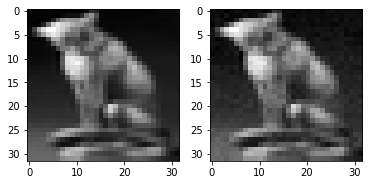

25  :  [0.8389598] 25
50  :  [0.8451519] 25
75  :  [0.8778578] 25
100  :  [0.87771] 25
125  :  [0.88058305] 25
150  :  [0.88058305] 25
175  :  [0.88058305] 25
200  :  [0.88058305] 25
225  :  [0.88058305] 25
250  :  [0.88058305] 25
275  :  [0.88058305] 25
300  :  [0.88058305] 25
325  :  [0.88058305] 25
350  :  [0.88058305] 25
375  :  [0.88847375] 25
400  :  [0.88834596] 25
425  :  [0.90016866] 25
450  :  [0.90016866] 25
475  :  [0.90038365] 25
500  :  [0.90038365] 25
525  :  [0.90038365] 25
550  :  [0.90038365] 25
575  :  [0.90306985] 25
600  :  [0.9121817] 25
625  :  [0.9121817] 25
650  :  [0.9121817] 25
675  :  [0.91223085] 25
700  :  [0.91223085] 25
725  :  [0.9130045] 25
750  :  [0.91455185] 25
775  :  [0.9150204] 25
800  :  [0.91783535] 25
825  :  [0.91913533] 25
850  :  [0.91979754] 25
875  :  [0.91979754] 25
900  :  [0.91979754] 25
925  :  [0.92043495] 25
950  :  [0.92043495] 25
975  :  [0.92043495] 25
1000  :  [0.9206917] 25
1025  :  [0.9208902] 25
1050  :  [0.9211116] 25
1075  

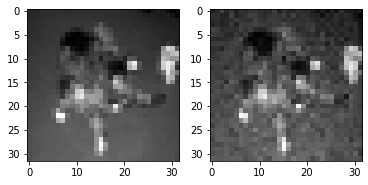

25  :  [0.674815] 25
50  :  [0.674815] 25
75  :  [0.85839903] 25
100  :  [0.9011694] 25
125  :  [0.9024486] 25
150  :  [0.9032545] 25
175  :  [0.92240036] 25
200  :  [0.92188704] 25
225  :  [0.92188704] 25
250  :  [0.92188704] 25
275  :  [0.92188704] 25
300  :  [0.92188704] 25
325  :  [0.92188704] 25
350  :  [0.92188704] 25
375  :  [0.93226784] 25
400  :  [0.9322326] 25
425  :  [0.93440485] 25
450  :  [0.9395928] 25
475  :  [0.9396608] 25
500  :  [0.94859576] 25
525  :  [0.9485954] 25
550  :  [0.9485954] 25
575  :  [0.9485954] 25
600  :  [0.9485954] 25
625  :  [0.9485954] 25
650  :  [0.9485954] 25
675  :  [0.9485954] 25
700  :  [0.9485954] 25
725  :  [0.9485954] 25
750  :  [0.9485954] 25
775  :  [0.94972694] 25
800  :  [0.94972694] 25
825  :  [0.9508099] 25
850  :  [0.95249057] 25
875  :  [0.95249057] 25
900  :  [0.95249057] 25
925  :  [0.95249057] 25
950  :  [0.95249057] 25
975  :  [0.9536045] 25
1000  :  [0.9536045] 25
1025  :  [0.95422095] 25
1050  :  [0.9542216] 25
1075  :  [0.9551

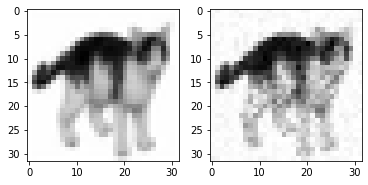

25  :  [0.7895588] 25
50  :  [0.79111385] 25
75  :  [0.8336248] 25
100  :  [0.8336248] 25
125  :  [0.8336248] 25
150  :  [0.8336248] 25
175  :  [0.8336248] 25
200  :  [0.8336248] 25
225  :  [0.8336248] 25
250  :  [0.84422797] 25
275  :  [0.8459412] 25
300  :  [0.8483088] 25
325  :  [0.8483088] 25
350  :  [0.8483088] 25
375  :  [0.8493043] 25
400  :  [0.8868116] 25
425  :  [0.8868242] 25
450  :  [0.8868242] 25
475  :  [0.8868242] 25
500  :  [0.8868242] 25
525  :  [0.8868242] 25
550  :  [0.8868242] 25
575  :  [0.8868242] 25
600  :  [0.8868242] 25
625  :  [0.8868242] 25
650  :  [0.8868242] 25
675  :  [0.8868242] 25
700  :  [0.8868242] 25
725  :  [0.89106476] 25
750  :  [0.89106476] 25
775  :  [0.89106476] 25
800  :  [0.89690864] 25
825  :  [0.89690864] 25
850  :  [0.89690864] 25
875  :  [0.89690864] 25
900  :  [0.9115288] 25
925  :  [0.9114373] 25
950  :  [0.9114373] 25
975  :  [0.9114373] 25
1000  :  [0.9121077] 25
1025  :  [0.9121077] 25
1050  :  [0.9121077] 25
1075  :  [0.9154936] 25
1

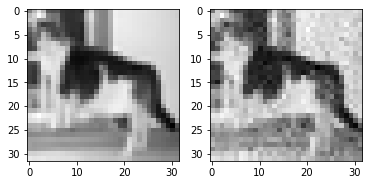

25  :  [0.9643185] 25
50  :  [0.9643185] 25
75  :  [0.9644507] 25
100  :  [0.9644507] 25
125  :  [0.9644507] 25
150  :  [0.9644507] 25
175  :  [0.9644507] 25
200  :  [0.9644507] 25
225  :  [0.9644507] 25
250  :  [0.9644507] 25
275  :  [0.96598625] 25
300  :  [0.96914655] 25
325  :  [0.9709728] 25
350  :  [0.970971] 25
375  :  [0.9728915] 25
400  :  [0.973284] 25
425  :  [0.98166245] 25
450  :  [0.98166245] 25
475  :  [0.98229855] 25
500  :  [0.9837592] 25
525  :  [0.98400617] 25
550  :  [0.98400617] 25
575  :  [0.98506516] 25
600  :  [0.9853904] 25
625  :  [0.98583055] 25
650  :  [0.98583055] 25
675  :  [0.9873364] 25
700  :  [0.98744106] 25
725  :  [0.9881277] 25
750  :  [0.98852825] 25
775  :  [0.98852825] 25
800  :  [0.98852825] 25
Time:  133.74705529212952  seconds
Original class:  3
Prediction for normal image:  [2]
Prediction for adversarial image:  [2]


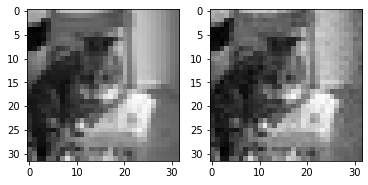

25  :  [0.93032193] 25
50  :  [0.93032193] 25
75  :  [0.93032193] 25
100  :  [0.93032193] 25
125  :  [0.93032193] 25
150  :  [0.93032193] 25
175  :  [0.93032193] 25
200  :  [0.9405204] 25
225  :  [0.9405204] 25
250  :  [0.9405204] 25
275  :  [0.9426507] 25
300  :  [0.9426507] 25
325  :  [0.94765973] 25
350  :  [0.94765973] 25
375  :  [0.94765973] 25
400  :  [0.94765973] 25
425  :  [0.94765973] 25
450  :  [0.94915736] 25
475  :  [0.9538809] 25
500  :  [0.9538809] 25
525  :  [0.9538809] 25
550  :  [0.9538809] 25
575  :  [0.9538809] 25
600  :  [0.96177655] 25
625  :  [0.96177655] 25
650  :  [0.96177655] 25
675  :  [0.96177655] 25
700  :  [0.96177655] 25
725  :  [0.9617846] 25
750  :  [0.9629934] 25
775  :  [0.9629934] 25
800  :  [0.9634753] 25
825  :  [0.9634753] 25
850  :  [0.9638392] 25
875  :  [0.9639833] 25
900  :  [0.9639833] 25
925  :  [0.9639833] 25
950  :  [0.9660671] 25
975  :  [0.9665433] 25
Time:  163.82967877388  seconds
Original class:  3
Prediction for normal image:  [3]
Pre

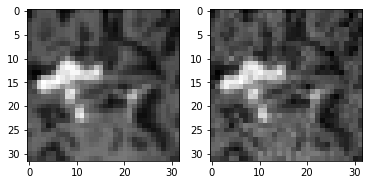

25  :  [0.70510614] 25
50  :  [0.75699806] 25
75  :  [0.76258624] 25
100  :  [0.74739337] 25
125  :  [0.7839213] 25
150  :  [0.7849945] 25
175  :  [0.7849945] 25
200  :  [0.7849945] 25
225  :  [0.7849945] 25
250  :  [0.8128935] 25
275  :  [0.8128935] 25
300  :  [0.8128935] 25
325  :  [0.8128935] 25
350  :  [0.8557399] 25
375  :  [0.85559344] 25
400  :  [0.85559344] 25
425  :  [0.85559344] 25
450  :  [0.85559344] 25
475  :  [0.85559344] 25
500  :  [0.85559344] 25
525  :  [0.85559344] 25
550  :  [0.85559344] 25
575  :  [0.85559344] 25
600  :  [0.85559344] 25
625  :  [0.85559344] 25
650  :  [0.85559344] 25
675  :  [0.8658738] 25
700  :  [0.8658738] 25
725  :  [0.8658738] 25
750  :  [0.8658738] 25
775  :  [0.8658738] 25
800  :  [0.86845565] 25
825  :  [0.8695182] 25
850  :  [0.87266785] 25
875  :  [0.87266785] 25
900  :  [0.87266785] 25
925  :  [0.8733492] 25
950  :  [0.8744027] 25
975  :  [0.8744027] 25
1000  :  [0.8751719] 25
1025  :  [0.8751719] 25
1050  :  [0.8751719] 25
1075  :  [0.87

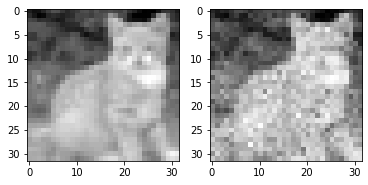

25  :  [0.8302219] 25
50  :  [0.8302219] 25
75  :  [0.8413502] 25
100  :  [0.8428968] 25
125  :  [0.8428968] 25
150  :  [0.8636687] 25
175  :  [0.86476946] 25
200  :  [0.86476946] 25
225  :  [0.86476946] 25
250  :  [0.86476946] 25
275  :  [0.86476946] 25
300  :  [0.86476946] 25
325  :  [0.86476946] 25
350  :  [0.86476946] 25
375  :  [0.86476946] 25
400  :  [0.86476946] 25
425  :  [0.86476946] 25
450  :  [0.86476946] 25
475  :  [0.86476946] 25
500  :  [0.86755747] 25
525  :  [0.86755747] 25
550  :  [0.86755747] 25
575  :  [0.8713897] 25
600  :  [0.8714118] 25
625  :  [0.8714118] 25
650  :  [0.87580454] 25
675  :  [0.87580454] 25
700  :  [0.87706804] 25
725  :  [0.87706804] 25
750  :  [0.8783405] 25
775  :  [0.881047] 25
800  :  [0.88879496] 25
825  :  [0.88879496] 25
850  :  [0.8964577] 25
875  :  [0.8964577] 25
900  :  [0.8964577] 25
925  :  [0.8969817] 25
Time:  156.2990493774414  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


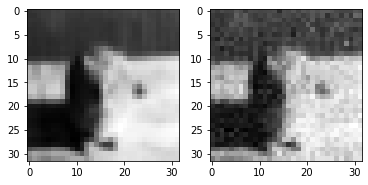

25  :  [0.6835989] 25
50  :  [0.6835989] 25
75  :  [0.6876063] 25
100  :  [0.6876063] 25
125  :  [0.6876063] 25
150  :  [0.6876063] 25
175  :  [0.6876063] 25
200  :  [0.6876063] 25
225  :  [0.6876063] 25
250  :  [0.6876063] 25
275  :  [0.6876063] 25
300  :  [0.6876063] 25
325  :  [0.7501576] 25
350  :  [0.75303656] 25
375  :  [0.75303656] 25
400  :  [0.75303656] 25
425  :  [0.75303656] 25
450  :  [0.75303656] 25
475  :  [0.75303656] 25
500  :  [0.75630796] 25
525  :  [0.7572199] 25
550  :  [0.7572199] 25
575  :  [0.7572199] 25
600  :  [0.7572199] 25
625  :  [0.7572199] 25
650  :  [0.76852477] 25
675  :  [0.76852477] 25
700  :  [0.7731083] 25
725  :  [0.7731083] 25
750  :  [0.7731083] 25
775  :  [0.7731083] 25
800  :  [0.7731083] 25
825  :  [0.7731083] 25
850  :  [0.7731083] 25
875  :  [0.7731083] 25
900  :  [0.7731083] 25
925  :  [0.7731083] 25
950  :  [0.7731083] 25
975  :  [0.7731083] 25
1000  :  [0.7731083] 25
1025  :  [0.7731083] 25
1050  :  [0.7731083] 25
1075  :  [0.7731083] 25
1

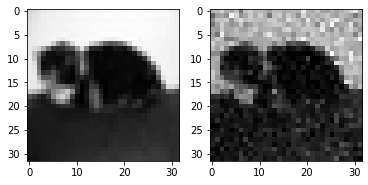

25  :  [0.84869415] 25
50  :  [0.89549494] 25
75  :  [0.89549494] 25
100  :  [0.91865873] 25
125  :  [0.9319724] 25
150  :  [0.9461494] 25
175  :  [0.9564091] 25
200  :  [0.9564091] 25
225  :  [0.9564091] 25
250  :  [0.9564091] 25
275  :  [0.95768404] 25
300  :  [0.95768404] 25
325  :  [0.95768404] 25
350  :  [0.95768404] 25
375  :  [0.95768404] 25
400  :  [0.95768404] 25
425  :  [0.95768404] 25
450  :  [0.95768404] 25
475  :  [0.95768404] 25
500  :  [0.95840937] 25
525  :  [0.9621351] 25
550  :  [0.9621351] 25
575  :  [0.9639453] 25
600  :  [0.9639453] 25
625  :  [0.9655495] 25
650  :  [0.9680143] 25
675  :  [0.96947426] 25
700  :  [0.96947426] 25
725  :  [0.97085506] 25
750  :  [0.97085506] 25
775  :  [0.9724479] 25
800  :  [0.97401476] 25
825  :  [0.97401476] 25
850  :  [0.9745836] 25
875  :  [0.97526413] 25
900  :  [0.97526413] 25
925  :  [0.975458] 25
950  :  [0.97545815] 25
Time:  161.1851842403412  seconds
Original class:  3
Prediction for normal image:  [3]
Prediction for adver

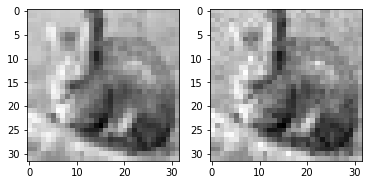

25  :  [0.7718928] 25
50  :  [0.812752] 25
75  :  [0.81536347] 25
100  :  [0.81536347] 25
125  :  [0.81536347] 25
150  :  [0.81536347] 25
175  :  [0.86517465] 25
200  :  [0.85744065] 25
225  :  [0.85744065] 25
250  :  [0.8609315] 25
275  :  [0.86524916] 25
300  :  [0.87644637] 25
325  :  [0.8762547] 25
350  :  [0.88707495] 25
375  :  [0.8876003] 25
400  :  [0.8837494] 25
425  :  [0.8837494] 25
450  :  [0.8837494] 25
475  :  [0.8853409] 25
500  :  [0.88496125] 25
525  :  [0.88496125] 25
550  :  [0.88496125] 25
575  :  [0.89634407] 25
600  :  [0.8959929] 25
625  :  [0.8959929] 25
650  :  [0.9115206] 25
675  :  [0.91122687] 25
700  :  [0.91122687] 25
725  :  [0.91122687] 25
750  :  [0.91122687] 25
775  :  [0.9174304] 25
800  :  [0.9173869] 25
825  :  [0.92042243] 25
850  :  [0.92265105] 25
875  :  [0.93188787] 25
900  :  [0.93350255] 25
925  :  [0.9335148] 25
950  :  [0.9335148] 25
975  :  [0.9335148] 25
1000  :  [0.9335148] 25
1025  :  [0.9335148] 25
1050  :  [0.9335148] 25
1075  :  [0.9

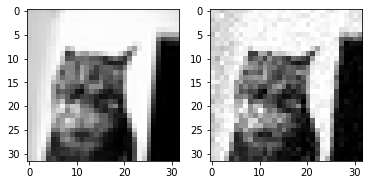

25  :  [0.95252955] 25
50  :  [0.95252955] 25
75  :  [0.9615942] 25
100  :  [0.9615942] 25
125  :  [0.96167004] 25
150  :  [0.9635175] 25
175  :  [0.97224724] 25
200  :  [0.97224724] 25
225  :  [0.9723596] 25
250  :  [0.97498095] 25
275  :  [0.97498095] 25
300  :  [0.97498095] 25
325  :  [0.9756825] 25
350  :  [0.9762402] 25
375  :  [0.976424] 25
400  :  [0.976424] 25
425  :  [0.9816592] 25
450  :  [0.9816592] 25
475  :  [0.9816592] 25
500  :  [0.9836788] 25
525  :  [0.9836788] 25
550  :  [0.9836788] 25
575  :  [0.9836788] 25
600  :  [0.9836788] 25
625  :  [0.98479784] 25
650  :  [0.9863308] 25
675  :  [0.9863308] 25
700  :  [0.9864032] 25
725  :  [0.9864032] 25
750  :  [0.9864032] 25
775  :  [0.9864919] 25
800  :  [0.9867128] 25
Time:  135.68814969062805  seconds
Original class:  3
Prediction for normal image:  [2]
Prediction for adversarial image:  [2]


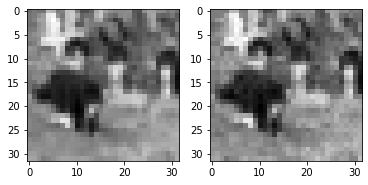

25  :  [0.96065724] 25
50  :  [0.96065724] 25
75  :  [0.9631675] 25
100  :  [0.9631675] 25
125  :  [0.9631675] 25
150  :  [0.9631675] 25
175  :  [0.9631675] 25
200  :  [0.9631675] 25
225  :  [0.9631675] 25
250  :  [0.9631675] 25
275  :  [0.9631675] 25
300  :  [0.9634751] 25
325  :  [0.96649337] 25
350  :  [0.96649337] 25
375  :  [0.9678895] 25
400  :  [0.9678895] 25
425  :  [0.97385913] 25
450  :  [0.97385913] 25
475  :  [0.97385913] 25
500  :  [0.97555065] 25
525  :  [0.97555065] 25
550  :  [0.97752404] 25
575  :  [0.97752404] 25
600  :  [0.979019] 25
625  :  [0.979019] 25
650  :  [0.97954] 25
675  :  [0.97987866] 25
700  :  [0.9804019] 25
725  :  [0.98060125] 25
750  :  [0.9808309] 25
775  :  [0.98135155] 25
800  :  [0.9814026] 25
Time:  137.65907907485962  seconds
Original class:  3
Prediction for normal image:  [5]
Prediction for adversarial image:  [6]


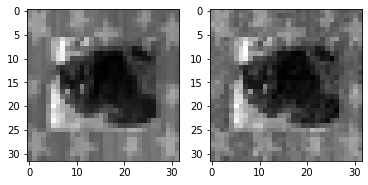

25  :  [0.79384285] 25
50  :  [0.81670266] 25
75  :  [0.85403293] 25
100  :  [0.85300064] 25
125  :  [0.8605286] 25
150  :  [0.8642312] 25
175  :  [0.8642312] 25
200  :  [0.8642312] 25
225  :  [0.8642312] 25
250  :  [0.8642312] 25
275  :  [0.8642312] 25
300  :  [0.8642312] 25
325  :  [0.8642312] 25
350  :  [0.8642312] 25
375  :  [0.8642312] 25
400  :  [0.8642312] 25
425  :  [0.86565626] 25
450  :  [0.86565626] 25
475  :  [0.86565626] 25
500  :  [0.86565626] 25
525  :  [0.87566376] 25
550  :  [0.87566376] 25
575  :  [0.87566376] 25
600  :  [0.87566376] 25
625  :  [0.88052136] 25
650  :  [0.8882302] 25
675  :  [0.8882302] 25
700  :  [0.8924326] 25
725  :  [0.8924326] 25
750  :  [0.8924326] 25
775  :  [0.8924326] 25
800  :  [0.89447993] 25
825  :  [0.8969364] 25
850  :  [0.8977176] 25
875  :  [0.89773893] 25
900  :  [0.89773893] 25
925  :  [0.8983271] 25
950  :  [0.9009532] 25
975  :  [0.90218085] 25
1000  :  [0.90218085] 25
1025  :  [0.90218085] 25
1050  :  [0.90218085] 25
1075  :  [0.90

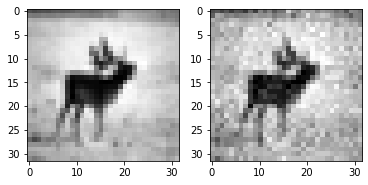

25  :  [0.87632036] 25
50  :  [0.87632036] 25
75  :  [0.8711607] 25
100  :  [0.8711607] 25
125  :  [0.8711607] 25
150  :  [0.8711607] 25
175  :  [0.8711607] 25
200  :  [0.8711607] 25
225  :  [0.8711607] 25
250  :  [0.8711607] 25
275  :  [0.8711607] 25
300  :  [0.8711607] 25
325  :  [0.8711607] 25
350  :  [0.8711607] 25
375  :  [0.898852] 25
400  :  [0.89819884] 25
425  :  [0.89819884] 25
450  :  [0.89819884] 25
475  :  [0.89819884] 25
500  :  [0.89819884] 25
525  :  [0.89819884] 25
550  :  [0.89819884] 25
575  :  [0.89819884] 25
600  :  [0.89819884] 25
625  :  [0.89819884] 25
650  :  [0.89819884] 25
675  :  [0.89819884] 25
700  :  [0.89819884] 25
725  :  [0.89819884] 25
750  :  [0.89819884] 25
775  :  [0.89819884] 25
800  :  [0.89819884] 25
825  :  [0.89819884] 25
850  :  [0.9012997] 25
875  :  [0.9012997] 25
900  :  [0.9012997] 25
925  :  [0.9012997] 25
950  :  [0.9012997] 25
975  :  [0.9012997] 25
1000  :  [0.9012997] 25
1025  :  [0.9012997] 25
1050  :  [0.9012997] 25
1075  :  [0.901

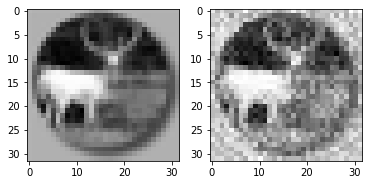

25  :  [0.93561745] 25
50  :  [0.93561745] 25
75  :  [0.93561745] 25
100  :  [0.94220126] 25
125  :  [0.94220126] 25
150  :  [0.94220126] 25
175  :  [0.94763875] 25
200  :  [0.94763875] 25
225  :  [0.9497132] 25
250  :  [0.9497132] 25
275  :  [0.955203] 25
300  :  [0.95740145] 25
325  :  [0.95740145] 25
350  :  [0.9587421] 25
375  :  [0.9608332] 25
400  :  [0.96395946] 25
425  :  [0.96395946] 25
450  :  [0.96395946] 25
475  :  [0.9675642] 25
500  :  [0.9675642] 25
525  :  [0.96812356] 25
550  :  [0.97102624] 25
575  :  [0.97102624] 25
600  :  [0.97248775] 25
625  :  [0.97248775] 25
650  :  [0.9727932] 25
675  :  [0.9727932] 25
700  :  [0.97310174] 25
725  :  [0.97310174] 25
750  :  [0.9737493] 25
775  :  [0.9737493] 25
800  :  [0.97433734] 25
Time:  138.12023997306824  seconds
Original class:  4
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


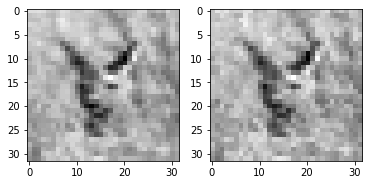

25  :  [0.8999671] 25
50  :  [0.9356787] 25
75  :  [0.94022995] 25
100  :  [0.9403285] 25
125  :  [0.94253063] 25
150  :  [0.94315445] 25
175  :  [0.94315445] 25
200  :  [0.94315445] 25
225  :  [0.94315445] 25
250  :  [0.94315445] 25
275  :  [0.94315445] 25
300  :  [0.94315445] 25
325  :  [0.94695544] 25
350  :  [0.94695544] 25
375  :  [0.94695544] 25
400  :  [0.95662916] 25
425  :  [0.95662916] 25
450  :  [0.95662916] 25
475  :  [0.95662916] 25
500  :  [0.9601735] 25
525  :  [0.9637254] 25
550  :  [0.96447885] 25
575  :  [0.96447885] 25
600  :  [0.9664426] 25
625  :  [0.96665865] 25
650  :  [0.96968544] 25
675  :  [0.9709239] 25
700  :  [0.9709239] 25
725  :  [0.9721864] 25
750  :  [0.9721864] 25
775  :  [0.97299576] 25
800  :  [0.9734056] 25
825  :  [0.97398114] 25
Time:  142.63812160491943  seconds
Original class:  4
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


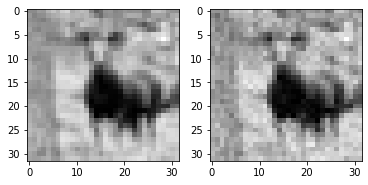

25  :  [0.7910185] 25
50  :  [0.7910185] 25
75  :  [0.8136133] 25
100  :  [0.8136133] 25
125  :  [0.8243662] 25
150  :  [0.834137] 25
175  :  [0.8508705] 25
200  :  [0.86891747] 25
225  :  [0.86891747] 25
250  :  [0.87070507] 25
275  :  [0.87356067] 25
300  :  [0.8908887] 25
325  :  [0.8908887] 25
350  :  [0.8908887] 25
375  :  [0.8928981] 25
400  :  [0.89614475] 25
425  :  [0.9062184] 25
450  :  [0.9062184] 25
475  :  [0.90831196] 25
500  :  [0.90831196] 25
525  :  [0.91393644] 25
550  :  [0.91583884] 25
575  :  [0.92059445] 25
600  :  [0.9279055] 25
625  :  [0.9279055] 25
650  :  [0.9279055] 25
675  :  [0.9295719] 25
700  :  [0.9296204] 25
725  :  [0.93267894] 25
750  :  [0.93267894] 25
775  :  [0.9343175] 25
800  :  [0.9343175] 25
825  :  [0.9348623] 25
850  :  [0.93558246] 25
875  :  [0.93558246] 25
900  :  [0.9356146] 25
925  :  [0.9359456] 25
950  :  [0.9365164] 25
975  :  [0.9365164] 25
1000  :  [0.9365164] 25
1025  :  [0.9367355] 25
1050  :  [0.93712354] 25
1075  :  [0.93712354

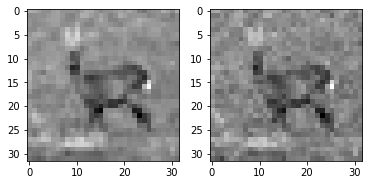

25  :  [0.8714961] 25
50  :  [0.8814757] 25
75  :  [0.88157284] 25
100  :  [0.88157284] 25
125  :  [0.88157284] 25
150  :  [0.88157284] 25
175  :  [0.88157284] 25
200  :  [0.89530396] 25
225  :  [0.89936537] 25
250  :  [0.90366507] 25
275  :  [0.90366507] 25
300  :  [0.9072683] 25
325  :  [0.9072683] 25
350  :  [0.9072683] 25
375  :  [0.9072683] 25
400  :  [0.9072683] 25
425  :  [0.91978717] 25
450  :  [0.92490447] 25
475  :  [0.92490447] 25
500  :  [0.92490447] 25
525  :  [0.92490447] 25
550  :  [0.92490447] 25
575  :  [0.92490447] 25
600  :  [0.92490447] 25
625  :  [0.9353994] 25
650  :  [0.9385655] 25
675  :  [0.9385655] 25
700  :  [0.9385655] 25
725  :  [0.9385655] 25
750  :  [0.9438825] 25
775  :  [0.9446263] 25
800  :  [0.9446263] 25
825  :  [0.94770205] 25
850  :  [0.9488212] 25
875  :  [0.94889987] 25
900  :  [0.94889987] 25
925  :  [0.9508738] 25
950  :  [0.9521602] 25
975  :  [0.9521602] 25
1000  :  [0.9521602] 25
1025  :  [0.9521602] 25
1050  :  [0.9521602] 25
1075  :  [0.95

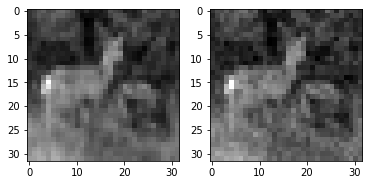

25  :  [0.91404915] 25
50  :  [0.91404915] 25
75  :  [0.93341255] 25
100  :  [0.9341903] 25
125  :  [0.93485457] 25
150  :  [0.93628013] 25
175  :  [0.94058406] 25
200  :  [0.9405885] 25
225  :  [0.9409268] 25
250  :  [0.9409268] 25
275  :  [0.9425751] 25
300  :  [0.94625306] 25
325  :  [0.94625306] 25
350  :  [0.95016813] 25
375  :  [0.95016813] 25
400  :  [0.9539858] 25
425  :  [0.9589807] 25
450  :  [0.9589807] 25
475  :  [0.9589807] 25
500  :  [0.9610374] 25
525  :  [0.9613298] 25
550  :  [0.9637581] 25
575  :  [0.96406615] 25
600  :  [0.96841764] 25
625  :  [0.96841764] 25
650  :  [0.9706985] 25
675  :  [0.9706985] 25
700  :  [0.9706985] 25
725  :  [0.97113925] 25
750  :  [0.97203815] 25
775  :  [0.97203815] 25
800  :  [0.9722929] 25
825  :  [0.9722929] 25
850  :  [0.9722929] 25
Time:  174.9403030872345  seconds
Original class:  4
Prediction for normal image:  [3]
Prediction for adversarial image:  [2]


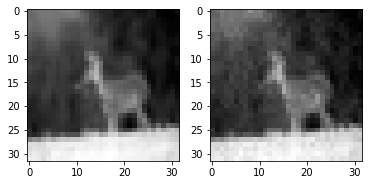

25  :  [0.30434114] 25
50  :  [0.5057758] 25
75  :  [0.5503415] 25
100  :  [0.5779296] 25
125  :  [0.6887629] 25
150  :  [0.71843237] 25
175  :  [0.7474884] 25
200  :  [0.76412493] 25
225  :  [0.76477855] 25
250  :  [0.79748654] 25
275  :  [0.8027904] 25
300  :  [0.8099911] 25
325  :  [0.81000525] 25
350  :  [0.8248337] 25
375  :  [0.8248337] 25
400  :  [0.8248337] 25
425  :  [0.8248337] 25
450  :  [0.8277595] 25
475  :  [0.8277595] 25
500  :  [0.8465461] 25
525  :  [0.8465461] 25
550  :  [0.8465461] 25
575  :  [0.8465461] 25
600  :  [0.8465461] 25
625  :  [0.8484968] 25
650  :  [0.8594179] 25
675  :  [0.8594179] 25
700  :  [0.8594179] 25
725  :  [0.8594179] 25
750  :  [0.863034] 25
775  :  [0.863034] 25
800  :  [0.8673203] 25
825  :  [0.8673203] 25
850  :  [0.8673203] 25
875  :  [0.8676306] 25
900  :  [0.8676306] 25
925  :  [0.8676306] 25
950  :  [0.8676306] 25
975  :  [0.8676306] 25
1000  :  [0.8676306] 25
1025  :  [0.8676306] 25
1050  :  [0.8676306] 25
1075  :  [0.8676306] 25
1100  

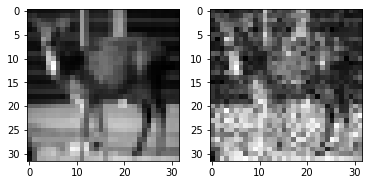

25  :  [0.8998313] 25
50  :  [0.8998313] 25
75  :  [0.89984924] 25
100  :  [0.89984924] 25
125  :  [0.89984924] 25
150  :  [0.89984924] 25
175  :  [0.89984924] 25
200  :  [0.89984924] 25
225  :  [0.9044549] 25
250  :  [0.9044549] 25
275  :  [0.9055581] 25
300  :  [0.9055581] 25
325  :  [0.9055581] 25
350  :  [0.9188019] 25
375  :  [0.9188019] 25
400  :  [0.9188019] 25
425  :  [0.9188019] 25
450  :  [0.9188019] 25
475  :  [0.92422473] 25
500  :  [0.92727995] 25
525  :  [0.93060017] 25
550  :  [0.93060076] 25
575  :  [0.9382719] 25
600  :  [0.9382719] 25
625  :  [0.94061714] 25
650  :  [0.94061714] 25
675  :  [0.94061714] 25
700  :  [0.94061714] 25
725  :  [0.94662905] 25
750  :  [0.94662905] 25
775  :  [0.94776905] 25
800  :  [0.949596] 25
825  :  [0.949596] 25
850  :  [0.949596] 25
875  :  [0.949596] 25
900  :  [0.9512782] 25
925  :  [0.9513163] 25
950  :  [0.9518534] 25
975  :  [0.95325124] 25
1000  :  [0.95325124] 25
1025  :  [0.95325124] 25
1050  :  [0.95325124] 25
1075  :  [0.95325

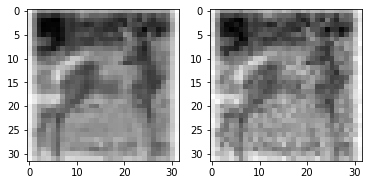

25  :  [0.86338127] 25
50  :  [0.86338127] 25
75  :  [0.86338127] 25
100  :  [0.86338127] 25
125  :  [0.86338127] 25
150  :  [0.86338127] 25
175  :  [0.86338127] 25
200  :  [0.86338127] 25
225  :  [0.86999834] 25
250  :  [0.8707361] 25
275  :  [0.870455] 25
300  :  [0.870455] 25
325  :  [0.88273257] 25
350  :  [0.9019865] 25
375  :  [0.90185857] 25
400  :  [0.90185857] 25
425  :  [0.90185857] 25
450  :  [0.90185857] 25
475  :  [0.9055762] 25
500  :  [0.91859686] 25
525  :  [0.91859686] 25
550  :  [0.91859686] 25
575  :  [0.91859686] 25
600  :  [0.91859686] 25
625  :  [0.9216009] 25
650  :  [0.9216009] 25
675  :  [0.9216009] 25
700  :  [0.9216009] 25
725  :  [0.9216009] 25
750  :  [0.9216009] 25
775  :  [0.9216009] 25
800  :  [0.9216009] 25
825  :  [0.9216009] 25
850  :  [0.9216009] 25
875  :  [0.9258564] 25
900  :  [0.9258564] 25
925  :  [0.92818797] 25
950  :  [0.9303216] 25
975  :  [0.9303216] 25
1000  :  [0.9303216] 25
1025  :  [0.9303216] 25
1050  :  [0.9303216] 25
1075  :  [0.9333

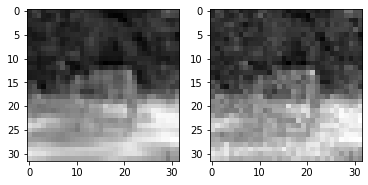

25  :  [0.9514136] 25
50  :  [0.9514136] 25
75  :  [0.9514136] 25
100  :  [0.9514136] 25
125  :  [0.9514136] 25
150  :  [0.9514136] 25
175  :  [0.9590268] 25
200  :  [0.9590268] 25
225  :  [0.96351576] 25
250  :  [0.96529704] 25
275  :  [0.96845424] 25
300  :  [0.9689906] 25
325  :  [0.9769603] 25
350  :  [0.9769603] 25
375  :  [0.9778548] 25
400  :  [0.98022944] 25
425  :  [0.9817288] 25
450  :  [0.9817288] 25
475  :  [0.9817288] 25
500  :  [0.98249453] 25
525  :  [0.98249453] 25
550  :  [0.9828124] 25
575  :  [0.9828124] 25
600  :  [0.9828124] 25
625  :  [0.98282874] 25
650  :  [0.98293924] 25
675  :  [0.98293924] 25
700  :  [0.98293924] 25
725  :  [0.9829549] 25
750  :  [0.9830531] 25
775  :  [0.98306316] 25
800  :  [0.9832373] 25
Time:  122.71425294876099  seconds
Original class:  4
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


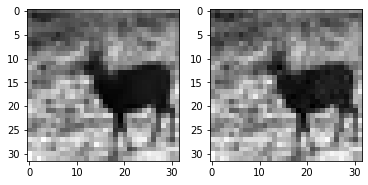

25  :  [0.913601] 25
50  :  [0.913601] 25
75  :  [0.913601] 25
100  :  [0.913601] 25
125  :  [0.913601] 25
150  :  [0.9164338] 25
175  :  [0.9271795] 25
200  :  [0.9271795] 25
225  :  [0.9271795] 25
250  :  [0.9271795] 25
275  :  [0.9271795] 25
300  :  [0.9271795] 25
325  :  [0.9271795] 25
350  :  [0.9271795] 25
375  :  [0.9271795] 25
400  :  [0.9271795] 25
425  :  [0.9309945] 25
450  :  [0.9309945] 25
475  :  [0.9324472] 25
500  :  [0.9324472] 25
525  :  [0.9337831] 25
550  :  [0.9338057] 25
575  :  [0.947475] 25
600  :  [0.9488381] 25
625  :  [0.9488381] 25
650  :  [0.9488381] 25
675  :  [0.9488381] 25
700  :  [0.9488381] 25
725  :  [0.94987196] 25
750  :  [0.94987196] 25
775  :  [0.94987196] 25
800  :  [0.95027006] 25
825  :  [0.9513674] 25
850  :  [0.9522975] 25
875  :  [0.9524973] 25
900  :  [0.9524973] 25
925  :  [0.9533217] 25
950  :  [0.9535019] 25
975  :  [0.9535019] 25
1000  :  [0.9535019] 25
1025  :  [0.9535019] 25
1050  :  [0.954011] 25
1075  :  [0.9543685] 25
1100  :  [0.9

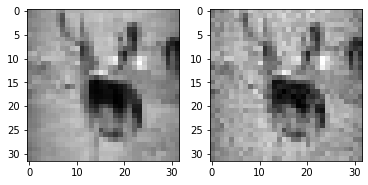

25  :  [0.8743583] 25
50  :  [0.8862269] 25
75  :  [0.8875145] 25
100  :  [0.8919589] 25
125  :  [0.9061835] 25
150  :  [0.90669847] 25
175  :  [0.90669847] 25
200  :  [0.9119167] 25
225  :  [0.93348026] 25
250  :  [0.9489219] 25
275  :  [0.9495662] 25
300  :  [0.9495662] 25
325  :  [0.9495662] 25
350  :  [0.9495662] 25
375  :  [0.9495662] 25
400  :  [0.9495662] 25
425  :  [0.9495662] 25
450  :  [0.9495662] 25
475  :  [0.94968456] 25
500  :  [0.9567703] 25
525  :  [0.9617084] 25
550  :  [0.9617084] 25
575  :  [0.9617084] 25
600  :  [0.9617084] 25
625  :  [0.9617084] 25
650  :  [0.9643638] 25
675  :  [0.96504736] 25
700  :  [0.96504736] 25
725  :  [0.96725535] 25
750  :  [0.9692733] 25
775  :  [0.9702343] 25
800  :  [0.9702599] 25
825  :  [0.9702599] 25
850  :  [0.9716009] 25
875  :  [0.9716009] 25
900  :  [0.97261745] 25
925  :  [0.97261745] 25
950  :  [0.97261745] 25
975  :  [0.97261745] 25
1000  :  [0.97261745] 25
1025  :  [0.9733807] 25
Time:  170.7023730278015  seconds
Original cla

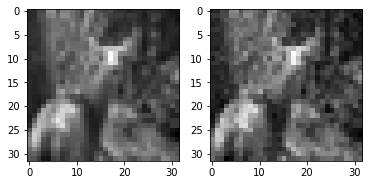

25  :  [0.83845353] 25
50  :  [0.83845353] 25
75  :  [0.83845353] 25
100  :  [0.8409988] 25
125  :  [0.8409988] 25
150  :  [0.8422479] 25
175  :  [0.84562314] 25
200  :  [0.86195636] 25
225  :  [0.87297344] 25
250  :  [0.8803853] 25
275  :  [0.8803853] 25
300  :  [0.88596773] 25
325  :  [0.8904637] 25
350  :  [0.89535844] 25
375  :  [0.8967077] 25
400  :  [0.9027513] 25
425  :  [0.9027513] 25
450  :  [0.9032595] 25
475  :  [0.9052765] 25
500  :  [0.9076092] 25
525  :  [0.910528] 25
550  :  [0.91132945] 25
575  :  [0.91396654] 25
600  :  [0.916623] 25
625  :  [0.916623] 25
650  :  [0.916623] 25
675  :  [0.91777676] 25
700  :  [0.91777676] 25
725  :  [0.91817296] 25
750  :  [0.9185189] 25
775  :  [0.9185972] 25
800  :  [0.91925585] 25
825  :  [0.9195725] 25
850  :  [0.92092115] 25
875  :  [0.9217575] 25
900  :  [0.92276746] 25
925  :  [0.92276746] 25
950  :  [0.92276746] 25
975  :  [0.92276746] 25
1000  :  [0.9228071] 25
Time:  148.17078924179077  seconds
Original class:  4
Prediction fo

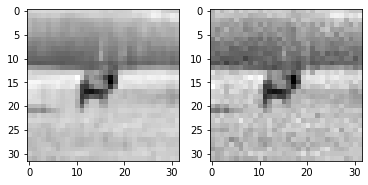

25  :  [0.80909395] 25
50  :  [0.8225229] 25
75  :  [0.8316382] 25
100  :  [0.85041296] 25
125  :  [0.85693955] 25
150  :  [0.85693955] 25
175  :  [0.8583878] 25
200  :  [0.8829969] 25
225  :  [0.8829969] 25
250  :  [0.89367783] 25
275  :  [0.89367783] 25
300  :  [0.89367783] 25
325  :  [0.89367783] 25
350  :  [0.9216261] 25
375  :  [0.9216261] 25
400  :  [0.9216261] 25
425  :  [0.9216261] 25
450  :  [0.9233178] 25
475  :  [0.92458] 25
500  :  [0.92458] 25
525  :  [0.9353428] 25
550  :  [0.9353428] 25
575  :  [0.9353428] 25
600  :  [0.9353428] 25
625  :  [0.9353428] 25
650  :  [0.9353428] 25
675  :  [0.9376732] 25
700  :  [0.9376732] 25
725  :  [0.9376732] 25
750  :  [0.9376732] 25
775  :  [0.9378853] 25
800  :  [0.9378853] 25
825  :  [0.937948] 25
850  :  [0.9401769] 25
875  :  [0.94113433] 25
900  :  [0.94174445] 25
925  :  [0.94179904] 25
950  :  [0.9424445] 25
975  :  [0.9436919] 25
1000  :  [0.9436919] 25
1025  :  [0.9440223] 25
1050  :  [0.94452506] 25
1075  :  [0.944647] 25
1100

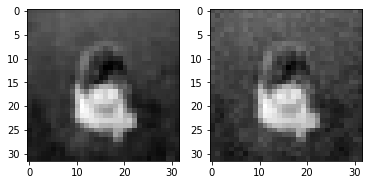

25  :  [0.8172606] 25
50  :  [0.8172606] 25
75  :  [0.8210983] 25
100  :  [0.8210983] 25
125  :  [0.8210983] 25
150  :  [0.8297318] 25
175  :  [0.8297318] 25
200  :  [0.8347129] 25
225  :  [0.8389151] 25
250  :  [0.8515378] 25
275  :  [0.8618833] 25
300  :  [0.8618833] 25
325  :  [0.8618833] 25
350  :  [0.8618833] 25
375  :  [0.8618833] 25
400  :  [0.8618833] 25
425  :  [0.8618833] 25
450  :  [0.87865937] 25
475  :  [0.87865937] 25
500  :  [0.88120174] 25
525  :  [0.88120174] 25
550  :  [0.88120174] 25
575  :  [0.8889537] 25
600  :  [0.8911666] 25
625  :  [0.8911666] 25
650  :  [0.8911666] 25
675  :  [0.89249027] 25
700  :  [0.8938236] 25
725  :  [0.8938236] 25
750  :  [0.89632785] 25
775  :  [0.89632785] 25
800  :  [0.89632785] 25
825  :  [0.90295935] 25
850  :  [0.90295935] 25
875  :  [0.90295935] 25
900  :  [0.90295935] 25
925  :  [0.90295935] 25
950  :  [0.90406317] 25
975  :  [0.90445006] 25
1000  :  [0.90445006] 25
1025  :  [0.90445006] 25
1050  :  [0.9045769] 25
1075  :  [0.9049

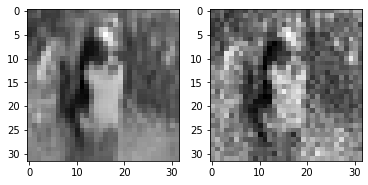

25  :  [0.9053969] 25
50  :  [0.9053969] 25
75  :  [0.91166866] 25
100  :  [0.91166866] 25
125  :  [0.9154866] 25
150  :  [0.9154866] 25
175  :  [0.9211707] 25
200  :  [0.9341935] 25
225  :  [0.93446803] 25
250  :  [0.93446803] 25
275  :  [0.9346652] 25
300  :  [0.9346652] 25
325  :  [0.9398775] 25
350  :  [0.9398775] 25
375  :  [0.9454969] 25
400  :  [0.9492961] 25
425  :  [0.9492961] 25
450  :  [0.95130265] 25
475  :  [0.955364] 25
500  :  [0.955364] 25
525  :  [0.9563091] 25
550  :  [0.9563091] 25
575  :  [0.9563091] 25
600  :  [0.95668626] 25
625  :  [0.9583535] 25
650  :  [0.95861185] 25
675  :  [0.9591031] 25
700  :  [0.9603962] 25
725  :  [0.9603962] 25
750  :  [0.96136224] 25
775  :  [0.96136224] 25
800  :  [0.9616754] 25
825  :  [0.9616754] 25
850  :  [0.961835] 25
875  :  [0.9620892] 25
900  :  [0.96236396] 25
925  :  [0.9624522] 25
950  :  [0.9626361] 25
975  :  [0.9631768] 25
Time:  145.14461755752563  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction 

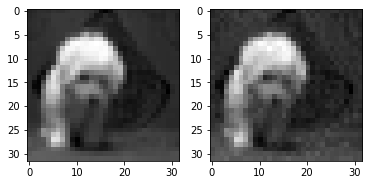

25  :  [0.91570693] 25
50  :  [0.9289434] 25
75  :  [0.9289441] 25
100  :  [0.9289441] 25
125  :  [0.9289441] 25
150  :  [0.9289441] 25
175  :  [0.9289441] 25
200  :  [0.9289441] 25
225  :  [0.9289441] 25
250  :  [0.9289441] 25
275  :  [0.93464285] 25
300  :  [0.93464285] 25
325  :  [0.93552786] 25
350  :  [0.9414177] 25
375  :  [0.9433341] 25
400  :  [0.9433341] 25
425  :  [0.94503593] 25
450  :  [0.94503593] 25
475  :  [0.94796693] 25
500  :  [0.94796693] 25
525  :  [0.94796693] 25
550  :  [0.9536008] 25
575  :  [0.9536008] 25
600  :  [0.953784] 25
625  :  [0.9546491] 25
650  :  [0.95667505] 25
675  :  [0.9578471] 25
700  :  [0.9578471] 25
725  :  [0.9578471] 25
750  :  [0.9589336] 25
775  :  [0.95981383] 25
800  :  [0.9606165] 25
825  :  [0.9606165] 25
Time:  122.71819281578064  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


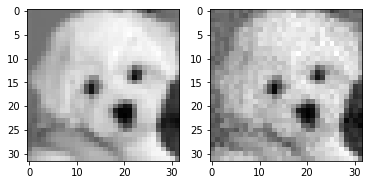

25  :  [0.94503075] 25
50  :  [0.9542971] 25
75  :  [0.9542971] 25
100  :  [0.9542971] 25
125  :  [0.9542971] 25
150  :  [0.9595736] 25
175  :  [0.9596431] 25
200  :  [0.9625864] 25
225  :  [0.96488] 25
250  :  [0.96871495] 25
275  :  [0.96871495] 25
300  :  [0.96944284] 25
325  :  [0.97344416] 25
350  :  [0.9754907] 25
375  :  [0.9791938] 25
400  :  [0.9791938] 25
425  :  [0.9791938] 25
450  :  [0.9800056] 25
475  :  [0.9800056] 25
500  :  [0.9800056] 25
525  :  [0.9800056] 25
550  :  [0.9800056] 25
575  :  [0.9804406] 25
600  :  [0.98163414] 25
625  :  [0.98163414] 25
650  :  [0.98163414] 25
675  :  [0.98196197] 25
700  :  [0.9821359] 25
725  :  [0.9822484] 25
750  :  [0.9822484] 25
775  :  [0.9822607] 25
800  :  [0.9823395] 25
Time:  119.66160297393799  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


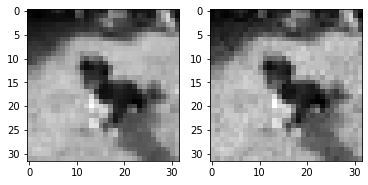

25  :  [0.9246635] 25
50  :  [0.9246635] 25
75  :  [0.9295146] 25
100  :  [0.9372847] 25
125  :  [0.9372847] 25
150  :  [0.94349337] 25
175  :  [0.94577765] 25
200  :  [0.94971335] 25
225  :  [0.94971335] 25
250  :  [0.94971335] 25
275  :  [0.94971335] 25
300  :  [0.94971335] 25
325  :  [0.94971335] 25
350  :  [0.95667946] 25
375  :  [0.95845056] 25
400  :  [0.95845056] 25
425  :  [0.9600502] 25
450  :  [0.9615618] 25
475  :  [0.96276474] 25
500  :  [0.964827] 25
525  :  [0.966413] 25
550  :  [0.96664023] 25
575  :  [0.96664023] 25
600  :  [0.96703184] 25
625  :  [0.9687986] 25
650  :  [0.9689294] 25
675  :  [0.96979296] 25
700  :  [0.97215563] 25
725  :  [0.97215563] 25
750  :  [0.97215563] 25
775  :  [0.9722161] 25
800  :  [0.97257876] 25
Time:  119.20405721664429  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


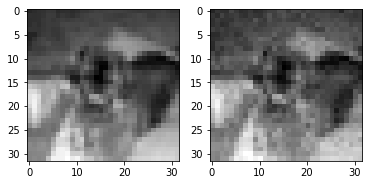

25  :  [0.85917157] 25
50  :  [0.85917157] 25
75  :  [0.90443313] 25
100  :  [0.90630084] 25
125  :  [0.90630084] 25
150  :  [0.90630084] 25
175  :  [0.90630084] 25
200  :  [0.90630084] 25
225  :  [0.90630084] 25
250  :  [0.90630084] 25
275  :  [0.90630084] 25
300  :  [0.91229916] 25
325  :  [0.91590977] 25
350  :  [0.9158468] 25
375  :  [0.9158468] 25
400  :  [0.9158468] 25
425  :  [0.9158468] 25
450  :  [0.9189249] 25
475  :  [0.921579] 25
500  :  [0.9243755] 25
525  :  [0.92514634] 25
550  :  [0.92514634] 25
575  :  [0.92559034] 25
600  :  [0.92559034] 25
625  :  [0.92559034] 25
650  :  [0.92559034] 25
675  :  [0.92559034] 25
700  :  [0.92572945] 25
725  :  [0.9275254] 25
750  :  [0.9283632] 25
775  :  [0.9283632] 25
800  :  [0.9283632] 25
825  :  [0.92933786] 25
850  :  [0.92988646] 25
Time:  127.66979765892029  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [2]


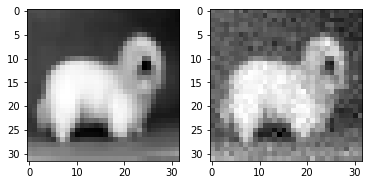

25  :  [0.9337894] 25
50  :  [0.9337894] 25
75  :  [0.93938637] 25
100  :  [0.93814003] 25
125  :  [0.94426024] 25
150  :  [0.9602542] 25
175  :  [0.9603455] 25
200  :  [0.9603455] 25
225  :  [0.96038854] 25
250  :  [0.96194553] 25
275  :  [0.96197486] 25
300  :  [0.96197486] 25
325  :  [0.96197486] 25
350  :  [0.96197486] 25
375  :  [0.96197486] 25
400  :  [0.96197486] 25
425  :  [0.9620277] 25
450  :  [0.9634962] 25
475  :  [0.965641] 25
500  :  [0.96603036] 25
525  :  [0.969286] 25
550  :  [0.969286] 25
575  :  [0.9700043] 25
600  :  [0.9699986] 25
625  :  [0.9705779] 25
650  :  [0.9705779] 25
675  :  [0.9734148] 25
700  :  [0.9734148] 25
725  :  [0.9748945] 25
750  :  [0.9756608] 25
775  :  [0.9756608] 25
800  :  [0.9769193] 25
825  :  [0.9769666] 25
850  :  [0.9777113] 25
875  :  [0.97818136] 25
900  :  [0.97818136] 25
925  :  [0.9782189] 25
Time:  138.31860184669495  seconds
Original class:  5
Prediction for normal image:  [3]
Prediction for adversarial image:  [6]


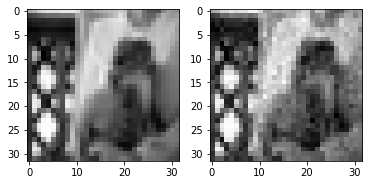

25  :  [0.8019205] 25
50  :  [0.8999237] 25
75  :  [0.8973673] 25
100  :  [0.8973673] 25
125  :  [0.9015094] 25
150  :  [0.9014932] 25
175  :  [0.9014932] 25
200  :  [0.90630007] 25
225  :  [0.9044423] 25
250  :  [0.92677176] 25
275  :  [0.9268631] 25
300  :  [0.92685974] 25
325  :  [0.9285555] 25
350  :  [0.9285555] 25
375  :  [0.93789184] 25
400  :  [0.9365064] 25
425  :  [0.9365064] 25
450  :  [0.9365064] 25
475  :  [0.9365064] 25
500  :  [0.9365064] 25
525  :  [0.9365064] 25
550  :  [0.9365064] 25
575  :  [0.9365064] 25
600  :  [0.93756765] 25
625  :  [0.93756765] 25
650  :  [0.93756765] 25
675  :  [0.93756765] 25
700  :  [0.93756765] 25
725  :  [0.9380494] 25
750  :  [0.9450549] 25
775  :  [0.94677025] 25
800  :  [0.9474195] 25
825  :  [0.94773763] 25
850  :  [0.94773763] 25
875  :  [0.94773763] 25
900  :  [0.9477516] 25
925  :  [0.9485816] 25
950  :  [0.9491266] 25
975  :  [0.94915706] 25
1000  :  [0.9494104] 25
1025  :  [0.9494104] 25
Time:  154.56215167045593  seconds
Original 

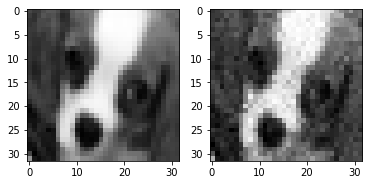

25  :  [0.8923454] 25
50  :  [0.8923454] 25
75  :  [0.92291474] 25
100  :  [0.9229442] 25
125  :  [0.9304905] 25
150  :  [0.93071175] 25
175  :  [0.93071175] 25
200  :  [0.93071175] 25
225  :  [0.93071175] 25
250  :  [0.9439331] 25
275  :  [0.94396067] 25
300  :  [0.94396067] 25
325  :  [0.94396067] 25
350  :  [0.94396067] 25
375  :  [0.94396067] 25
400  :  [0.9496538] 25
425  :  [0.94989306] 25
450  :  [0.94989306] 25
475  :  [0.9500265] 25
500  :  [0.9534266] 25
525  :  [0.9534266] 25
550  :  [0.95433426] 25
575  :  [0.955997] 25
600  :  [0.955997] 25
625  :  [0.9577476] 25
650  :  [0.9584891] 25
675  :  [0.9588801] 25
700  :  [0.9603334] 25
725  :  [0.9603334] 25
750  :  [0.9603334] 25
775  :  [0.96059483] 25
800  :  [0.96148956] 25
825  :  [0.96179414] 25
850  :  [0.96179414] 25
875  :  [0.9618895] 25
900  :  [0.9619151] 25
925  :  [0.9619641] 25
950  :  [0.96204937] 25
975  :  [0.96218145] 25
1000  :  [0.96218145] 25
1025  :  [0.96236193] 25
Time:  153.11160922050476  seconds
Orig

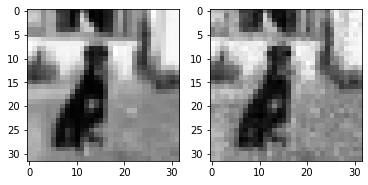

25  :  [0.92628694] 25
50  :  [0.92628694] 25
75  :  [0.92628694] 25
100  :  [0.92628694] 25
125  :  [0.92628694] 25
150  :  [0.92628694] 25
175  :  [0.92628694] 25
200  :  [0.92628694] 25
225  :  [0.92628694] 25
250  :  [0.92628694] 25
275  :  [0.92628694] 25
300  :  [0.92628694] 25
325  :  [0.92628694] 25
350  :  [0.92628694] 25
375  :  [0.92628694] 25
400  :  [0.92628694] 25
425  :  [0.92628694] 25
450  :  [0.92628694] 25
475  :  [0.92628694] 25
500  :  [0.92628694] 25
525  :  [0.92628694] 25
550  :  [0.930285] 25
575  :  [0.9397106] 25
600  :  [0.94118536] 25
625  :  [0.94116867] 25
650  :  [0.94116867] 25
675  :  [0.94454837] 25
700  :  [0.9445505] 25
725  :  [0.9445505] 25
750  :  [0.9445505] 25
775  :  [0.9445505] 25
800  :  [0.9445505] 25
Time:  119.02124667167664  seconds
Original class:  5
Prediction for normal image:  [7]
Prediction for adversarial image:  [4]


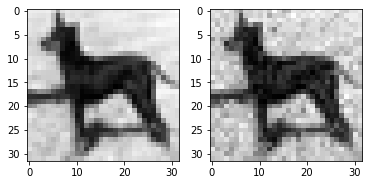

25  :  [0.9350574] 25
50  :  [0.9350574] 25
75  :  [0.93588114] 25
100  :  [0.9394841] 25
125  :  [0.94354653] 25
150  :  [0.94357675] 25
175  :  [0.94357675] 25
200  :  [0.94357675] 25
225  :  [0.94357675] 25
250  :  [0.9437344] 25
275  :  [0.9437566] 25
300  :  [0.9440106] 25
325  :  [0.9440142] 25
350  :  [0.9470774] 25
375  :  [0.95222265] 25
400  :  [0.95279396] 25
425  :  [0.95318896] 25
450  :  [0.96067107] 25
475  :  [0.9606978] 25
500  :  [0.96067107] 25
525  :  [0.96236223] 25
550  :  [0.96353537] 25
575  :  [0.96353537] 25
600  :  [0.96353537] 25
625  :  [0.96353537] 25
650  :  [0.96398854] 25
675  :  [0.9645905] 25
700  :  [0.96634126] 25
725  :  [0.9665203] 25
750  :  [0.9668252] 25
775  :  [0.9668252] 25
800  :  [0.9671496] 25
Time:  119.04537653923035  seconds
Original class:  5
Prediction for normal image:  [5]
Prediction for adversarial image:  [3]


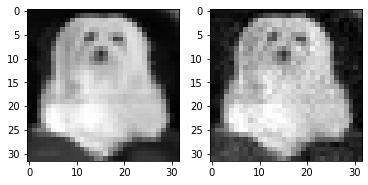

25  :  [0.8765827] 25
50  :  [0.90050983] 25
75  :  [0.92262936] 25
100  :  [0.9241681] 25
125  :  [0.9243054] 25
150  :  [0.9243054] 25
175  :  [0.931729] 25
200  :  [0.937335] 25
225  :  [0.9417553] 25
250  :  [0.94252485] 25
275  :  [0.95197713] 25
300  :  [0.950896] 25
325  :  [0.950896] 25
350  :  [0.9565407] 25
375  :  [0.9570328] 25
400  :  [0.9570328] 25
425  :  [0.95732427] 25
450  :  [0.96179515] 25
475  :  [0.9637428] 25
500  :  [0.96444833] 25
525  :  [0.96444833] 25
550  :  [0.97136116] 25
575  :  [0.9719922] 25
600  :  [0.9725117] 25
625  :  [0.9725117] 25
650  :  [0.973276] 25
675  :  [0.97422564] 25
700  :  [0.9748646] 25
725  :  [0.9774231] 25
750  :  [0.9774231] 25
775  :  [0.9775145] 25
800  :  [0.9775145] 25
825  :  [0.9775145] 25
850  :  [0.9775145] 25
Time:  125.90451240539551  seconds
Original class:  5
Prediction for normal image:  [3]
Prediction for adversarial image:  [3]


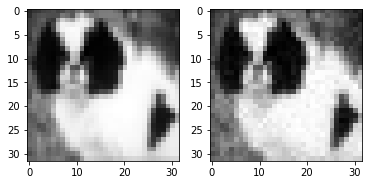

25  :  [0.9177431] 25
50  :  [0.92176974] 25
75  :  [0.92159885] 25
100  :  [0.92290986] 25
125  :  [0.92383945] 25
150  :  [0.93713] 25
175  :  [0.94351447] 25
200  :  [0.94351447] 25
225  :  [0.94351447] 25
250  :  [0.9436207] 25
275  :  [0.94836694] 25
300  :  [0.94836694] 25
325  :  [0.94836694] 25
350  :  [0.94836694] 25
375  :  [0.94836694] 25
400  :  [0.9506781] 25
425  :  [0.95247173] 25
450  :  [0.95247173] 25
475  :  [0.95379215] 25
500  :  [0.95379215] 25
525  :  [0.95379215] 25
550  :  [0.95526326] 25
575  :  [0.9572462] 25
600  :  [0.9572462] 25
625  :  [0.95757985] 25
650  :  [0.95978856] 25
675  :  [0.9609553] 25
700  :  [0.9609553] 25
725  :  [0.96111125] 25
750  :  [0.96111125] 25
775  :  [0.96111125] 25
800  :  [0.9611658] 25
825  :  [0.9612191] 25
850  :  [0.9618137] 25
875  :  [0.9618137] 25
900  :  [0.9624647] 25
925  :  [0.96268034] 25
Time:  138.14735460281372  seconds
Original class:  5
Prediction for normal image:  [3]
Prediction for adversarial image:  [3]


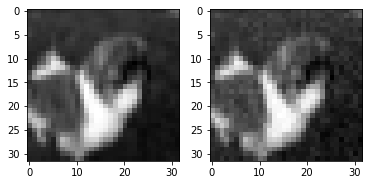

25  :  [0.47619396] 25
50  :  [0.47619396] 25
75  :  [0.62267864] 25
100  :  [0.58405995] 25
125  :  [0.6391808] 25
150  :  [0.6373857] 25
175  :  [0.6373857] 25
200  :  [0.70171833] 25
225  :  [0.70171833] 25
250  :  [0.70171833] 25
275  :  [0.70171833] 25
300  :  [0.70171833] 25
325  :  [0.70171833] 25
350  :  [0.70171833] 25
375  :  [0.70171833] 25
400  :  [0.70171833] 25
425  :  [0.70171833] 25
450  :  [0.7972816] 25
475  :  [0.7972816] 25
500  :  [0.7972816] 25
525  :  [0.7972816] 25
550  :  [0.7972816] 25
575  :  [0.7972816] 25
600  :  [0.8062291] 25
625  :  [0.8062291] 25
650  :  [0.8062291] 25
675  :  [0.8062291] 25
700  :  [0.8062291] 25
725  :  [0.81573784] 25
750  :  [0.8201107] 25
775  :  [0.824771] 25
800  :  [0.824771] 25
825  :  [0.824771] 25
850  :  [0.8270936] 25
875  :  [0.8270936] 25
900  :  [0.8270936] 25
925  :  [0.8289535] 25
950  :  [0.830806] 25
975  :  [0.8316435] 25
1000  :  [0.83237875] 25
1025  :  [0.8336405] 25
1050  :  [0.8336405] 25
1075  :  [0.83463657] 

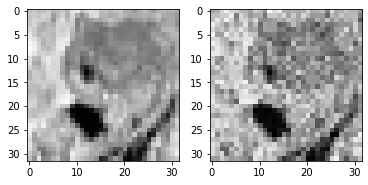

25  :  [0.7174475] 25
50  :  [0.83650607] 25
75  :  [0.90844655] 25
100  :  [0.90844655] 25
125  :  [0.90844655] 25
150  :  [0.92157954] 25
175  :  [0.92157954] 25
200  :  [0.92157954] 25
225  :  [0.92157954] 25
250  :  [0.92157954] 25
275  :  [0.92157954] 25
300  :  [0.92157954] 25
325  :  [0.92157954] 25
350  :  [0.92157954] 25
375  :  [0.92157954] 25
400  :  [0.92157954] 25
425  :  [0.92157954] 25
450  :  [0.92610526] 25
475  :  [0.9305863] 25
500  :  [0.932302] 25
525  :  [0.932302] 25
550  :  [0.936045] 25
575  :  [0.936045] 25
600  :  [0.936857] 25
625  :  [0.936857] 25
650  :  [0.936857] 25
675  :  [0.936857] 25
700  :  [0.936857] 25
725  :  [0.9394574] 25
750  :  [0.9394574] 25
775  :  [0.9394574] 25
800  :  [0.9394574] 25
825  :  [0.9394574] 25
850  :  [0.9394574] 25
875  :  [0.9394574] 25
900  :  [0.9394574] 25
925  :  [0.9394574] 25
Time:  137.67965292930603  seconds
Original class:  6
Prediction for normal image:  [6]
Prediction for adversarial image:  [2]


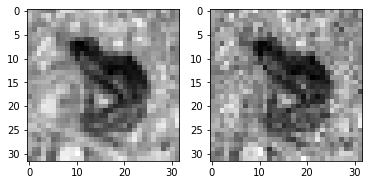

25  :  [0.771167] 25
50  :  [0.773015] 25
75  :  [0.81766903] 25
100  :  [0.833616] 25
125  :  [0.8347838] 25
150  :  [0.8347838] 25
175  :  [0.8648045] 25
200  :  [0.8648045] 25
225  :  [0.8648045] 25
250  :  [0.8648045] 25
275  :  [0.8648045] 25
300  :  [0.8648045] 25
325  :  [0.86937416] 25
350  :  [0.871839] 25
375  :  [0.87349373] 25
400  :  [0.87349373] 25
425  :  [0.88958585] 25
450  :  [0.89168334] 25
475  :  [0.89941466] 25
500  :  [0.89941466] 25
525  :  [0.90684134] 25
550  :  [0.9131794] 25
575  :  [0.9131794] 25
600  :  [0.9148257] 25
625  :  [0.9148257] 25
650  :  [0.917758] 25
675  :  [0.917758] 25
700  :  [0.917758] 25
725  :  [0.92138493] 25
750  :  [0.9239353] 25
775  :  [0.92815864] 25
800  :  [0.92815864] 25
825  :  [0.9311651] 25
850  :  [0.9311651] 25
875  :  [0.93313324] 25
900  :  [0.93380207] 25
925  :  [0.934528] 25
950  :  [0.9355656] 25
975  :  [0.935592] 25
1000  :  [0.9357254] 25
1025  :  [0.9364814] 25
1050  :  [0.9364814] 25
1075  :  [0.9376153] 25
1100 

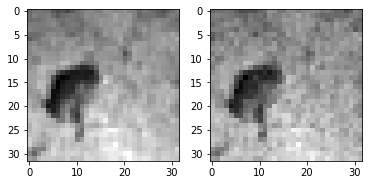

25  :  [0.00060305] 25
50  :  [0.45044494] 25
75  :  [0.6281245] 25
100  :  [0.6043192] 25
125  :  [0.7579427] 25
150  :  [0.73704785] 25
175  :  [0.73704785] 25
200  :  [0.73704785] 25
225  :  [0.8457998] 25
250  :  [0.8456583] 25
275  :  [0.8537252] 25
300  :  [0.85419554] 25
325  :  [0.85419554] 25
350  :  [0.85419554] 25
375  :  [0.85419554] 25
400  :  [0.85419554] 25
425  :  [0.85419554] 25
450  :  [0.85658395] 25
475  :  [0.85872054] 25
500  :  [0.86231726] 25
525  :  [0.8623154] 25
550  :  [0.8623154] 25
575  :  [0.8636965] 25
600  :  [0.8736511] 25
625  :  [0.8736511] 25
650  :  [0.8736511] 25
675  :  [0.8736511] 25
700  :  [0.8736511] 25
725  :  [0.8736511] 25
750  :  [0.8736511] 25
775  :  [0.8750324] 25
800  :  [0.8755549] 25
825  :  [0.8791101] 25
850  :  [0.87938666] 25
875  :  [0.8819003] 25
900  :  [0.8819003] 25
925  :  [0.88243204] 25
950  :  [0.88258064] 25
975  :  [0.88258064] 25
1000  :  [0.88258064] 25
Time:  149.8075351715088  seconds
Original class:  6
Prediction

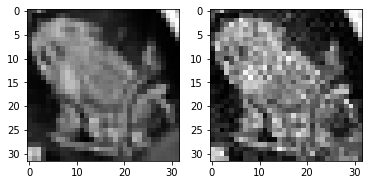

25  :  [0.5728304] 25
50  :  [0.7148644] 25
75  :  [0.7356008] 25
100  :  [0.7356008] 25
125  :  [0.7356008] 25
150  :  [0.7356008] 25
175  :  [0.7356008] 25
200  :  [0.7356008] 25
225  :  [0.7356008] 25
250  :  [0.7356008] 25
275  :  [0.74598944] 25
300  :  [0.74598944] 25
325  :  [0.74598944] 25
350  :  [0.74598944] 25
375  :  [0.75195265] 25
400  :  [0.7519753] 25
425  :  [0.757484] 25
450  :  [0.7643854] 25
475  :  [0.76491] 25
500  :  [0.7665367] 25
525  :  [0.79150164] 25
550  :  [0.79145294] 25
575  :  [0.79145294] 25
600  :  [0.80586624] 25
625  :  [0.80586624] 25
650  :  [0.8076031] 25
675  :  [0.8107795] 25
700  :  [0.814529] 25
725  :  [0.814529] 25
750  :  [0.814529] 25
775  :  [0.821332] 25
800  :  [0.821332] 25
825  :  [0.821332] 25
850  :  [0.824635] 25
875  :  [0.824635] 25
900  :  [0.82535076] 25
925  :  [0.82575905] 25
950  :  [0.82575905] 25
975  :  [0.8265641] 25
1000  :  [0.8267168] 25
1025  :  [0.8284584] 25
1050  :  [0.8284584] 25
1075  :  [0.8290267] 25
1100  : 

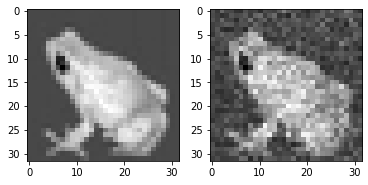

25  :  [0.6637667] 25
50  :  [0.7287839] 25
75  :  [0.5575256] 25
100  :  [0.63048506] 25
125  :  [0.6503588] 25
150  :  [0.6643205] 25
175  :  [0.6643205] 25
200  :  [0.6643205] 25
225  :  [0.6643205] 25
250  :  [0.6678165] 25
275  :  [0.6892589] 25
300  :  [0.6993552] 25
325  :  [0.6993552] 25
350  :  [0.6993552] 25
375  :  [0.7114442] 25
400  :  [0.71317834] 25
425  :  [0.71609575] 25
450  :  [0.71609575] 25
475  :  [0.71925527] 25
500  :  [0.7266874] 25
525  :  [0.73098445] 25
550  :  [0.7266874] 25
575  :  [0.7383553] 25
600  :  [0.73991776] 25
625  :  [0.74829674] 25
650  :  [0.74829674] 25
675  :  [0.7483696] 25
700  :  [0.7515923] 25
725  :  [0.7528243] 25
750  :  [0.75607395] 25
775  :  [0.75607395] 25
800  :  [0.75607395] 25
825  :  [0.75607395] 25
850  :  [0.75627923] 25
875  :  [0.75810707] 25
900  :  [0.75810707] 25
925  :  [0.7583267] 25
950  :  [0.75873137] 25
975  :  [0.75936735] 25
1000  :  [0.75936735] 25
1025  :  [0.7603806] 25
1050  :  [0.7616445] 25
1075  :  [0.762

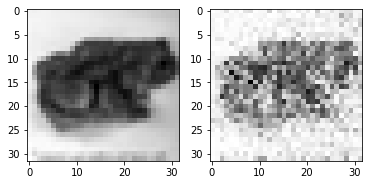

25  :  [0.59203196] 25
50  :  [0.86363924] 25
75  :  [0.86363924] 25
100  :  [0.86363924] 25
125  :  [0.86363924] 25
150  :  [0.86363924] 25
175  :  [0.86363924] 25
200  :  [0.86363924] 25
225  :  [0.86363924] 25
250  :  [0.86363924] 25
275  :  [0.86363924] 25
300  :  [0.8637848] 25
325  :  [0.8736987] 25
350  :  [0.8736954] 25
375  :  [0.8736954] 25
400  :  [0.8736954] 25
425  :  [0.8740777] 25
450  :  [0.87428033] 25
475  :  [0.8792444] 25
500  :  [0.87916553] 25
525  :  [0.8977814] 25
550  :  [0.8985615] 25
575  :  [0.90738446] 25
600  :  [0.90738446] 25
625  :  [0.91307664] 25
650  :  [0.9200417] 25
675  :  [0.9220896] 25
700  :  [0.932554] 25
725  :  [0.932554] 25
750  :  [0.932554] 25
775  :  [0.932554] 25
800  :  [0.9385042] 25
825  :  [0.9385042] 25
850  :  [0.9385042] 25
875  :  [0.94040763] 25
900  :  [0.94040763] 25
925  :  [0.94214344] 25
950  :  [0.9432922] 25
975  :  [0.9433386] 25
1000  :  [0.9436264] 25
1025  :  [0.9436264] 25
1050  :  [0.9442107] 25
1075  :  [0.9443748

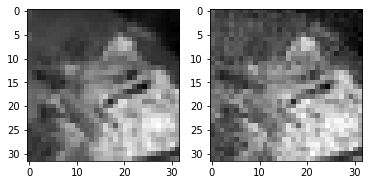

25  :  [0.26254076] 25
50  :  [0.607965] 25
75  :  [0.607965] 25
100  :  [0.6702308] 25
125  :  [0.72697234] 25
150  :  [0.88572454] 25
175  :  [0.88572454] 25
200  :  [0.88572454] 25
225  :  [0.88572454] 25
250  :  [0.88572454] 25
275  :  [0.88572454] 25
300  :  [0.88572454] 25
325  :  [0.88572454] 25
350  :  [0.88572454] 25
375  :  [0.8993223] 25
400  :  [0.90248513] 25
425  :  [0.91078556] 25
450  :  [0.91078556] 25
475  :  [0.91078556] 25
500  :  [0.91078556] 25
525  :  [0.91078556] 25
550  :  [0.91078556] 25
575  :  [0.92471683] 25
600  :  [0.92471683] 25
625  :  [0.92779934] 25
650  :  [0.92779934] 25
675  :  [0.92779934] 25
700  :  [0.92779934] 25
725  :  [0.9287135] 25
750  :  [0.93044835] 25
775  :  [0.93044835] 25
800  :  [0.93088156] 25
825  :  [0.93193084] 25
850  :  [0.9320798] 25
875  :  [0.9320798] 25
900  :  [0.9329637] 25
925  :  [0.9335537] 25
950  :  [0.93367195] 25
975  :  [0.93428266] 25
1000  :  [0.9346094] 25
1025  :  [0.93493736] 25
1050  :  [0.93502367] 25
1075

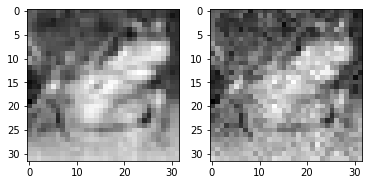

25  :  [0.31707555] 25
50  :  [0.8021336] 25
75  :  [0.7960733] 25
100  :  [0.7960733] 25
125  :  [0.7960733] 25
150  :  [0.7960733] 25
175  :  [0.7960733] 25
200  :  [0.7960733] 25
225  :  [0.8019154] 25
250  :  [0.8019154] 25
275  :  [0.8019154] 25
300  :  [0.8019154] 25
325  :  [0.8019154] 25
350  :  [0.8036349] 25
375  :  [0.8036349] 25
400  :  [0.8036374] 25
425  :  [0.81742394] 25
450  :  [0.81742394] 25
475  :  [0.8216443] 25
500  :  [0.8319795] 25
525  :  [0.8346753] 25
550  :  [0.83565634] 25
575  :  [0.8412433] 25
600  :  [0.8412433] 25
625  :  [0.8419819] 25
650  :  [0.8426069] 25
675  :  [0.8426069] 25
700  :  [0.8426069] 25
725  :  [0.8454857] 25
750  :  [0.84811634] 25
775  :  [0.8509996] 25
800  :  [0.8541703] 25
825  :  [0.8541703] 25
850  :  [0.8541703] 25
875  :  [0.8541703] 25
900  :  [0.85530853] 25
925  :  [0.85530853] 25
950  :  [0.8556688] 25
975  :  [0.85594046] 25
1000  :  [0.8581978] 25
1025  :  [0.8581978] 25
1050  :  [0.858407] 25
1075  :  [0.8584748] 25
110

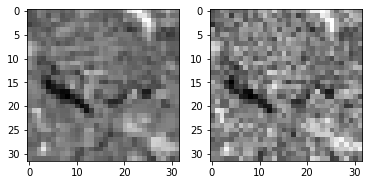

25  :  [0.17021322] 25
50  :  [0.45427763] 25
75  :  [0.4892841] 25
100  :  [0.48808318] 25
125  :  [0.55409026] 25
150  :  [0.6009079] 25
175  :  [0.6009079] 25
200  :  [0.6278633] 25
225  :  [0.6278633] 25
250  :  [0.6278633] 25
275  :  [0.6278633] 25
300  :  [0.6278633] 25
325  :  [0.62803584] 25
350  :  [0.62803584] 25
375  :  [0.65202117] 25
400  :  [0.65202117] 25
425  :  [0.6682807] 25
450  :  [0.67108184] 25
475  :  [0.671232] 25
500  :  [0.6720818] 25
525  :  [0.6742348] 25
550  :  [0.6922242] 25
575  :  [0.6923561] 25
600  :  [0.6923474] 25
625  :  [0.6943823] 25
650  :  [0.694412] 25
675  :  [0.694412] 25
700  :  [0.6968838] 25
725  :  [0.6968838] 25
750  :  [0.6974058] 25
775  :  [0.6974058] 25
800  :  [0.697976] 25
825  :  [0.69897115] 25
850  :  [0.69897115] 25
875  :  [0.69897115] 25
900  :  [0.69897115] 25
925  :  [0.6990369] 25
950  :  [0.69938475] 25
975  :  [0.69938475] 25
1000  :  [0.6996213] 25
1025  :  [0.70005393] 25
1050  :  [0.70005393] 25
1075  :  [0.70014364]

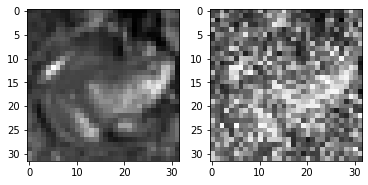

25  :  [0.18966095] 25
50  :  [0.6064892] 25
75  :  [0.5123779] 25
100  :  [0.51129746] 25
125  :  [0.5801325] 25
150  :  [0.6771579] 25
175  :  [0.59769654] 25
200  :  [0.7066834] 25
225  :  [0.59769654] 25
250  :  [0.622877] 25
275  :  [0.62527317] 25
300  :  [0.6085031] 25
325  :  [0.6232361] 25
350  :  [0.64748996] 25
375  :  [0.6495961] 25
400  :  [0.6495961] 25
425  :  [0.6495961] 25
450  :  [0.6495961] 25
475  :  [0.6587595] 25
500  :  [0.6623601] 25
525  :  [0.6587595] 25
550  :  [0.6587595] 25
575  :  [0.66763896] 25
600  :  [0.6736461] 25
625  :  [0.6765449] 25
650  :  [0.6803628] 25
675  :  [0.6803628] 25
700  :  [0.6803628] 25
725  :  [0.68350345] 25
750  :  [0.68350345] 25
775  :  [0.68350345] 25
800  :  [0.68350345] 25
825  :  [0.68350345] 25
850  :  [0.68350345] 25
875  :  [0.68350345] 25
900  :  [0.68350345] 25
925  :  [0.69327956] 25
950  :  [0.69179624] 25
975  :  [0.69179624] 25
1000  :  [0.69179624] 25
1025  :  [0.69179624] 25
1050  :  [0.69179624] 25
1075  :  [0.69

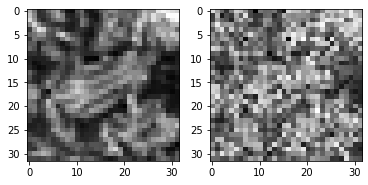

25  :  [0.03797027] 25
50  :  [0.03797027] 25
75  :  [0.05418193] 25
100  :  [0.2979149] 25
125  :  [0.29974806] 25
150  :  [0.7472279] 25
175  :  [0.77872944] 25
200  :  [0.77872944] 25
225  :  [0.77872944] 25
250  :  [0.77872944] 25
275  :  [0.77872944] 25
300  :  [0.77872944] 25
325  :  [0.77872944] 25
350  :  [0.77872944] 25
375  :  [0.77872944] 25
400  :  [0.77872944] 25
425  :  [0.77872944] 25
450  :  [0.80491805] 25
475  :  [0.808024] 25
500  :  [0.808024] 25
525  :  [0.808024] 25
550  :  [0.808024] 25
575  :  [0.808024] 25
600  :  [0.808024] 25
625  :  [0.8150241] 25
650  :  [0.8150241] 25
675  :  [0.8257086] 25
700  :  [0.8272606] 25
725  :  [0.85190654] 25
750  :  [0.8526046] 25
775  :  [0.8695065] 25
800  :  [0.8695065] 25
825  :  [0.8695065] 25
850  :  [0.8695065] 25
875  :  [0.8695065] 25
900  :  [0.8695065] 25
925  :  [0.8695065] 25
950  :  [0.8782557] 25
975  :  [0.87825096] 25
1000  :  [0.88745904] 25
1025  :  [0.88745904] 25
1050  :  [0.8908489] 25
1075  :  [0.89480793

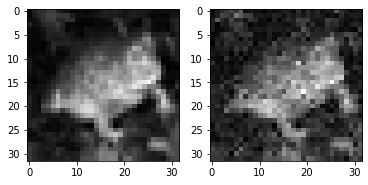

25  :  [0.3946122] 25
50  :  [0.49094146] 25
75  :  [0.35999855] 25
100  :  [0.37092537] 25
125  :  [0.4784785] 25
150  :  [0.46553427] 25
175  :  [0.5490706] 25
200  :  [0.6841372] 25
225  :  [0.6844127] 25
250  :  [0.6844127] 25
275  :  [0.6844127] 25
300  :  [0.6844127] 25
325  :  [0.6844127] 25
350  :  [0.6844127] 25
375  :  [0.6844127] 25
400  :  [0.6844127] 25
425  :  [0.6844127] 25
450  :  [0.6844127] 25
475  :  [0.6844127] 25
500  :  [0.6844127] 25
525  :  [0.6844127] 25
550  :  [0.6844127] 25
575  :  [0.6844127] 25
600  :  [0.6844127] 25
625  :  [0.6844127] 25
650  :  [0.7007149] 25
675  :  [0.7007149] 25
700  :  [0.7007149] 25
725  :  [0.7007149] 25
750  :  [0.7007149] 25
775  :  [0.7007149] 25
800  :  [0.70259535] 25
825  :  [0.7068362] 25
850  :  [0.7217728] 25
875  :  [0.7217728] 25
900  :  [0.7275919] 25
925  :  [0.727657] 25
950  :  [0.7276928] 25
975  :  [0.74711716] 25
1000  :  [0.74711716] 25
1025  :  [0.74711716] 25
1050  :  [0.74711716] 25
1075  :  [0.74711716] 25
1

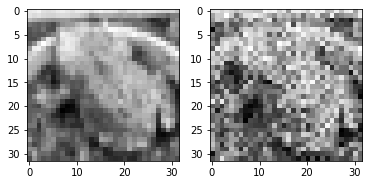

25  :  [0.8536315] 25
50  :  [0.8567894] 25
75  :  [0.7774681] 25
100  :  [0.7793195] 25
125  :  [0.79785234] 25
150  :  [0.79785234] 25
175  :  [0.79785234] 25
200  :  [0.79785234] 25
225  :  [0.79785234] 25
250  :  [0.82156307] 25
275  :  [0.81638265] 25
300  :  [0.81638265] 25
325  :  [0.81638265] 25
350  :  [0.81638265] 25
375  :  [0.81638265] 25
400  :  [0.81638265] 25
425  :  [0.8378912] 25
450  :  [0.8378912] 25
475  :  [0.8378912] 25
500  :  [0.8378912] 25
525  :  [0.8378912] 25
550  :  [0.8378912] 25
575  :  [0.8378912] 25
600  :  [0.8378912] 25
625  :  [0.8378912] 25
650  :  [0.8378912] 25
675  :  [0.8378912] 25
700  :  [0.8378912] 25
725  :  [0.8378912] 25
750  :  [0.8378912] 25
775  :  [0.8378912] 25
800  :  [0.8378912] 25
825  :  [0.8378912] 25
850  :  [0.8378912] 25
875  :  [0.8378912] 25
900  :  [0.8378912] 25
925  :  [0.8378912] 25
950  :  [0.8378912] 25
975  :  [0.8378912] 25
1000  :  [0.8378912] 25
1025  :  [0.8378912] 25
1050  :  [0.8381418] 25
1075  :  [0.8381418] 2

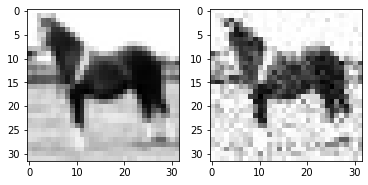

25  :  [0.8899159] 25
50  :  [0.8899159] 25
75  :  [0.8899159] 25
100  :  [0.90215695] 25
125  :  [0.90215695] 25
150  :  [0.90215695] 25
175  :  [0.90215695] 25
200  :  [0.9082641] 25
225  :  [0.9082641] 25
250  :  [0.9082641] 25
275  :  [0.9082641] 25
300  :  [0.9127271] 25
325  :  [0.91740334] 25
350  :  [0.91743296] 25
375  :  [0.91990113] 25
400  :  [0.91990113] 25
425  :  [0.91990113] 25
450  :  [0.91990113] 25
475  :  [0.91990113] 25
500  :  [0.91990113] 25
525  :  [0.92060506] 25
550  :  [0.92060506] 25
575  :  [0.9224752] 25
600  :  [0.923483] 25
625  :  [0.92373717] 25
650  :  [0.9243903] 25
675  :  [0.92465556] 25
700  :  [0.92613274] 25
725  :  [0.92613274] 25
750  :  [0.92622924] 25
775  :  [0.926434] 25
800  :  [0.92728496] 25
825  :  [0.9279267] 25
850  :  [0.9283229] 25
875  :  [0.9285531] 25
Time:  131.9062271118164  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


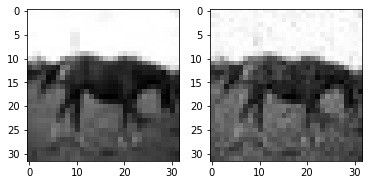

25  :  [0.93550205] 25
50  :  [0.93550205] 25
75  :  [0.93550205] 25
100  :  [0.93550205] 25
125  :  [0.93550205] 25
150  :  [0.93550205] 25
175  :  [0.93550205] 25
200  :  [0.93550205] 25
225  :  [0.93550205] 25
250  :  [0.93550205] 25
275  :  [0.93550205] 25
300  :  [0.93550205] 25
325  :  [0.93550205] 25
350  :  [0.93550205] 25
375  :  [0.9403175] 25
400  :  [0.9403175] 25
425  :  [0.9403175] 25
450  :  [0.9403175] 25
475  :  [0.9406163] 25
500  :  [0.94059944] 25
525  :  [0.9412092] 25
550  :  [0.9412092] 25
575  :  [0.9419973] 25
600  :  [0.9419973] 25
625  :  [0.94275683] 25
650  :  [0.94300264] 25
675  :  [0.9434586] 25
700  :  [0.9448807] 25
725  :  [0.9448807] 25
750  :  [0.94717944] 25
775  :  [0.94717944] 25
800  :  [0.94717944] 25
Time:  118.8682656288147  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


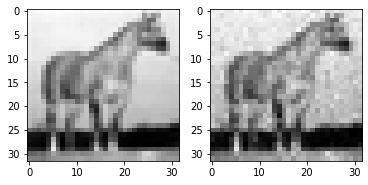

25  :  [0.8694668] 25
50  :  [0.8694668] 25
75  :  [0.8932359] 25
100  :  [0.8923086] 25
125  :  [0.8923086] 25
150  :  [0.8923086] 25
175  :  [0.8923086] 25
200  :  [0.8923086] 25
225  :  [0.8923086] 25
250  :  [0.8923086] 25
275  :  [0.8923086] 25
300  :  [0.8923086] 25
325  :  [0.8923086] 25
350  :  [0.8923086] 25
375  :  [0.8923086] 25
400  :  [0.8923086] 25
425  :  [0.8923086] 25
450  :  [0.8923086] 25
475  :  [0.8923086] 25
500  :  [0.8923086] 25
525  :  [0.8923086] 25
550  :  [0.8923086] 25
575  :  [0.8923086] 25
600  :  [0.8923086] 25
625  :  [0.8923086] 25
650  :  [0.8923086] 25
675  :  [0.8923086] 25
700  :  [0.8923086] 25
725  :  [0.8923086] 25
750  :  [0.8923086] 25
775  :  [0.8923086] 25
800  :  [0.8923086] 25
825  :  [0.8923086] 25
850  :  [0.8923086] 25
Time:  126.82349896430969  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [2]


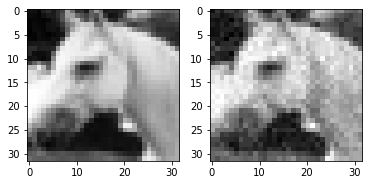

25  :  [0.85712445] 25
50  :  [0.85712445] 25
75  :  [0.8477448] 25
100  :  [0.8615848] 25
125  :  [0.8615848] 25
150  :  [0.8615848] 25
175  :  [0.8615848] 25
200  :  [0.8644508] 25
225  :  [0.8771306] 25
250  :  [0.8891685] 25
275  :  [0.88919437] 25
300  :  [0.8909874] 25
325  :  [0.8988358] 25
350  :  [0.8991911] 25
375  :  [0.8991911] 25
400  :  [0.8991911] 25
425  :  [0.8991911] 25
450  :  [0.8991911] 25
475  :  [0.8991911] 25
500  :  [0.8991911] 25
525  :  [0.9073808] 25
550  :  [0.9073808] 25
575  :  [0.9121015] 25
600  :  [0.9200046] 25
625  :  [0.92002535] 25
650  :  [0.9230576] 25
675  :  [0.9230576] 25
700  :  [0.9230576] 25
725  :  [0.92497575] 25
750  :  [0.92497575] 25
775  :  [0.92620075] 25
800  :  [0.9272975] 25
825  :  [0.9276028] 25
850  :  [0.9283749] 25
875  :  [0.92843777] 25
900  :  [0.929477] 25
925  :  [0.929477] 25
950  :  [0.9295746] 25
975  :  [0.9295746] 25
1000  :  [0.9295746] 25
1025  :  [0.9298061] 25
Time:  152.286719083786  seconds
Original class:  7


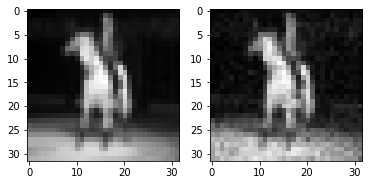

25  :  [0.8371718] 25
50  :  [0.8658773] 25
75  :  [0.8658773] 25
100  :  [0.87576246] 25
125  :  [0.87576246] 25
150  :  [0.8777766] 25
175  :  [0.8777766] 25
200  :  [0.8976667] 25
225  :  [0.8976667] 25
250  :  [0.8976667] 25
275  :  [0.8976667] 25
300  :  [0.8976667] 25
325  :  [0.8976667] 25
350  :  [0.9153087] 25
375  :  [0.9153087] 25
400  :  [0.9153087] 25
425  :  [0.9153087] 25
450  :  [0.9153087] 25
475  :  [0.9153087] 25
500  :  [0.92029214] 25
525  :  [0.92029214] 25
550  :  [0.92029214] 25
575  :  [0.9331634] 25
600  :  [0.93649924] 25
625  :  [0.9372869] 25
650  :  [0.9372869] 25
675  :  [0.9372869] 25
700  :  [0.9372869] 25
725  :  [0.9376818] 25
750  :  [0.94061786] 25
775  :  [0.9439123] 25
800  :  [0.9451008] 25
825  :  [0.94844586] 25
850  :  [0.94844586] 25
875  :  [0.94844586] 25
900  :  [0.94992703] 25
925  :  [0.94992703] 25
950  :  [0.94992703] 25
975  :  [0.94992703] 25
1000  :  [0.95129824] 25
1025  :  [0.9521096] 25
1050  :  [0.9522144] 25
1075  :  [0.9522144

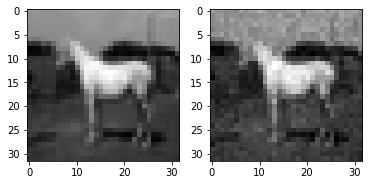

25  :  [0.9253618] 25
50  :  [0.9335901] 25
75  :  [0.9335901] 25
100  :  [0.9335901] 25
125  :  [0.9335901] 25
150  :  [0.9335901] 25
175  :  [0.9335901] 25
200  :  [0.9335901] 25
225  :  [0.9365529] 25
250  :  [0.9409692] 25
275  :  [0.94094825] 25
300  :  [0.94530493] 25
325  :  [0.9464669] 25
350  :  [0.9464669] 25
375  :  [0.9464669] 25
400  :  [0.9478482] 25
425  :  [0.94829375] 25
450  :  [0.95635223] 25
475  :  [0.95635223] 25
500  :  [0.95635223] 25
525  :  [0.9591633] 25
550  :  [0.9591633] 25
575  :  [0.9591633] 25
600  :  [0.95932513] 25
625  :  [0.9607686] 25
650  :  [0.9643704] 25
675  :  [0.9644282] 25
700  :  [0.9668092] 25
725  :  [0.9678937] 25
750  :  [0.9680141] 25
775  :  [0.96974564] 25
800  :  [0.96974564] 25
Time:  117.92928338050842  seconds
Original class:  7
Prediction for normal image:  [4]
Prediction for adversarial image:  [2]


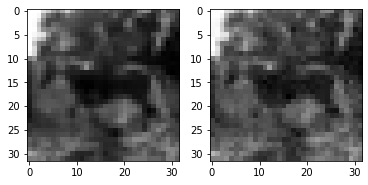

25  :  [0.973914] 25
50  :  [0.97734237] 25
75  :  [0.9773209] 25
100  :  [0.9773209] 25
125  :  [0.9773209] 25
150  :  [0.9773209] 25
175  :  [0.9773209] 25
200  :  [0.9773209] 25
225  :  [0.97732925] 25
250  :  [0.97868526] 25
275  :  [0.9807453] 25
300  :  [0.983495] 25
325  :  [0.98356193] 25
350  :  [0.9835665] 25
375  :  [0.9852967] 25
400  :  [0.9852967] 25
425  :  [0.98577076] 25
450  :  [0.9877924] 25
475  :  [0.98860073] 25
500  :  [0.98860073] 25
525  :  [0.9891224] 25
550  :  [0.9891224] 25
575  :  [0.9891224] 25
600  :  [0.9891224] 25
625  :  [0.9891224] 25
650  :  [0.9891224] 25
675  :  [0.98942846] 25
700  :  [0.98971516] 25
725  :  [0.98971516] 25
750  :  [0.9899914] 25
775  :  [0.9899914] 25
800  :  [0.9899914] 25
Time:  132.9097080230713  seconds
Original class:  7
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


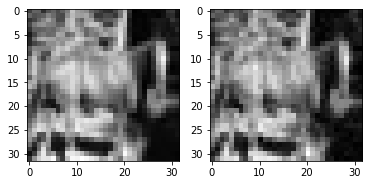

25  :  [0.97325397] 25
50  :  [0.97325397] 25
75  :  [0.97325397] 25
100  :  [0.97325397] 25
125  :  [0.9740634] 25
150  :  [0.9740634] 25
175  :  [0.9740634] 25
200  :  [0.97690195] 25
225  :  [0.97690195] 25
250  :  [0.97690195] 25
275  :  [0.9775233] 25
300  :  [0.9790958] 25
325  :  [0.9790958] 25
350  :  [0.9790958] 25
375  :  [0.9804584] 25
400  :  [0.9804584] 25
425  :  [0.98080355] 25
450  :  [0.9808032] 25
475  :  [0.9808032] 25
500  :  [0.98210645] 25
525  :  [0.98210645] 25
550  :  [0.98210645] 25
575  :  [0.9837209] 25
600  :  [0.9837209] 25
625  :  [0.9837209] 25
650  :  [0.9867234] 25
675  :  [0.9867234] 25
700  :  [0.98705804] 25
725  :  [0.98774034] 25
750  :  [0.98774034] 25
775  :  [0.98774034] 25
800  :  [0.98774034] 25
Time:  156.5826551914215  seconds
Original class:  7
Prediction for normal image:  [4]
Prediction for adversarial image:  [4]


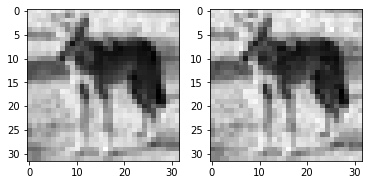

25  :  [0.9712995] 25
50  :  [0.9712995] 25
75  :  [0.9712995] 25
100  :  [0.9766488] 25
125  :  [0.97700584] 25
150  :  [0.97708404] 25
175  :  [0.97888523] 25
200  :  [0.978919] 25
225  :  [0.9813563] 25
250  :  [0.9821526] 25
275  :  [0.984396] 25
300  :  [0.9854113] 25
325  :  [0.9862782] 25
350  :  [0.9862782] 25
375  :  [0.9862782] 25
400  :  [0.98649] 25
425  :  [0.98649] 25
450  :  [0.98814857] 25
475  :  [0.98814857] 25
500  :  [0.98814857] 25
525  :  [0.9882914] 25
550  :  [0.9889405] 25
575  :  [0.98911] 25
600  :  [0.98922443] 25
625  :  [0.98934746] 25
650  :  [0.9895505] 25
675  :  [0.9896078] 25
700  :  [0.9903994] 25
725  :  [0.9904337] 25
750  :  [0.9904709] 25
775  :  [0.99053437] 25
800  :  [0.99069285] 25
Time:  156.4709827899933  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


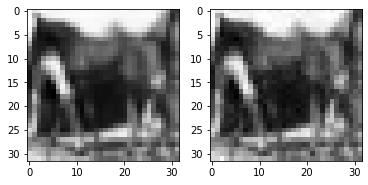

25  :  [0.95558494] 25
50  :  [0.95558494] 25
75  :  [0.9557303] 25
100  :  [0.9557303] 25
125  :  [0.9557303] 25
150  :  [0.9557303] 25
175  :  [0.9557303] 25
200  :  [0.9557303] 25
225  :  [0.9557303] 25
250  :  [0.9557303] 25
275  :  [0.9562234] 25
300  :  [0.95857763] 25
325  :  [0.95891917] 25
350  :  [0.96268666] 25
375  :  [0.964066] 25
400  :  [0.964066] 25
425  :  [0.9643583] 25
450  :  [0.97031754] 25
475  :  [0.97031754] 25
500  :  [0.97031754] 25
525  :  [0.97031754] 25
550  :  [0.9724697] 25
575  :  [0.9724697] 25
600  :  [0.9737295] 25
625  :  [0.9755968] 25
650  :  [0.97568315] 25
675  :  [0.97568315] 25
700  :  [0.9760572] 25
725  :  [0.9760572] 25
750  :  [0.9760572] 25
775  :  [0.97612655] 25
800  :  [0.97646564] 25
Time:  150.14466071128845  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [6]


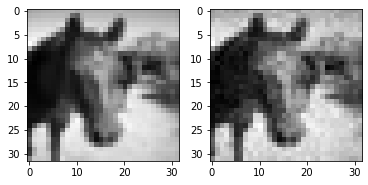

25  :  [0.9401163] 25
50  :  [0.9401163] 25
75  :  [0.9401163] 25
100  :  [0.9415294] 25
125  :  [0.943471] 25
150  :  [0.943471] 25
175  :  [0.943471] 25
200  :  [0.9490824] 25
225  :  [0.9510573] 25
250  :  [0.9510573] 25
275  :  [0.95161617] 25
300  :  [0.9528245] 25
325  :  [0.9528245] 25
350  :  [0.9528245] 25
375  :  [0.9605768] 25
400  :  [0.9605768] 25
425  :  [0.9605768] 25
450  :  [0.96209663] 25
475  :  [0.96209663] 25
500  :  [0.96209663] 25
525  :  [0.9674462] 25
550  :  [0.9674462] 25
575  :  [0.97072566] 25
600  :  [0.97072566] 25
625  :  [0.97072566] 25
650  :  [0.9715112] 25
675  :  [0.9715112] 25
700  :  [0.9734303] 25
725  :  [0.974344] 25
750  :  [0.97500944] 25
775  :  [0.9757576] 25
800  :  [0.9757576] 25
Time:  163.58006024360657  seconds
Original class:  7
Prediction for normal image:  [7]
Prediction for adversarial image:  [2]


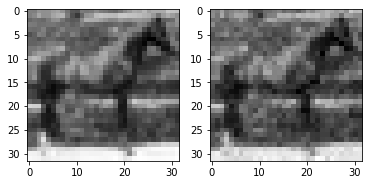

25  :  [0.87554526] 25
50  :  [0.8804225] 25
75  :  [0.88432926] 25
100  :  [0.88493586] 25
125  :  [0.8980823] 25
150  :  [0.8980823] 25
175  :  [0.8980823] 25
200  :  [0.8980823] 25
225  :  [0.8980823] 25
250  :  [0.8980823] 25
275  :  [0.8980823] 25
300  :  [0.8980823] 25
325  :  [0.8980823] 25
350  :  [0.8980823] 25
375  :  [0.8980823] 25
400  :  [0.8980823] 25
425  :  [0.8980823] 25
450  :  [0.8980823] 25
475  :  [0.8980823] 25
500  :  [0.8980823] 25
525  :  [0.8980823] 25
550  :  [0.8980823] 25
575  :  [0.8980823] 25
600  :  [0.8980823] 25
625  :  [0.8980823] 25
650  :  [0.9063673] 25
675  :  [0.9063712] 25
700  :  [0.9063712] 25
725  :  [0.9063712] 25
750  :  [0.90731305] 25
775  :  [0.9236652] 25
800  :  [0.9236652] 25
825  :  [0.92388487] 25
850  :  [0.92388487] 25
875  :  [0.92388487] 25
900  :  [0.92388487] 25
925  :  [0.9299579] 25
950  :  [0.9299579] 25
975  :  [0.9299579] 25
1000  :  [0.9299579] 25
1025  :  [0.9299579] 25
1050  :  [0.9299579] 25
1075  :  [0.9299579] 25
11

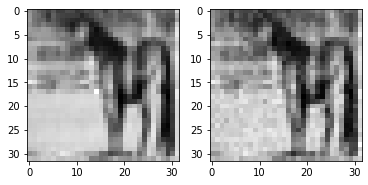

25  :  [0.834362] 25
50  :  [0.834362] 25
75  :  [0.8554313] 25
100  :  [0.8822577] 25
125  :  [0.8868216] 25
150  :  [0.8868216] 25
175  :  [0.8868216] 25
200  :  [0.8868216] 25
225  :  [0.8868216] 25
250  :  [0.8868973] 25
275  :  [0.8868216] 25
300  :  [0.88780034] 25
325  :  [0.8906554] 25
350  :  [0.8950399] 25
375  :  [0.8953226] 25
400  :  [0.901374] 25
425  :  [0.90742207] 25
450  :  [0.90742207] 25
475  :  [0.90844595] 25
500  :  [0.90844595] 25
525  :  [0.90844595] 25
550  :  [0.90844595] 25
575  :  [0.9093039] 25
600  :  [0.90993726] 25
625  :  [0.91053784] 25
650  :  [0.9109237] 25
675  :  [0.91288173] 25
700  :  [0.91433513] 25
725  :  [0.91433513] 25
750  :  [0.9151163] 25
775  :  [0.9151163] 25
800  :  [0.91568553] 25
825  :  [0.91581714] 25
850  :  [0.91581714] 25
875  :  [0.9162767] 25
Time:  174.46396780014038  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [6]


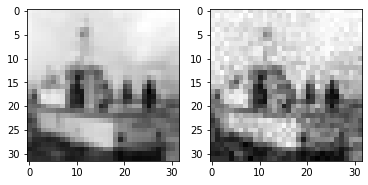

25  :  [0.9186323] 25
50  :  [0.9186323] 25
75  :  [0.9186323] 25
100  :  [0.9186323] 25
125  :  [0.9186323] 25
150  :  [0.9186323] 25
175  :  [0.9186323] 25
200  :  [0.9186323] 25
225  :  [0.9241588] 25
250  :  [0.9241588] 25
275  :  [0.9268527] 25
300  :  [0.9268527] 25
325  :  [0.92711747] 25
350  :  [0.92711747] 25
375  :  [0.92711747] 25
400  :  [0.92727727] 25
425  :  [0.92727727] 25
450  :  [0.93784535] 25
475  :  [0.93784535] 25
500  :  [0.93784535] 25
525  :  [0.93784535] 25
550  :  [0.93859994] 25
575  :  [0.94002306] 25
600  :  [0.94002306] 25
625  :  [0.94002306] 25
650  :  [0.94002306] 25
675  :  [0.94374144] 25
700  :  [0.94638646] 25
725  :  [0.94638646] 25
750  :  [0.94638646] 25
775  :  [0.94638646] 25
800  :  [0.9472225] 25
825  :  [0.9472225] 25
850  :  [0.94964] 25
875  :  [0.94964] 25
900  :  [0.95201313] 25
925  :  [0.95243067] 25
950  :  [0.95243067] 25
975  :  [0.95259184] 25
1000  :  [0.9544134] 25
1025  :  [0.9544134] 25
1050  :  [0.9556159] 25
1075  :  [0.956

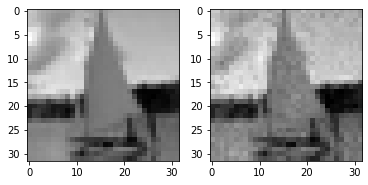

25  :  [0.9117716] 25
50  :  [0.91939616] 25
75  :  [0.92625713] 25
100  :  [0.9365524] 25
125  :  [0.9365524] 25
150  :  [0.9365524] 25
175  :  [0.9365524] 25
200  :  [0.9365524] 25
225  :  [0.9365524] 25
250  :  [0.94251996] 25
275  :  [0.94251996] 25
300  :  [0.94251996] 25
325  :  [0.94251996] 25
350  :  [0.9462163] 25
375  :  [0.946363] 25
400  :  [0.94879836] 25
425  :  [0.95381665] 25
450  :  [0.95381665] 25
475  :  [0.95381665] 25
500  :  [0.9576039] 25
525  :  [0.9576039] 25
550  :  [0.9576039] 25
575  :  [0.9576039] 25
600  :  [0.9576039] 25
625  :  [0.9576039] 25
650  :  [0.9576039] 25
675  :  [0.9583312] 25
700  :  [0.9583312] 25
725  :  [0.9590092] 25
750  :  [0.9591286] 25
775  :  [0.9596003] 25
800  :  [0.96059936] 25
825  :  [0.96059936] 25
850  :  [0.96059936] 25
875  :  [0.9610384] 25
Time:  174.9704806804657  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


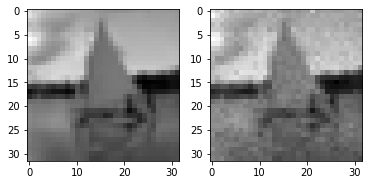

25  :  [0.7989498] 25
50  :  [0.7989498] 25
75  :  [0.7955122] 25
100  :  [0.7955122] 25
125  :  [0.7955122] 25
150  :  [0.7955122] 25
175  :  [0.7955122] 25
200  :  [0.7955122] 25
225  :  [0.8081142] 25
250  :  [0.80788386] 25
275  :  [0.80788386] 25
300  :  [0.80788386] 25
325  :  [0.80788386] 25
350  :  [0.80788386] 25
375  :  [0.80788386] 25
400  :  [0.8106599] 25
425  :  [0.8106599] 25
450  :  [0.8106599] 25
475  :  [0.8106599] 25
500  :  [0.8106599] 25
525  :  [0.8106599] 25
550  :  [0.8106599] 25
575  :  [0.8106599] 25
600  :  [0.8106599] 25
625  :  [0.81454563] 25
650  :  [0.8140061] 25
675  :  [0.8140061] 25
700  :  [0.81642663] 25
725  :  [0.81642663] 25
750  :  [0.8166332] 25
775  :  [0.8164351] 25
800  :  [0.8212852] 25
825  :  [0.82128775] 25
850  :  [0.82128775] 25
875  :  [0.8254826] 25
900  :  [0.8254826] 25
925  :  [0.83225584] 25
950  :  [0.83225584] 25
975  :  [0.83225584] 25
1000  :  [0.8355614] 25
Time:  198.91015696525574  seconds
Original class:  8
Prediction for

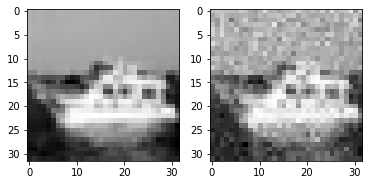

25  :  [0.97058594] 25
50  :  [0.9710995] 25
75  :  [0.9718219] 25
100  :  [0.9756105] 25
125  :  [0.9754997] 25
150  :  [0.9754997] 25
175  :  [0.9754997] 25
200  :  [0.9754997] 25
225  :  [0.97612286] 25
250  :  [0.9775318] 25
275  :  [0.97787386] 25
300  :  [0.9780896] 25
325  :  [0.9812821] 25
350  :  [0.9813834] 25
375  :  [0.9820931] 25
400  :  [0.982082] 25
425  :  [0.982082] 25
450  :  [0.983305] 25
475  :  [0.9836737] 25
500  :  [0.98477334] 25
525  :  [0.98477334] 25
550  :  [0.98477334] 25
575  :  [0.98477334] 25
600  :  [0.9848168] 25
625  :  [0.9853661] 25
650  :  [0.98581815] 25
675  :  [0.986063] 25
700  :  [0.98620087] 25
725  :  [0.9863173] 25
750  :  [0.9863173] 25
775  :  [0.98636746] 25
800  :  [0.9864371] 25
Time:  160.77575206756592  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [6]


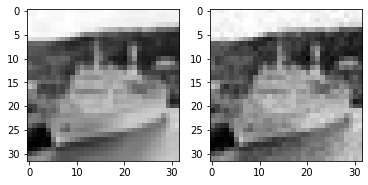

25  :  [0.88553417] 25
50  :  [0.9010756] 25
75  :  [0.9164738] 25
100  :  [0.919521] 25
125  :  [0.919521] 25
150  :  [0.92478824] 25
175  :  [0.9246783] 25
200  :  [0.9246783] 25
225  :  [0.9246783] 25
250  :  [0.9314523] 25
275  :  [0.9314523] 25
300  :  [0.9326576] 25
325  :  [0.9326576] 25
350  :  [0.9326576] 25
375  :  [0.9326576] 25
400  :  [0.9326576] 25
425  :  [0.9326576] 25
450  :  [0.93580306] 25
475  :  [0.93580306] 25
500  :  [0.93975973] 25
525  :  [0.93975973] 25
550  :  [0.93975973] 25
575  :  [0.940115] 25
600  :  [0.941193] 25
625  :  [0.9420272] 25
650  :  [0.945678] 25
675  :  [0.945678] 25
700  :  [0.94627464] 25
725  :  [0.9479542] 25
750  :  [0.9479542] 25
775  :  [0.9479542] 25
800  :  [0.9486821] 25
825  :  [0.9487506] 25
850  :  [0.9487506] 25
Time:  170.4354498386383  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [0]


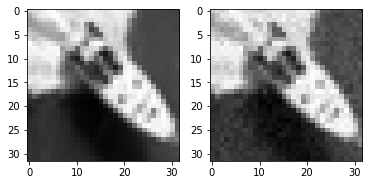

25  :  [0.77724475] 25
50  :  [0.7998886] 25
75  :  [0.7999586] 25
100  :  [0.803543] 25
125  :  [0.8105325] 25
150  :  [0.817042] 25
175  :  [0.817042] 25
200  :  [0.817042] 25
225  :  [0.818394] 25
250  :  [0.818394] 25
275  :  [0.8226943] 25
300  :  [0.8247181] 25
325  :  [0.8263856] 25
350  :  [0.8263856] 25
375  :  [0.8370746] 25
400  :  [0.8370746] 25
425  :  [0.8370746] 25
450  :  [0.84092903] 25
475  :  [0.84092903] 25
500  :  [0.84092903] 25
525  :  [0.85354435] 25
550  :  [0.85354435] 25
575  :  [0.85354435] 25
600  :  [0.85354435] 25
625  :  [0.8548658] 25
650  :  [0.8590834] 25
675  :  [0.86119527] 25
700  :  [0.86119527] 25
725  :  [0.86370957] 25
750  :  [0.86370957] 25
775  :  [0.86370957] 25
800  :  [0.86661315] 25
825  :  [0.86670566] 25
850  :  [0.86670566] 25
875  :  [0.86670566] 25
900  :  [0.8670687] 25
925  :  [0.86769664] 25
950  :  [0.8682666] 25
975  :  [0.86832917] 25
1000  :  [0.86876404] 25
1025  :  [0.86896276] 25
1050  :  [0.86896276] 25
1075  :  [0.869015

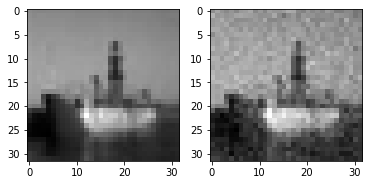

25  :  [0.95047176] 25
50  :  [0.9518084] 25
75  :  [0.95185566] 25
100  :  [0.9557465] 25
125  :  [0.9557465] 25
150  :  [0.9557465] 25
175  :  [0.96236485] 25
200  :  [0.96206075] 25
225  :  [0.96206075] 25
250  :  [0.96332335] 25
275  :  [0.9655622] 25
300  :  [0.96546686] 25
325  :  [0.96546686] 25
350  :  [0.9664835] 25
375  :  [0.9664835] 25
400  :  [0.96767306] 25
425  :  [0.9713266] 25
450  :  [0.9713266] 25
475  :  [0.9713266] 25
500  :  [0.9713266] 25
525  :  [0.9713266] 25
550  :  [0.9713266] 25
575  :  [0.9732096] 25
600  :  [0.9741734] 25
625  :  [0.9741734] 25
650  :  [0.9744401] 25
675  :  [0.9744401] 25
700  :  [0.97468996] 25
725  :  [0.9750112] 25
750  :  [0.97501206] 25
775  :  [0.9763569] 25
800  :  [0.9772115] 25
Time:  164.53850293159485  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [6]


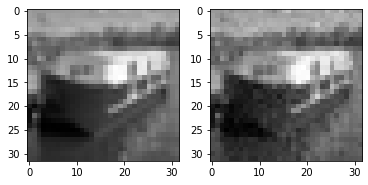

25  :  [0.92465204] 25
50  :  [0.92583585] 25
75  :  [0.92773354] 25
100  :  [0.9280082] 25
125  :  [0.9280082] 25
150  :  [0.9280082] 25
175  :  [0.930423] 25
200  :  [0.9305877] 25
225  :  [0.93169206] 25
250  :  [0.9392966] 25
275  :  [0.9392966] 25
300  :  [0.9392966] 25
325  :  [0.9453938] 25
350  :  [0.9453938] 25
375  :  [0.94743323] 25
400  :  [0.948808] 25
425  :  [0.94986224] 25
450  :  [0.949933] 25
475  :  [0.949933] 25
500  :  [0.95345104] 25
525  :  [0.9540427] 25
550  :  [0.9540427] 25
575  :  [0.9540427] 25
600  :  [0.9549046] 25
625  :  [0.9555901] 25
650  :  [0.9596814] 25
675  :  [0.96033883] 25
700  :  [0.9612036] 25
725  :  [0.9612036] 25
750  :  [0.9612036] 25
775  :  [0.96402156] 25
800  :  [0.96402156] 25
Time:  160.70704197883606  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


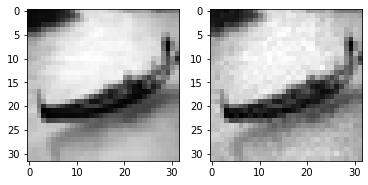

25  :  [0.8484061] 25
50  :  [0.8484061] 25
75  :  [0.85233366] 25
100  :  [0.85233366] 25
125  :  [0.85288954] 25
150  :  [0.8613572] 25
175  :  [0.86454725] 25
200  :  [0.8656991] 25
225  :  [0.8656991] 25
250  :  [0.8658931] 25
275  :  [0.8737291] 25
300  :  [0.8737291] 25
325  :  [0.8737291] 25
350  :  [0.8737291] 25
375  :  [0.8768568] 25
400  :  [0.8768568] 25
425  :  [0.8768568] 25
450  :  [0.8846902] 25
475  :  [0.8846902] 25
500  :  [0.8897215] 25
525  :  [0.8897215] 25
550  :  [0.8897215] 25
575  :  [0.8897215] 25
600  :  [0.8904844] 25
625  :  [0.8904844] 25
650  :  [0.8904844] 25
675  :  [0.892188] 25
700  :  [0.892188] 25
725  :  [0.892188] 25
750  :  [0.8930508] 25
775  :  [0.8936636] 25
800  :  [0.8963406] 25
Time:  165.05348134040833  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


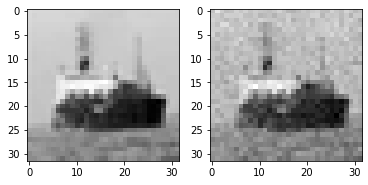

25  :  [0.9336431] 25
50  :  [0.9336431] 25
75  :  [0.9334393] 25
100  :  [0.9393034] 25
125  :  [0.9390403] 25
150  :  [0.9390403] 25
175  :  [0.9443065] 25
200  :  [0.9446815] 25
225  :  [0.9446815] 25
250  :  [0.9446815] 25
275  :  [0.9446815] 25
300  :  [0.9446815] 25
325  :  [0.9446815] 25
350  :  [0.9446815] 25
375  :  [0.9446815] 25
400  :  [0.9446815] 25
425  :  [0.9446815] 25
450  :  [0.9448252] 25
475  :  [0.9447675] 25
500  :  [0.9447675] 25
525  :  [0.9447675] 25
550  :  [0.9447675] 25
575  :  [0.9476621] 25
600  :  [0.9489466] 25
625  :  [0.9489466] 25
650  :  [0.9489466] 25
675  :  [0.9492146] 25
700  :  [0.9546851] 25
725  :  [0.9546852] 25
750  :  [0.9546852] 25
775  :  [0.9546852] 25
800  :  [0.95482683] 25
Time:  160.0789430141449  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


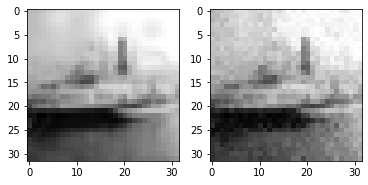

25  :  [0.96258795] 25
50  :  [0.96258795] 25
75  :  [0.96258795] 25
100  :  [0.9626304] 25
125  :  [0.9626304] 25
150  :  [0.9626304] 25
175  :  [0.9626304] 25
200  :  [0.9626304] 25
225  :  [0.9626304] 25
250  :  [0.9626304] 25
275  :  [0.9626304] 25
300  :  [0.9648043] 25
325  :  [0.9648164] 25
350  :  [0.9648164] 25
375  :  [0.9700577] 25
400  :  [0.97168624] 25
425  :  [0.97168624] 25
450  :  [0.97168624] 25
475  :  [0.97168624] 25
500  :  [0.9722275] 25
525  :  [0.9722275] 25
550  :  [0.9722275] 25
575  :  [0.97499573] 25
600  :  [0.97499573] 25
625  :  [0.97570574] 25
650  :  [0.9760265] 25
675  :  [0.97646534] 25
700  :  [0.9765239] 25
725  :  [0.9766104] 25
750  :  [0.9769121] 25
775  :  [0.977111] 25
800  :  [0.97711253] 25
Time:  163.37502908706665  seconds
Original class:  8
Prediction for normal image:  [8]
Prediction for adversarial image:  [2]


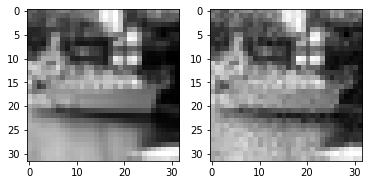

25  :  [0.7715329] 25
50  :  [0.7715329] 25
75  :  [0.7720846] 25
100  :  [0.7720846] 25
125  :  [0.7720846] 25
150  :  [0.7941141] 25
175  :  [0.7941141] 25
200  :  [0.7941141] 25
225  :  [0.7941141] 25
250  :  [0.7971698] 25
275  :  [0.8035263] 25
300  :  [0.8035263] 25
325  :  [0.8158823] 25
350  :  [0.8158823] 25
375  :  [0.82275534] 25
400  :  [0.84433746] 25
425  :  [0.84433746] 25
450  :  [0.84433746] 25
475  :  [0.8481192] 25
500  :  [0.8496355] 25
525  :  [0.86074734] 25
550  :  [0.86074734] 25
575  :  [0.86425996] 25
600  :  [0.86425996] 25
625  :  [0.8762853] 25
650  :  [0.8763053] 25
675  :  [0.8763053] 25
700  :  [0.87645465] 25
725  :  [0.8773654] 25
750  :  [0.87851954] 25
775  :  [0.8810506] 25
800  :  [0.8810506] 25
825  :  [0.8820153] 25
850  :  [0.8835554] 25
875  :  [0.8847152] 25
900  :  [0.8878144] 25
925  :  [0.8883977] 25
950  :  [0.8884487] 25
975  :  [0.8893792] 25
1000  :  [0.8921652] 25
1025  :  [0.8945349] 25
1050  :  [0.8945349] 25
1075  :  [0.8945349] 25


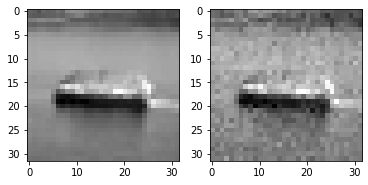

25  :  [0.89073384] 25
50  :  [0.89700955] 25
75  :  [0.9058513] 25
100  :  [0.92384017] 25
125  :  [0.9238831] 25
150  :  [0.92660606] 25
175  :  [0.9265784] 25
200  :  [0.9469774] 25
225  :  [0.94690824] 25
250  :  [0.94690824] 25
275  :  [0.94690824] 25
300  :  [0.94690824] 25
325  :  [0.9484598] 25
350  :  [0.9484598] 25
375  :  [0.9484598] 25
400  :  [0.9484598] 25
425  :  [0.9484598] 25
450  :  [0.9484598] 25
475  :  [0.951143] 25
500  :  [0.95353556] 25
525  :  [0.9588312] 25
550  :  [0.9619631] 25
575  :  [0.9645513] 25
600  :  [0.96559656] 25
625  :  [0.96559656] 25
650  :  [0.9673395] 25
675  :  [0.9673395] 25
700  :  [0.9673395] 25
725  :  [0.9673395] 25
750  :  [0.9714254] 25
775  :  [0.9714254] 25
800  :  [0.9714254] 25
825  :  [0.9714254] 25
850  :  [0.9718887] 25
875  :  [0.97212994] 25
900  :  [0.97212994] 25
925  :  [0.9724215] 25
950  :  [0.9724215] 25
975  :  [0.9725738] 25
Time:  194.2641806602478  seconds
Original class:  9
Prediction for normal image:  [9]
Predict

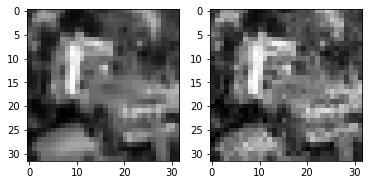

25  :  [0.89428115] 25
50  :  [0.90204144] 25
75  :  [0.91893315] 25
100  :  [0.9185465] 25
125  :  [0.9369209] 25
150  :  [0.9365976] 25
175  :  [0.9365976] 25
200  :  [0.9365976] 25
225  :  [0.9365976] 25
250  :  [0.9365976] 25
275  :  [0.9459622] 25
300  :  [0.9455468] 25
325  :  [0.9455468] 25
350  :  [0.9455468] 25
375  :  [0.9455468] 25
400  :  [0.9455468] 25
425  :  [0.9455468] 25
450  :  [0.9455468] 25
475  :  [0.9455468] 25
500  :  [0.9455468] 25
525  :  [0.9455468] 25
550  :  [0.9455468] 25
575  :  [0.9455468] 25
600  :  [0.95412314] 25
625  :  [0.95412314] 25
650  :  [0.95412314] 25
675  :  [0.95412314] 25
700  :  [0.95916724] 25
725  :  [0.95887667] 25
750  :  [0.9632474] 25
775  :  [0.9632474] 25
800  :  [0.9651245] 25
825  :  [0.9651245] 25
850  :  [0.9654233] 25
875  :  [0.9654233] 25
900  :  [0.9654233] 25
Time:  178.51880860328674  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [2]


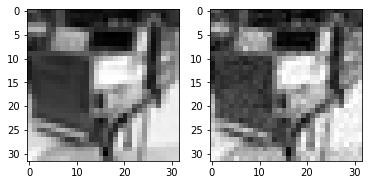

25  :  [0.95216036] 25
50  :  [0.9544344] 25
75  :  [0.9569646] 25
100  :  [0.9569646] 25
125  :  [0.9569646] 25
150  :  [0.9569646] 25
175  :  [0.9569646] 25
200  :  [0.9569646] 25
225  :  [0.9569646] 25
250  :  [0.9569646] 25
275  :  [0.9569646] 25
300  :  [0.9569646] 25
325  :  [0.9569646] 25
350  :  [0.9569646] 25
375  :  [0.9569646] 25
400  :  [0.9569646] 25
425  :  [0.9569646] 25
450  :  [0.9569646] 25
475  :  [0.9569646] 25
500  :  [0.9569646] 25
525  :  [0.9569646] 25
550  :  [0.9569646] 25
575  :  [0.9569646] 25
600  :  [0.9569646] 25
625  :  [0.9569646] 25
650  :  [0.9569646] 25
675  :  [0.9569646] 25
700  :  [0.9569646] 25
725  :  [0.9569646] 25
750  :  [0.9569646] 25
775  :  [0.9569646] 25
800  :  [0.9569646] 25
Time:  160.03738951683044  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


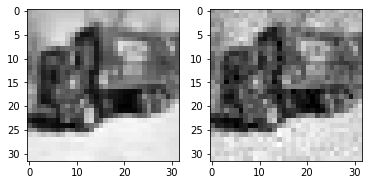

25  :  [0.86711884] 25
50  :  [0.86711884] 25
75  :  [0.86711884] 25
100  :  [0.86711884] 25
125  :  [0.86711884] 25
150  :  [0.87132585] 25
175  :  [0.8720965] 25
200  :  [0.8720965] 25
225  :  [0.8720965] 25
250  :  [0.8720965] 25
275  :  [0.8935313] 25
300  :  [0.89348483] 25
325  :  [0.89348483] 25
350  :  [0.89348483] 25
375  :  [0.89348483] 25
400  :  [0.89674914] 25
425  :  [0.89674914] 25
450  :  [0.89685917] 25
475  :  [0.89685917] 25
500  :  [0.89726686] 25
525  :  [0.9010342] 25
550  :  [0.90130407] 25
575  :  [0.9013107] 25
600  :  [0.9013107] 25
625  :  [0.9013107] 25
650  :  [0.9013746] 25
675  :  [0.9013746] 25
700  :  [0.9030603] 25
725  :  [0.90312034] 25
750  :  [0.9039357] 25
775  :  [0.9046412] 25
800  :  [0.9048007] 25
825  :  [0.9055807] 25
850  :  [0.9058126] 25
875  :  [0.9069636] 25
900  :  [0.90713835] 25
925  :  [0.90713835] 25
950  :  [0.90713835] 25
975  :  [0.9075361] 25
1000  :  [0.9075361] 25
1025  :  [0.9075361] 25
1050  :  [0.9075361] 25
Time:  212.881

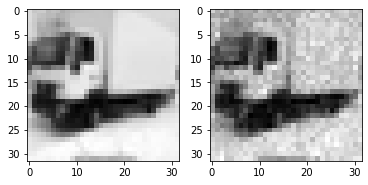

25  :  [0.8485326] 25
50  :  [0.85367334] 25
75  :  [0.8868562] 25
100  :  [0.8900038] 25
125  :  [0.89223164] 25
150  :  [0.90876436] 25
175  :  [0.90877956] 25
200  :  [0.90877956] 25
225  :  [0.90877956] 25
250  :  [0.90877956] 25
275  :  [0.90877956] 25
300  :  [0.90877956] 25
325  :  [0.90877956] 25
350  :  [0.90975434] 25
375  :  [0.90975434] 25
400  :  [0.90975434] 25
425  :  [0.90975434] 25
450  :  [0.90975434] 25
475  :  [0.91152436] 25
500  :  [0.91217124] 25
525  :  [0.9210012] 25
550  :  [0.92155874] 25
575  :  [0.9213971] 25
600  :  [0.92194164] 25
625  :  [0.92196137] 25
650  :  [0.92196137] 25
675  :  [0.9232827] 25
700  :  [0.92482436] 25
725  :  [0.9304718] 25
750  :  [0.9304718] 25
775  :  [0.9304718] 25
800  :  [0.9304718] 25
825  :  [0.9304718] 25
850  :  [0.9304718] 25
875  :  [0.9304718] 25
900  :  [0.9304718] 25
925  :  [0.9304718] 25
Time:  186.4606432914734  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [2]


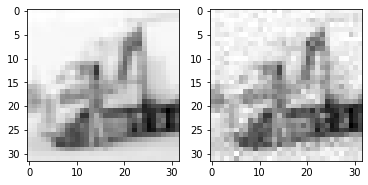

25  :  [0.77749956] 25
50  :  [0.8215698] 25
75  :  [0.8075887] 25
100  :  [0.8105304] 25
125  :  [0.8105304] 25
150  :  [0.84056973] 25
175  :  [0.8368596] 25
200  :  [0.8368596] 25
225  :  [0.8368596] 25
250  :  [0.8368596] 25
275  :  [0.8448152] 25
300  :  [0.8874636] 25
325  :  [0.8874636] 25
350  :  [0.8874636] 25
375  :  [0.89041257] 25
400  :  [0.89041257] 25
425  :  [0.89041257] 25
450  :  [0.892766] 25
475  :  [0.892766] 25
500  :  [0.892766] 25
525  :  [0.892766] 25
550  :  [0.8956928] 25
575  :  [0.8956928] 25
600  :  [0.8956928] 25
625  :  [0.8956928] 25
650  :  [0.8956928] 25
675  :  [0.8956928] 25
700  :  [0.8956928] 25
725  :  [0.8956928] 25
750  :  [0.8956928] 25
775  :  [0.8956928] 25
800  :  [0.8956928] 25
825  :  [0.8956928] 25
850  :  [0.8956928] 25
875  :  [0.8960791] 25
900  :  [0.8960791] 25
925  :  [0.8960791] 25
950  :  [0.9044677] 25
975  :  [0.90446585] 25
1000  :  [0.90446585] 25
1025  :  [0.90446585] 25
1050  :  [0.9045447] 25
1075  :  [0.9045447] 25
Time: 

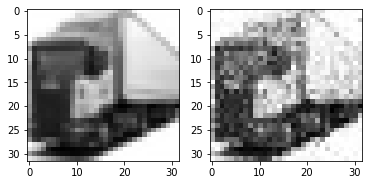

25  :  [0.93276083] 25
50  :  [0.9377856] 25
75  :  [0.9377856] 25
100  :  [0.9377856] 25
125  :  [0.9377856] 25
150  :  [0.9377856] 25
175  :  [0.9377856] 25
200  :  [0.9387038] 25
225  :  [0.9387038] 25
250  :  [0.9387038] 25
275  :  [0.9387038] 25
300  :  [0.9387038] 25
325  :  [0.9387038] 25
350  :  [0.9387038] 25
375  :  [0.9387038] 25
400  :  [0.9387038] 25
425  :  [0.9387038] 25
450  :  [0.946555] 25
475  :  [0.946555] 25
500  :  [0.946555] 25
525  :  [0.946555] 25
550  :  [0.946555] 25
575  :  [0.946555] 25
600  :  [0.946555] 25
625  :  [0.946555] 25
650  :  [0.946555] 25
675  :  [0.946555] 25
700  :  [0.946555] 25
725  :  [0.946555] 25
750  :  [0.946555] 25
775  :  [0.946555] 25
800  :  [0.946555] 25
Time:  152.75497603416443  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [4]


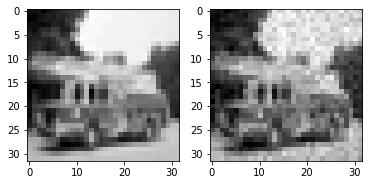

25  :  [0.92286706] 25
50  :  [0.92286706] 25
75  :  [0.95743644] 25
100  :  [0.95983577] 25
125  :  [0.9598328] 25
150  :  [0.9598328] 25
175  :  [0.9598328] 25
200  :  [0.9598328] 25
225  :  [0.9598328] 25
250  :  [0.9598328] 25
275  :  [0.9613652] 25
300  :  [0.9613652] 25
325  :  [0.9613652] 25
350  :  [0.9613652] 25
375  :  [0.96450603] 25
400  :  [0.9645369] 25
425  :  [0.9645369] 25
450  :  [0.9685721] 25
475  :  [0.9685721] 25
500  :  [0.9685721] 25
525  :  [0.9710914] 25
550  :  [0.9712136] 25
575  :  [0.9712136] 25
600  :  [0.9712136] 25
625  :  [0.9712136] 25
650  :  [0.97198427] 25
675  :  [0.97198427] 25
700  :  [0.97198427] 25
725  :  [0.97344476] 25
750  :  [0.9749638] 25
775  :  [0.9750807] 25
800  :  [0.9751909] 25
825  :  [0.97555757] 25
850  :  [0.976305] 25
Time:  165.3512954711914  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


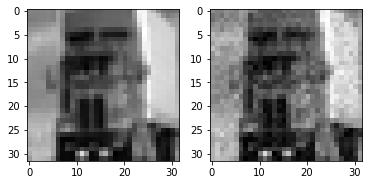

25  :  [0.89757] 25
50  :  [0.9103478] 25
75  :  [0.91940325] 25
100  :  [0.91940325] 25
125  :  [0.9220065] 25
150  :  [0.92489207] 25
175  :  [0.92489207] 25
200  :  [0.92489207] 25
225  :  [0.92489207] 25
250  :  [0.92957497] 25
275  :  [0.92957497] 25
300  :  [0.93317306] 25
325  :  [0.932998] 25
350  :  [0.932998] 25
375  :  [0.932998] 25
400  :  [0.9353616] 25
425  :  [0.9353466] 25
450  :  [0.9451021] 25
475  :  [0.95669436] 25
500  :  [0.96104836] 25
525  :  [0.96104836] 25
550  :  [0.96104836] 25
575  :  [0.96104836] 25
600  :  [0.96104836] 25
625  :  [0.9610991] 25
650  :  [0.9610983] 25
675  :  [0.9616761] 25
700  :  [0.96277195] 25
725  :  [0.9633858] 25
750  :  [0.9634812] 25
775  :  [0.96397316] 25
800  :  [0.9645227] 25
825  :  [0.9645227] 25
850  :  [0.96455026] 25
875  :  [0.96455026] 25
900  :  [0.96499026] 25
925  :  [0.96509886] 25
950  :  [0.96509886] 25
975  :  [0.96509886] 25
1000  :  [0.9652208] 25
1025  :  [0.9654929] 25
1050  :  [0.9655626] 25
1075  :  [0.9655

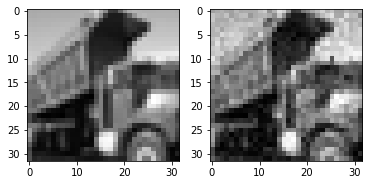

25  :  [0.97016394] 25
50  :  [0.97115016] 25
75  :  [0.97467554] 25
100  :  [0.97485673] 25
125  :  [0.97664315] 25
150  :  [0.97664315] 25
175  :  [0.97664315] 25
200  :  [0.97664315] 25
225  :  [0.97664315] 25
250  :  [0.97664315] 25
275  :  [0.97824943] 25
300  :  [0.9784196] 25
325  :  [0.9784233] 25
350  :  [0.9792757] 25
375  :  [0.979841] 25
400  :  [0.9798403] 25
425  :  [0.9798403] 25
450  :  [0.9807284] 25
475  :  [0.9807423] 25
500  :  [0.9807423] 25
525  :  [0.9810467] 25
550  :  [0.98138666] 25
575  :  [0.982781] 25
600  :  [0.982781] 25
625  :  [0.9832567] 25
650  :  [0.98349965] 25
675  :  [0.9846026] 25
700  :  [0.98464024] 25
725  :  [0.98464024] 25
750  :  [0.985379] 25
775  :  [0.98590636] 25
800  :  [0.98590636] 25
Time:  164.98113465309143  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


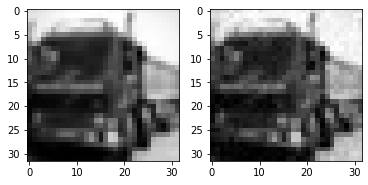

25  :  [0.9619061] 25
50  :  [0.9619061] 25
75  :  [0.96550304] 25
100  :  [0.96550304] 25
125  :  [0.96550304] 25
150  :  [0.9670354] 25
175  :  [0.9686471] 25
200  :  [0.97700995] 25
225  :  [0.9777459] 25
250  :  [0.9800689] 25
275  :  [0.9800689] 25
300  :  [0.98141235] 25
325  :  [0.98141366] 25
350  :  [0.98197883] 25
375  :  [0.98226166] 25
400  :  [0.98318565] 25
425  :  [0.9839958] 25
450  :  [0.98401606] 25
475  :  [0.98401606] 25
500  :  [0.98401606] 25
525  :  [0.98549205] 25
550  :  [0.98549205] 25
575  :  [0.98549205] 25
600  :  [0.9856335] 25
625  :  [0.98625743] 25
650  :  [0.98625743] 25
675  :  [0.98671174] 25
700  :  [0.98671174] 25
725  :  [0.98671174] 25
750  :  [0.98693657] 25
775  :  [0.9871199] 25
800  :  [0.98712003] 25
Time:  161.40519070625305  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


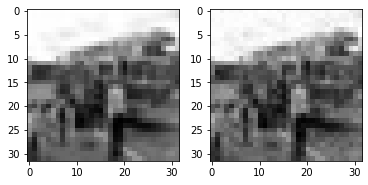

25  :  [0.93320477] 25
50  :  [0.93565714] 25
75  :  [0.94012976] 25
100  :  [0.94284] 25
125  :  [0.9457989] 25
150  :  [0.95307267] 25
175  :  [0.95307267] 25
200  :  [0.9551812] 25
225  :  [0.95751166] 25
250  :  [0.95751166] 25
275  :  [0.95934147] 25
300  :  [0.95934147] 25
325  :  [0.9632499] 25
350  :  [0.9632499] 25
375  :  [0.96595496] 25
400  :  [0.96595496] 25
425  :  [0.96834815] 25
450  :  [0.9685708] 25
475  :  [0.9685708] 25
500  :  [0.970441] 25
525  :  [0.9716369] 25
550  :  [0.9732725] 25
575  :  [0.97347903] 25
600  :  [0.9753456] 25
625  :  [0.9753456] 25
650  :  [0.97558475] 25
675  :  [0.9757664] 25
700  :  [0.9757664] 25
725  :  [0.9760553] 25
750  :  [0.9763279] 25
775  :  [0.9763279] 25
800  :  [0.97660935] 25
Time:  163.34727811813354  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


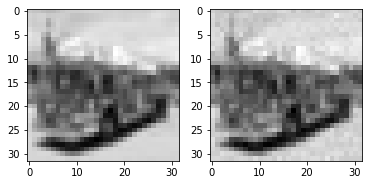

25  :  [0.9582321] 25
50  :  [0.9582321] 25
75  :  [0.9582321] 25
100  :  [0.9582321] 25
125  :  [0.9582321] 25
150  :  [0.9582321] 25
175  :  [0.9582321] 25
200  :  [0.9582321] 25
225  :  [0.9638814] 25
250  :  [0.9639432] 25
275  :  [0.9640254] 25
300  :  [0.9640581] 25
325  :  [0.96406245] 25
350  :  [0.96481] 25
375  :  [0.9699496] 25
400  :  [0.9720162] 25
425  :  [0.97270954] 25
450  :  [0.97270954] 25
475  :  [0.9728112] 25
500  :  [0.97320914] 25
525  :  [0.97320914] 25
550  :  [0.97320914] 25
575  :  [0.9736421] 25
600  :  [0.9738631] 25
625  :  [0.9743604] 25
650  :  [0.974467] 25
675  :  [0.9748733] 25
700  :  [0.97493637] 25
725  :  [0.9749589] 25
750  :  [0.9749589] 25
775  :  [0.9749589] 25
800  :  [0.9749589] 25
Time:  162.8582444190979  seconds
Original class:  9
Prediction for normal image:  [9]
Prediction for adversarial image:  [6]


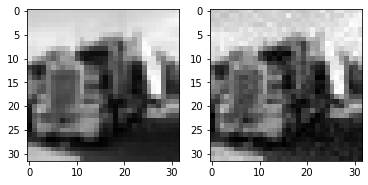

25  :  [0.9678687] 25
50  :  [0.9701761] 25
75  :  [0.9719798] 25
100  :  [0.97324276] 25
125  :  [0.9745529] 25
150  :  [0.9753509] 25
175  :  [0.9755969] 25
200  :  [0.97562313] 25
225  :  [0.9778664] 25
250  :  [0.9794654] 25
275  :  [0.9794287] 25
300  :  [0.9794287] 25
325  :  [0.9810505] 25
350  :  [0.9811163] 25
375  :  [0.98342013] 25
400  :  [0.98342013] 25
425  :  [0.98342013] 25
450  :  [0.98342013] 25
475  :  [0.98342013] 25
500  :  [0.98342013] 25
525  :  [0.98342013] 25
550  :  [0.98342013] 25
575  :  [0.98342013] 25
600  :  [0.98371935] 25
625  :  [0.9852647] 25
650  :  [0.9852647] 25
675  :  [0.9852647] 25
700  :  [0.9852647] 25
725  :  [0.9852647] 25
750  :  [0.9852647] 25
775  :  [0.9852647] 25
800  :  [0.9853914] 25
Time:  160.3356077671051  seconds
Original class:  9
Prediction for normal image:  [1]
Prediction for adversarial image:  [6]


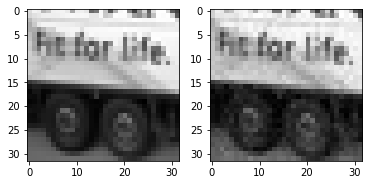

In [8]:
de_npc = DE_NPC(param_dict)
times = []
nfes = []
psnrs = []
predicted_classes = []
for adv_ind in range(adversarial.shape[0]):
  de_npc.change_input(adversarial[adv_ind].reshape((32*32,1)),adversarial_y[adv_ind],32*32)
  timed, nfed = de_npc.execute(model)
  times.append(timed)
  nfes.append(nfed)
## increasing coefficient of the first term in fitness function and
## increasing the standard deviation of the noise increases the chance
## to find an adversarial example but it decreases the image quality
## of the adversarial example found
## also this algorithm can discard the best individual in the next generation
## to prevent this we can put it to population[0] after shuffling
  adv = np.clip(de_npc.X_best, 0, 255)
  psnrs.append(PSNR(adversarial[adv_ind],adv))
  preds_adv = model.predict(adv.reshape(1,32,32,1) / 255.0)
  predicted_classes.extend(np.argmax(preds_adv,axis=1))
  print("Original class: ",adversarial_y[adv_ind][0])
  print("Prediction for normal image: ", np.argmax(model.predict(adversarial[adv_ind].reshape(1,32,32,1) / 255.0),axis=1))
  print("Prediction for adversarial image: ",np.argmax(preds_adv,axis=1))
  fig = plt.figure()
  ax1 = fig.add_subplot(1,2,1)
  ax1.imshow(adversarial[adv_ind].reshape(32,32),cmap="gray")
  ax2 = fig.add_subplot(1,2,2)
  ax2.imshow(de_npc.X_best.reshape(32,32),cmap="gray")
  plt.show()
  adversarial[adv_ind] = de_npc.X_best.reshape((32,32,1))

airplane										
automobile										
bird										
cat										
deer										
dog										
frog										
horse										
ship										
truck

In [0]:
import pickle

In [0]:
file_ = open('adv_de_cnn_cifar_ssim_seed1', 'wb')
pickle.dump(adversarial, file_)
pickle.dump(times, file_)
pickle.dump(nfes , file_)
pickle.dump(psnrs , file_)
pickle.dump(predicted_classes, file_)
file_.close()

In [11]:
print(np.max(times))
print(np.min(times))
print(np.mean(times))
print(np.std(times))

1126.265106678009
117.92928338050842
185.84653693034235
94.105392746475


In [12]:
print(np.max(nfes))
print(np.min(nfes))
print(np.mean(nfes))
print(np.std(nfes))

10001
800
1121.0075187969924
820.054018908773


In [13]:
print(np.max(psnrs))
print(np.min(psnrs))
print(np.mean(psnrs))
print(np.std(psnrs))

23.608304893734243
5.513247043246057
11.061730173386955
2.9810800527527292
